## REGRESSION LOGISTIQUE
#### 1. Sélectionner les variables explicatives en utilisant l’algorithme Recursive feature elimination. 
ATTENTION : Cette méthode n’a pas encore été abordée en cours. Néanmoins, elle est simple à appliquer avec scikit-learn. Vous pouvez bien évidement choisir une autre méthode de sélection de variables explicatives.
#### 2. Elaborer un modèle de régression logistique pour prédire la variable alive en fonction des variables explicatives choisies.
#### 3. Conclure

---------------------------------------------------------------------------------------------------------------------

### Importer les librairies


In [234]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from numpy import set_printoptions

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Importer la dataset et l'explorer

In [135]:
data = pd.read_csv('trainClean.csv', sep=',', encoding='utf-8')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult


#### Simuler (Dummy) les catégorielles features de la dataset

   ##### Compter le nombre de  catégorielles features que nous avons dans l'ensemble de données

In [136]:
categorical_feature_columns = list(set(data.columns) - set(data._get_numeric_data().columns))
categorical_feature_columns

['Age_categories', 'Name', 'Sex', 'Embarked', 'Ticket']

**Nous allons supprimer les deux colonnes: Nom et Ticket (car elles ne contiennent pas d'informations utiles pour nous) et facturer et aprés supprimer le reste des colonnes **

In [137]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [138]:
data = create_dummies(data,"Sex")

In [139]:
data = create_dummies(data,"Age_categories")

In [140]:
data = create_dummies(data,"Embarked")

In [141]:
data=data.drop(['Name','Ticket','Sex','Sex_male','Age_categories','Embarked','PassengerId'], axis=1)

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 17 columns):
Survived                      889 non-null int64
Pclass                        889 non-null int64
Age                           889 non-null float64
SibSp                         889 non-null int64
Parch                         889 non-null int64
Fare                          889 non-null float64
Sex_female                    889 non-null uint8
Age_categories_Adult          889 non-null uint8
Age_categories_Child          889 non-null uint8
Age_categories_Infant         889 non-null uint8
Age_categories_Missing        889 non-null uint8
Age_categories_Senior         889 non-null uint8
Age_categories_Teenager       889 non-null uint8
Age_categories_Young Adult    889 non-null uint8
Embarked_C                    889 non-null uint8
Embarked_Q                    889 non-null uint8
Embarked_S                    889 non-null uint8
dtypes: float64(2), int64(4), uint8(11)
memory usage: 51.3

### Création d'un train set et validation set

In [151]:
X = data.drop(['Survived'], axis=1)
y = data['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=5)
#X.columns

In [152]:
print(X_train.shape,'\n')
print(X_valid.shape,'\n')
print(y_train.shape,'\n')
print(y_valid.shape,'\n')

(711, 16) 

(178, 16) 

(711,) 

(178,) 



###### Compter le nombre de passagers survivants et non survivants dans l'ensemble de données de validation

In [183]:
Alive=pd.DataFrame(y_valid, columns = ['Survived'])
Alive[Alive['Survived']==0].count()

Survived    119
dtype: int64

In [184]:
Alive[Alive['Survived']==1].count()

Survived    59
dtype: int64

### 1. Model de regression logistique en utilisant tout les features 

In [153]:
regLogistic=LogisticRegression(solver='newton-cg', multi_class='auto', penalty ='l2', random_state = None)

###### Fonction pour former, valider et évaluer le modèle de régression logistique

In [271]:
def logisticeModel(columNames):
    logReg_model = regLogistic.fit(X_train[columNames], y_train)
    #Test the model
    y_pred = logReg_model.predict(X_valid[columNames])
    
    print(classification_report(y_valid, y_pred))

    print(accuracy_score(y_valid, y_pred),'\n') # le plus important pour le moment; précisément la première ligne

    # Matrice de confusion
    #affichage plus "joli" de la matrice de confusion
    cm = pd.DataFrame(confusion_matrix(y_valid,y_pred), columns=['prédit ' + str(_) for _ in logReg_model.classes_])
    cm.index = ['vrai ' + str(_) for _ in logReg_model.classes_]
    print(cm)
    
    # Calculer et visualiser ROC et AUC
    proba = logReg_model.predict_proba(X_valid[columNames])
    fpr0, tpr0, thresholds0 = roc_curve(y_valid, proba[:, 1], pos_label=logReg_model.classes_[1], drop_intermediate=False)
    #thresholds0.shape
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.plot([0, 1], [0, 1], 'k--')
    aucf = auc(fpr0, tpr0)
    ax.plot(fpr0, tpr0, label='auc=%1.5f' % aucf)
    ax.set_title('Courbe ROC')
    ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
    ax.legend();

###### Les résultats du premier modèle en prenant toutes les features de l'ensemble de données

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       119
           1       0.80      0.75      0.77        59

    accuracy                           0.85       178
   macro avg       0.84      0.83      0.83       178
weighted avg       0.85      0.85      0.85       178

0.8539325842696629 

        prédit 0  prédit 1
vrai 0       108        11
vrai 1        15        44


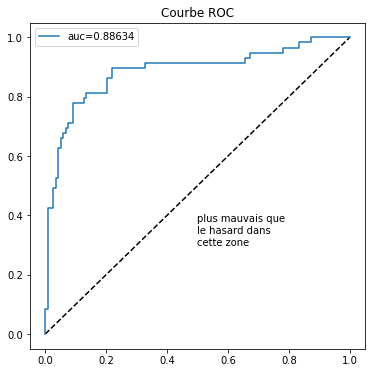

In [272]:
logisticeModel(X_train.columns.tolist())

*** Même si nous avons obtenu une bonne valeur pour la précision avec toutes les fonctionnalités, nous avons essayé de choisir les fonctionnalités les plus explicatives pour minimiser le temps total de training, pour cela nous avons essayé plusieurs algorithmes, qui sont: Recursive feature elimination (RFE), Recursive feature elimination avec cross-validation (RFECV), Univariate Feature Selection (SelectKBest)***

### 2.Model de regression logistique par sélectionner les variables explicatives en utilisant l’algorithme Recursive feature elimination (RFE). 

In [307]:
from sklearn.feature_selection import RFE
# utilise regression lineair comme model
# classer toutes les features, c.a.d poursuivre l'élimination jusqu'à la dernière
rfe=RFE(regLogistic,n_features_to_select=1)
names=X_train.columns.tolist()
rfe.fit(X_train,y_train)
print("Features triées par leurs rangs ")
print(sorted(zip(map(lambda x: round(x,4),rfe.ranking_),names)))

Features triées par leurs rangs 
[(1, 'Sex_female'), (2, 'Age_categories_Infant'), (3, 'Pclass'), (4, 'Age_categories_Senior'), (5, 'Age_categories_Adult'), (6, 'Embarked_S'), (7, 'Age_categories_Child'), (8, 'SibSp'), (9, 'Age_categories_Missing'), (10, 'Age_categories_Teenager'), (11, 'Parch'), (12, 'Embarked_C'), (13, 'Embarked_Q'), (14, 'Age_categories_Young Adult'), (15, 'Age'), (16, 'Fare')]


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       119
           1       0.81      0.78      0.79        59

    accuracy                           0.87       178
   macro avg       0.85      0.84      0.85       178
weighted avg       0.86      0.87      0.86       178

0.8651685393258427 

        prédit 0  prédit 1
vrai 0       108        11
vrai 1        13        46


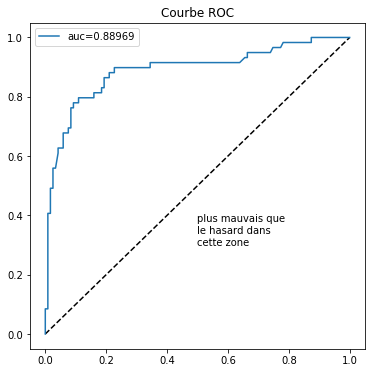

In [308]:
#colNmae=['Sex_female','Age_categories_Infant','Pclass',]
colNmae=['Sex_female', 'Age_categories_Infant', 'Pclass', 'Age_categories_Senior', 'Age_categories_Adult', 'Embarked_S', 'Age_categories_Child', 'SibSp', 'Age_categories_Missing', 'Age_categories_Teenager', 'Parch','Age']
logisticeModel(colNmae)

### 3. Model regression logistique par sélectionner les variables explicatives en utilisant l’algorithme Recursive feature elimination avec cross-validation (RFECV). 

In [309]:
rfecv = RFECV(estimator=regLogistic, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 14
Best features : Index(['Pclass', 'SibSp', 'Parch', 'Sex_female', 'Age_categories_Adult',
       'Age_categories_Child', 'Age_categories_Infant',
       'Age_categories_Missing', 'Age_categories_Senior',
       'Age_categories_Teenager', 'Age_categories_Young Adult', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [310]:
rfecv.score(X_valid, y_valid)

0.8539325842696629

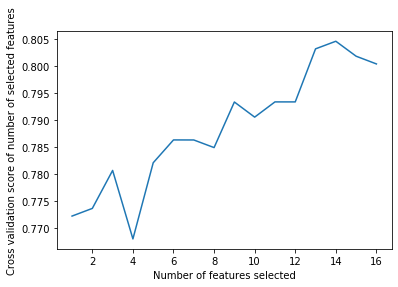

In [311]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [312]:
x_train_rfecv = rfecv.transform(X_train)
x_valid_rfecv = rfecv.transform(X_valid)

In [313]:
logReg_rfecv_model = regLogistic.fit(x_train_rfecv, y_train)

In [314]:
#Test the model
y_pred = logReg_rfecv_model.predict(x_valid_rfecv)

##### Évaluation du modèle

In [315]:
print(classification_report(y_valid, y_pred))

print('accuracy: ',accuracy_score(y_valid, y_pred),'\n') # le plus important pour le moment; précisément la première ligne

print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       119
           1       0.78      0.78      0.78        59

    accuracy                           0.85       178
   macro avg       0.84      0.84      0.84       178
weighted avg       0.85      0.85      0.85       178

accuracy:  0.8539325842696629 

[[106  13]
 [ 13  46]]


### 4. Model de regression logistique en utilisant SelectKBest

In [326]:
# Create and fit selector
#selector = SelectKBest(f_classif, k=4)
selector = SelectKBest(mutual_info_classif, k=5)
#selector = SelectKBest(chi2, k=4)
selector.fit(X_train,y_train)

SelectKBest(k=5,
            score_func=<function mutual_info_classif at 0x0000025CB59A2678>)

In [327]:
# what are scores for the features
for i in range(len(selector.scores_)):
	print('Feature %d: %f' % (i, selector.scores_[i]))

Feature 0: 0.040301
Feature 1: 0.030888
Feature 2: 0.012395
Feature 3: 0.024801
Feature 4: 0.140522
Feature 5: 0.137202
Feature 6: 0.000000
Feature 7: 0.030836
Feature 8: 0.001635
Feature 9: 0.000000
Feature 10: 0.000000
Feature 11: 0.018351
Feature 12: 0.000000
Feature 13: 0.009282
Feature 14: 0.000000
Feature 15: 0.001814


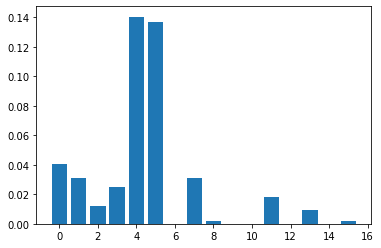

In [328]:
# plot the scores
from matplotlib import pyplot
pyplot.bar([i for i in range(len(selector.scores_))], selector.scores_)
pyplot.show()

In [329]:
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
#features_df_new = X_train.iloc[:,cols].names
#features_df_new
selectedColumns=X_train.columns[cols].tolist()
selectedColumns

['Pclass', 'Age', 'Fare', 'Sex_female', 'Age_categories_Child']

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       119
           1       0.73      0.80      0.76        59

    accuracy                           0.84       178
   macro avg       0.81      0.83      0.82       178
weighted avg       0.84      0.84      0.84       178

0.8370786516853933 

        prédit 0  prédit 1
vrai 0       102        17
vrai 1        12        47


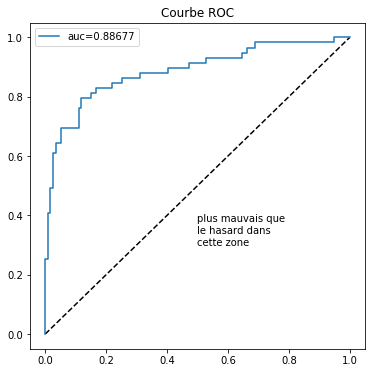

In [330]:
logisticeModel(selectedColumns)

### 5. Model de regression logistique en utilisant PCA

In [301]:
# normalize data
from sklearn import preprocessing

data_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns) 
model = PCA(n_components=2).fit(X_train)
X_pc = model.transform(X_train)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names =X_train.columns.tolist()

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,Fare
1,PC2,Age


              precision    recall  f1-score   support

           0       0.67      0.86      0.75       119
           1       0.35      0.15      0.21        59

    accuracy                           0.62       178
   macro avg       0.51      0.50      0.48       178
weighted avg       0.56      0.62      0.57       178

0.6235955056179775 

        prédit 0  prédit 1
vrai 0       102        17
vrai 1        50         9


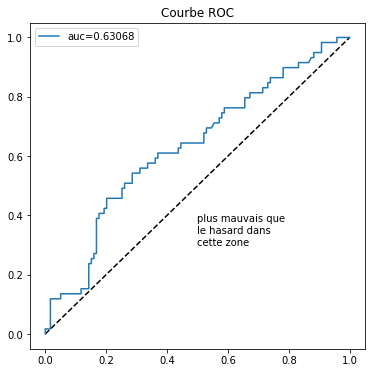

In [302]:
c=df[1].tolist()
logisticeModel(c)

### 6. Model de regression logistique en utilisant la meilleure combinaison entre les features

In [246]:
import itertools
def bruteforce(df):
    features = df.drop(['Survived'], axis=1)
    target = df['Survived']
    
    combs = []
    for i in range(2, len(features.columns)):
        for comb in itertools.combinations(features, i):
            combs.append(comb)
    
    rows = []
    for i in range(len(combs)):
        X_train, X_test, y_train, y_test = train_test_split(features[list(combs[i])], target, test_size = 0.2, random_state=5)
        clf = LogisticRegression(solver='newton-cg', multi_class='auto', penalty ='l2', random_state = None)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        M = confusion_matrix(y_test, pred)
        rows.append([combs[i], clf.score(X_test, y_test), roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]), M[0,1], M[1,0]])
        print('%s/%s - %s'%(i, len(combs), i/len(combs)*100))
    return rows

In [247]:
result = pd.DataFrame(bruteforce(data), columns=['comb', 'score', 'auc', 'fp', 'tn'])

0/65518 - 0.0
1/65518 - 0.0015262981165481244
2/65518 - 0.0030525962330962488
3/65518 - 0.0045788943496443725
4/65518 - 0.0061051924661924975
5/65518 - 0.007631490582740621
6/65518 - 0.009157788699288745
7/65518 - 0.01068408681583687
8/65518 - 0.012210384932384995
9/65518 - 0.013736683048933118
10/65518 - 0.015262981165481242
11/65518 - 0.016789279282029366
12/65518 - 0.01831557739857749
13/65518 - 0.019841875515125614
14/65518 - 0.02136817363167374
15/65518 - 0.022894471748221863
16/65518 - 0.02442076986476999
17/65518 - 0.02594706798131811
18/65518 - 0.027473366097866235
19/65518 - 0.028999664214414356
20/65518 - 0.030525962330962483
21/65518 - 0.03205226044751061
22/65518 - 0.03357855856405873
23/65518 - 0.03510485668060686
24/65518 - 0.03663115479715498
25/65518 - 0.03815745291370311
26/65518 - 0.03968375103025123
27/65518 - 0.04121004914679935
28/65518 - 0.04273634726334748
29/65518 - 0.0442626453798956
30/65518 - 0.045788943496443725
31/65518 - 0.04731524161299185
32/65518 - 0.04

272/65518 - 0.4151530877010898
273/65518 - 0.4166793858176379
274/65518 - 0.418205683934186
275/65518 - 0.41973198205073414
276/65518 - 0.4212582801672823
277/65518 - 0.42278457828383037
278/65518 - 0.4243108764003785
279/65518 - 0.4258371745169266
280/65518 - 0.42736347263347474
281/65518 - 0.42888977075002294
282/65518 - 0.430416068866571
283/65518 - 0.43194236698311916
284/65518 - 0.43346866509966725
285/65518 - 0.4349949632162154
286/65518 - 0.43652126133276353
287/65518 - 0.4380475594493116
288/65518 - 0.43957385756585976
289/65518 - 0.44110015568240785
290/65518 - 0.442626453798956
291/65518 - 0.4441527519155042
292/65518 - 0.4456790500320522
293/65518 - 0.4472053481486004
294/65518 - 0.4487316462651485
295/65518 - 0.45025794438169664
296/65518 - 0.4517842424982448
297/65518 - 0.45331054061479287
298/65518 - 0.454836838731341
299/65518 - 0.4563631368478891
300/65518 - 0.45788943496443724
301/65518 - 0.45941573308098543
302/65518 - 0.46094203119753346
303/65518 - 0.462468329314081

554/65518 - 0.8455691565676607
555/65518 - 0.847095454684209
556/65518 - 0.848621752800757
557/65518 - 0.8501480509173052
558/65518 - 0.8516743490338532
559/65518 - 0.8532006471504014
560/65518 - 0.8547269452669495
561/65518 - 0.8562532433834976
562/65518 - 0.8577795415000459
563/65518 - 0.8593058396165939
564/65518 - 0.860832137733142
565/65518 - 0.8623584358496903
566/65518 - 0.8638847339662383
567/65518 - 0.8654110320827864
568/65518 - 0.8669373301993345
569/65518 - 0.8684636283158828
570/65518 - 0.8699899264324308
571/65518 - 0.8715162245489788
572/65518 - 0.8730425226655271
573/65518 - 0.8745688207820752
574/65518 - 0.8760951188986232
575/65518 - 0.8776214170151715
576/65518 - 0.8791477151317195
577/65518 - 0.8806740132482677
578/65518 - 0.8822003113648157
579/65518 - 0.883726609481364
580/65518 - 0.885252907597912
581/65518 - 0.8867792057144601
582/65518 - 0.8883055038310084
583/65518 - 0.8898318019475564
584/65518 - 0.8913581000641044
585/65518 - 0.8928843981806527
586/65518 - 0

828/65518 - 1.2637748405018467
829/65518 - 1.265301138618395
830/65518 - 1.266827436734943
831/65518 - 1.268353734851491
832/65518 - 1.2698800329680393
833/65518 - 1.2714063310845876
834/65518 - 1.2729326292011356
835/65518 - 1.2744589273176838
836/65518 - 1.2759852254342319
837/65518 - 1.27751152355078
838/65518 - 1.279037821667328
839/65518 - 1.2805641197838762
840/65518 - 1.2820904179004242
841/65518 - 1.2836167160169725
842/65518 - 1.2851430141335207
843/65518 - 1.2866693122500688
844/65518 - 1.2881956103666168
845/65518 - 1.289721908483165
846/65518 - 1.291248206599713
847/65518 - 1.292774504716261
848/65518 - 1.2943008028328091
849/65518 - 1.2958271009493574
850/65518 - 1.2973533990659056
851/65518 - 1.2988796971824537
852/65518 - 1.300405995299002
853/65518 - 1.30193229341555
854/65518 - 1.303458591532098
855/65518 - 1.3049848896486462
856/65518 - 1.3065111877651943
857/65518 - 1.3080374858817423
858/65518 - 1.3095637839982905
859/65518 - 1.3110900821148388
860/65518 - 1.3126163

1093/65518 - 1.6682438413870997
1094/65518 - 1.6697701395036477
1095/65518 - 1.671296437620196
1096/65518 - 1.672822735736744
1097/65518 - 1.6743490338532925
1098/65518 - 1.6758753319698405
1099/65518 - 1.6774016300863885
1100/65518 - 1.6789279282029366
1101/65518 - 1.6804542263194846
1102/65518 - 1.6819805244360326
1103/65518 - 1.6835068225525809
1104/65518 - 1.6850331206691291
1105/65518 - 1.6865594187856774
1106/65518 - 1.6880857169022254
1107/65518 - 1.6896120150187734
1108/65518 - 1.6911383131353215
1109/65518 - 1.6926646112518695
1110/65518 - 1.694190909368418
1111/65518 - 1.695717207484966
1112/65518 - 1.697243505601514
1113/65518 - 1.6987698037180623
1114/65518 - 1.7002961018346103
1115/65518 - 1.7018223999511584
1116/65518 - 1.7033486980677064
1117/65518 - 1.7048749961842549
1118/65518 - 1.706401294300803
1119/65518 - 1.707927592417351
1120/65518 - 1.709453890533899
1121/65518 - 1.7109801886504472
1122/65518 - 1.7125064867669952
1123/65518 - 1.7140327848835433
1124/65518 - 1.7

1358/65518 - 2.072712842272353
1359/65518 - 2.074239140388901
1360/65518 - 2.075765438505449
1361/65518 - 2.077291736621997
1362/65518 - 2.078818034738545
1363/65518 - 2.080344332855093
1364/65518 - 2.0818706309716415
1365/65518 - 2.0833969290881895
1366/65518 - 2.0849232272047376
1367/65518 - 2.0864495253212856
1368/65518 - 2.0879758234378336
1369/65518 - 2.089502121554382
1370/65518 - 2.09102841967093
1371/65518 - 2.092554717787478
1372/65518 - 2.0940810159040266
1373/65518 - 2.0956073140205747
1374/65518 - 2.0971336121371227
1375/65518 - 2.0986599102536707
1376/65518 - 2.1001862083702187
1377/65518 - 2.101712506486767
1378/65518 - 2.1032388046033152
1379/65518 - 2.1047651027198633
1380/65518 - 2.1062914008364113
1381/65518 - 2.1078176989529593
1382/65518 - 2.1093439970695074
1383/65518 - 2.1108702951860554
1384/65518 - 2.112396593302604
1385/65518 - 2.113922891419152
1386/65518 - 2.1154491895357
1387/65518 - 2.1169754876522484
1388/65518 - 2.1185017857687964
1389/65518 - 2.120028083

C:\Users\utilisateur\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


1625/65518 - 2.480234439390702
1626/65518 - 2.48176073750725
1627/65518 - 2.483287035623798
1628/65518 - 2.484813333740346
1629/65518 - 2.486339631856894
1630/65518 - 2.4878659299734425
1631/65518 - 2.4893922280899905
1632/65518 - 2.4909185262065385
1633/65518 - 2.492444824323087
1634/65518 - 2.493971122439635
1635/65518 - 2.495497420556183
1636/65518 - 2.497023718672731
1637/65518 - 2.4985500167892796
1638/65518 - 2.5000763149058276
1639/65518 - 2.5016026130223756
1640/65518 - 2.5031289111389237
1641/65518 - 2.5046552092554717
1642/65518 - 2.5061815073720197
1643/65518 - 2.507707805488568
1644/65518 - 2.5092341036051162
1645/65518 - 2.5107604017216643
1646/65518 - 2.5122866998382123
1647/65518 - 2.5138129979547603
1648/65518 - 2.5153392960713084
1649/65518 - 2.516865594187857
1650/65518 - 2.518391892304405
1651/65518 - 2.5199181904209533
1652/65518 - 2.5214444885375014
1653/65518 - 2.5229707866540494
1654/65518 - 2.5244970847705974
1655/65518 - 2.5260233828871455
1656/65518 - 2.527549

1885/65518 - 2.8770719496932142
1886/65518 - 2.8785982478097623
1887/65518 - 2.8801245459263103
1888/65518 - 2.8816508440428583
1889/65518 - 2.8831771421594063
1890/65518 - 2.884703440275955
1891/65518 - 2.886229738392503
1892/65518 - 2.887756036509051
1893/65518 - 2.889282334625599
1894/65518 - 2.890808632742147
1895/65518 - 2.8923349308586954
1896/65518 - 2.8938612289752434
1897/65518 - 2.895387527091792
1898/65518 - 2.89691382520834
1899/65518 - 2.898440123324888
1900/65518 - 2.899966421441436
1901/65518 - 2.901492719557984
1902/65518 - 2.903019017674532
1903/65518 - 2.9045453157910806
1904/65518 - 2.9060716139076286
1905/65518 - 2.9075979120241766
1906/65518 - 2.9091242101407246
1907/65518 - 2.9106505082572727
1908/65518 - 2.9121768063738207
1909/65518 - 2.9137031044903687
1910/65518 - 2.915229402606917
1911/65518 - 2.9167557007234652
1912/65518 - 2.9182819988400133
1913/65518 - 2.9198082969565617
1914/65518 - 2.9213345950731098
1915/65518 - 2.922860893189658
1916/65518 - 2.9243871

C:\Users\utilisateur\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


2052/65518 - 3.131963735156751
2053/65518 - 3.1334900332732993
2054/65518 - 3.135016331389847
2055/65518 - 3.1365426295063954
2056/65518 - 3.138068927622943
2057/65518 - 3.1395952257394915
2058/65518 - 3.1411215238560395
2059/65518 - 3.1426478219725875
2060/65518 - 3.144174120089136
2061/65518 - 3.145700418205684
2062/65518 - 3.1472267163222325
2063/65518 - 3.14875301443878
2064/65518 - 3.1502793125553286
2065/65518 - 3.151805610671876
2066/65518 - 3.1533319087884246
2067/65518 - 3.154858206904973
2068/65518 - 3.1563845050215207
2069/65518 - 3.157910803138069
2070/65518 - 3.1594371012546167
2071/65518 - 3.160963399371165
2072/65518 - 3.162489697487713
2073/65518 - 3.1640159956042613
2074/65518 - 3.1655422937208098
2075/65518 - 3.1670685918373573
2076/65518 - 3.168594889953906
2077/65518 - 3.170121188070454
2078/65518 - 3.1716474861870023
2079/65518 - 3.17317378430355
2080/65518 - 3.1747000824200984
2081/65518 - 3.176226380536647
2082/65518 - 3.1777526786531944
2083/65518 - 3.1792789767

2326/65518 - 3.5501694190909365
2327/65518 - 3.551695717207485
2328/65518 - 3.5532220153240335
2329/65518 - 3.554748313440581
2330/65518 - 3.5562746115571295
2331/65518 - 3.557800909673677
2332/65518 - 3.5593272077902256
2333/65518 - 3.560853505906774
2334/65518 - 3.5623798040233217
2335/65518 - 3.56390610213987
2336/65518 - 3.5654324002564177
2337/65518 - 3.566958698372966
2338/65518 - 3.5684849964895142
2339/65518 - 3.5700112946060623
2340/65518 - 3.5715375927226107
2341/65518 - 3.5730638908391588
2342/65518 - 3.5745901889557072
2343/65518 - 3.576116487072255
2344/65518 - 3.5776427851888033
2345/65518 - 3.579169083305351
2346/65518 - 3.5806953814218994
2347/65518 - 3.582221679538448
2348/65518 - 3.5837479776549954
2349/65518 - 3.585274275771544
2350/65518 - 3.5868005738880915
2351/65518 - 3.58832687200464
2352/65518 - 3.589853170121188
2353/65518 - 3.591379468237736
2354/65518 - 3.5929057663542845
2355/65518 - 3.5944320644708325
2356/65518 - 3.5959583625873806
2357/65518 - 3.59748466

2593/65518 - 3.957691016209286
2594/65518 - 3.9592173143258345
2595/65518 - 3.960743612442382
2596/65518 - 3.9622699105589305
2597/65518 - 3.963796208675478
2598/65518 - 3.9653225067920266
2599/65518 - 3.9668488049085746
2600/65518 - 3.9683751030251226
2601/65518 - 3.969901401141671
2602/65518 - 3.971427699258219
2603/65518 - 3.972953997374767
2604/65518 - 3.974480295491315
2605/65518 - 3.9760065936078637
2606/65518 - 3.9775328917244113
2607/65518 - 3.9790591898409597
2608/65518 - 3.980585487957508
2609/65518 - 3.982111786074056
2610/65518 - 3.9836380841906043
2611/65518 - 3.985164382307152
2612/65518 - 3.9866906804237003
2613/65518 - 3.988216978540249
2614/65518 - 3.9897432766567964
2615/65518 - 3.991269574773345
2616/65518 - 3.992795872889893
2617/65518 - 3.994322171006441
2618/65518 - 3.995848469122989
2619/65518 - 3.9973747672395374
2620/65518 - 3.9989010653560855
2621/65518 - 4.0004273634726335
2622/65518 - 4.001953661589182
2623/65518 - 4.00347995970573
2624/65518 - 4.00500625782

2861/65518 - 4.366738911444183
2862/65518 - 4.3682652095607315
2863/65518 - 4.369791507677279
2864/65518 - 4.371317805793828
2865/65518 - 4.372844103910375
2866/65518 - 4.374370402026924
2867/65518 - 4.375896700143472
2868/65518 - 4.37742299826002
2869/65518 - 4.378949296376568
2870/65518 - 4.380475594493117
2871/65518 - 4.382001892609664
2872/65518 - 4.383528190726213
2873/65518 - 4.385054488842761
2874/65518 - 4.386580786959309
2875/65518 - 4.388107085075857
2876/65518 - 4.389633383192406
2877/65518 - 4.391159681308953
2878/65518 - 4.392685979425502
2879/65518 - 4.394212277542049
2880/65518 - 4.395738575658598
2881/65518 - 4.397264873775146
2882/65518 - 4.398791171891694
2883/65518 - 4.400317470008242
2884/65518 - 4.40184376812479
2885/65518 - 4.403370066241338
2886/65518 - 4.404896364357887
2887/65518 - 4.4064226624744345
2888/65518 - 4.407948960590983
2889/65518 - 4.4094752587075305
2890/65518 - 4.411001556824079
2891/65518 - 4.412527854940627
2892/65518 - 4.414054153057175
2893/65

3131/65518 - 4.778839402912176
3132/65518 - 4.780365701028725
3133/65518 - 4.781891999145273
3134/65518 - 4.7834182972618216
3135/65518 - 4.784944595378369
3136/65518 - 4.786470893494918
3137/65518 - 4.787997191611466
3138/65518 - 4.789523489728014
3139/65518 - 4.791049787844562
3140/65518 - 4.792576085961111
3141/65518 - 4.794102384077658
3142/65518 - 4.795628682194207
3143/65518 - 4.797154980310754
3144/65518 - 4.798681278427303
3145/65518 - 4.80020757654385
3146/65518 - 4.801733874660399
3147/65518 - 4.803260172776947
3148/65518 - 4.804786470893495
3149/65518 - 4.806312769010043
3150/65518 - 4.807839067126591
3151/65518 - 4.809365365243139
3152/65518 - 4.810891663359687
3153/65518 - 4.8124179614762355
3154/65518 - 4.813944259592784
3155/65518 - 4.8154705577093315
3156/65518 - 4.81699685582588
3157/65518 - 4.818523153942428
3158/65518 - 4.820049452058976
3159/65518 - 4.821575750175524
3160/65518 - 4.823102048292072
3161/65518 - 4.824628346408621
3162/65518 - 4.826154644525168
3163/65

3398/65518 - 5.1863610000305265
3399/65518 - 5.187887298147074
3400/65518 - 5.1894135962636225
3401/65518 - 5.190939894380171
3402/65518 - 5.192466192496719
3403/65518 - 5.193992490613267
3404/65518 - 5.195518788729815
3405/65518 - 5.197045086846363
3406/65518 - 5.198571384962912
3407/65518 - 5.200097683079459
3408/65518 - 5.201623981196008
3409/65518 - 5.203150279312555
3410/65518 - 5.204676577429104
3411/65518 - 5.206202875545651
3412/65518 - 5.2077291736622
3413/65518 - 5.209255471778748
3414/65518 - 5.210781769895296
3415/65518 - 5.212308068011844
3416/65518 - 5.213834366128392
3417/65518 - 5.21536066424494
3418/65518 - 5.216886962361488
3419/65518 - 5.218413260478036
3420/65518 - 5.219939558594585
3421/65518 - 5.2214658567111325
3422/65518 - 5.222992154827681
3423/65518 - 5.224518452944229
3424/65518 - 5.226044751060777
3425/65518 - 5.227571049177325
3426/65518 - 5.229097347293873
3427/65518 - 5.230623645410422
3428/65518 - 5.232149943526969
3429/65518 - 5.233676241643518
3430/655

3671/65518 - 5.603040385848164
3672/65518 - 5.604566683964712
3673/65518 - 5.60609298208126
3674/65518 - 5.607619280197809
3675/65518 - 5.609145578314356
3676/65518 - 5.610671876430905
3677/65518 - 5.612198174547452
3678/65518 - 5.613724472664001
3679/65518 - 5.615250770780548
3680/65518 - 5.616777068897097
3681/65518 - 5.618303367013645
3682/65518 - 5.619829665130193
3683/65518 - 5.621355963246741
3684/65518 - 5.622882261363289
3685/65518 - 5.624408559479837
3686/65518 - 5.625934857596386
3687/65518 - 5.6274611557129335
3688/65518 - 5.628987453829482
3689/65518 - 5.6305137519460295
3690/65518 - 5.632040050062578
3691/65518 - 5.6335663481791265
3692/65518 - 5.635092646295674
3693/65518 - 5.6366189444122226
3694/65518 - 5.638145242528771
3695/65518 - 5.639671540645319
3696/65518 - 5.641197838761867
3697/65518 - 5.642724136878416
3698/65518 - 5.644250434994963
3699/65518 - 5.645776733111512
3700/65518 - 5.64730303122806
3701/65518 - 5.648829329344608
3702/65518 - 5.650355627461156
3703/6

3936/65518 - 6.007509386733417
3937/65518 - 6.009035684849965
3938/65518 - 6.010561982966513
3939/65518 - 6.012088281083061
3940/65518 - 6.01361457919961
3941/65518 - 6.015140877316157
3942/65518 - 6.016667175432706
3943/65518 - 6.018193473549253
3944/65518 - 6.019719771665802
3945/65518 - 6.021246069782349
3946/65518 - 6.022772367898898
3947/65518 - 6.024298666015446
3948/65518 - 6.025824964131994
3949/65518 - 6.027351262248542
3950/65518 - 6.02887756036509
3951/65518 - 6.030403858481638
3952/65518 - 6.031930156598186
3953/65518 - 6.0334564547147345
3954/65518 - 6.034982752831283
3955/65518 - 6.036509050947831
3956/65518 - 6.038035349064379
3957/65518 - 6.0395616471809275
3958/65518 - 6.041087945297476
3959/65518 - 6.0426142434140235
3960/65518 - 6.044140541530572
3961/65518 - 6.0456668396471205
3962/65518 - 6.047193137763668
3963/65518 - 6.0487194358802165
3964/65518 - 6.050245733996764
3965/65518 - 6.051772032113313
3966/65518 - 6.053298330229861
3967/65518 - 6.054824628346409
3968/

4205/65518 - 6.418083580084861
4206/65518 - 6.41960987820141
4207/65518 - 6.421136176317958
4208/65518 - 6.422662474434507
4209/65518 - 6.424188772551055
4210/65518 - 6.425715070667602
4211/65518 - 6.42724136878415
4212/65518 - 6.428767666900699
4213/65518 - 6.430293965017247
4214/65518 - 6.431820263133796
4215/65518 - 6.433346561250343
4216/65518 - 6.434872859366891
4217/65518 - 6.436399157483439
4218/65518 - 6.437925455599988
4219/65518 - 6.439451753716535
4220/65518 - 6.440978051833084
4221/65518 - 6.442504349949632
4222/65518 - 6.444030648066181
4223/65518 - 6.4455569461827285
4224/65518 - 6.447083244299276
4225/65518 - 6.4486095424158245
4226/65518 - 6.450135840532373
4227/65518 - 6.4516621386489215
4228/65518 - 6.45318843676547
4229/65518 - 6.454714734882017
4230/65518 - 6.456241032998565
4231/65518 - 6.457767331115114
4232/65518 - 6.459293629231662
4233/65518 - 6.4608199273482105
4234/65518 - 6.462346225464757
4235/65518 - 6.463872523581306
4236/65518 - 6.465398821697854
4237/65

4475/65518 - 6.830184071552855
4476/65518 - 6.831710369669404
4477/65518 - 6.833236667785952
4478/65518 - 6.8347629659025
4479/65518 - 6.836289264019048
4480/65518 - 6.837815562135596
4481/65518 - 6.839341860252144
4482/65518 - 6.840868158368693
4483/65518 - 6.84239445648524
4484/65518 - 6.843920754601789
4485/65518 - 6.845447052718337
4486/65518 - 6.846973350834886
4487/65518 - 6.848499648951433
4488/65518 - 6.850025947067981
4489/65518 - 6.851552245184529
4490/65518 - 6.853078543301078
4491/65518 - 6.854604841417626
4492/65518 - 6.856131139534173
4493/65518 - 6.8576574376507216
4494/65518 - 6.85918373576727
4495/65518 - 6.8607100338838185
4496/65518 - 6.862236332000367
4497/65518 - 6.863762630116914
4498/65518 - 6.865288928233462
4499/65518 - 6.866815226350011
4500/65518 - 6.868341524466559
4501/65518 - 6.869867822583108
4502/65518 - 6.871394120699654
4503/65518 - 6.872920418816203
4504/65518 - 6.874446716932751
4505/65518 - 6.8759730150493
4506/65518 - 6.877499313165848
4507/65518 -

4739/65518 - 7.23312677432156
4740/65518 - 7.234653072438109
4741/65518 - 7.236179370554657
4742/65518 - 7.237705668671205
4743/65518 - 7.239231966787753
4744/65518 - 7.240758264904301
4745/65518 - 7.242284563020849
4746/65518 - 7.243810861137398
4747/65518 - 7.245337159253945
4748/65518 - 7.246863457370494
4749/65518 - 7.248389755487042
4750/65518 - 7.249916053603591
4751/65518 - 7.251442351720137
4752/65518 - 7.252968649836686
4753/65518 - 7.254494947953234
4754/65518 - 7.256021246069783
4755/65518 - 7.257547544186331
4756/65518 - 7.259073842302878
4757/65518 - 7.2606001404194265
4758/65518 - 7.262126438535975
4759/65518 - 7.263652736652523
4760/65518 - 7.265179034769072
4761/65518 - 7.266705332885619
4762/65518 - 7.268231631002167
4763/65518 - 7.2697579291187155
4764/65518 - 7.271284227235264
4765/65518 - 7.272810525351811
4766/65518 - 7.274336823468359
4767/65518 - 7.275863121584908
4768/65518 - 7.277389419701456
4769/65518 - 7.278915717818005
4770/65518 - 7.280442015934552
4771/65

5007/65518 - 7.642174669556458
5008/65518 - 7.643700967673006
5009/65518 - 7.645227265789554
5010/65518 - 7.646753563906102
5011/65518 - 7.64827986202265
5012/65518 - 7.649806160139199
5013/65518 - 7.651332458255747
5014/65518 - 7.652858756372296
5015/65518 - 7.654385054488842
5016/65518 - 7.655911352605391
5017/65518 - 7.657437650721939
5018/65518 - 7.658963948838488
5019/65518 - 7.660490246955036
5020/65518 - 7.662016545071583
5021/65518 - 7.663542843188131
5022/65518 - 7.66506914130468
5023/65518 - 7.666595439421228
5024/65518 - 7.668121737537775
5025/65518 - 7.6696480356543235
5026/65518 - 7.671174333770872
5027/65518 - 7.6727006318874205
5028/65518 - 7.674226930003969
5029/65518 - 7.675753228120516
5030/65518 - 7.677279526237064
5031/65518 - 7.678805824353613
5032/65518 - 7.680332122470161
5033/65518 - 7.6818584205867095
5034/65518 - 7.683384718703257
5035/65518 - 7.684911016819805
5036/65518 - 7.686437314936353
5037/65518 - 7.687963613052902
5038/65518 - 7.689489911169449
5039/65

5283/65518 - 8.06343294972374
5284/65518 - 8.064959247840289
5285/65518 - 8.066485545956837
5286/65518 - 8.068011844073384
5287/65518 - 8.069538142189932
5288/65518 - 8.07106444030648
5289/65518 - 8.07259073842303
5290/65518 - 8.074117036539578
5291/65518 - 8.075643334656126
5292/65518 - 8.077169632772673
5293/65518 - 8.078695930889221
5294/65518 - 8.08022222900577
5295/65518 - 8.081748527122318
5296/65518 - 8.083274825238867
5297/65518 - 8.084801123355414
5298/65518 - 8.086327421471962
5299/65518 - 8.08785371958851
5300/65518 - 8.089380017705059
5301/65518 - 8.090906315821607
5302/65518 - 8.092432613938154
5303/65518 - 8.093958912054703
5304/65518 - 8.095485210171251
5305/65518 - 8.0970115082878
5306/65518 - 8.098537806404348
5307/65518 - 8.100064104520895
5308/65518 - 8.101590402637443
5309/65518 - 8.103116700753992
5310/65518 - 8.10464299887054
5311/65518 - 8.106169296987087
5312/65518 - 8.107695595103635
5313/65518 - 8.109221893220184
5314/65518 - 8.110748191336732
5315/65518 - 8.1

5556/65518 - 8.480112335541378
5557/65518 - 8.481638633657926
5558/65518 - 8.483164931774475
5559/65518 - 8.484691229891023
5560/65518 - 8.486217528007572
5561/65518 - 8.487743826124118
5562/65518 - 8.489270124240667
5563/65518 - 8.490796422357215
5564/65518 - 8.492322720473764
5565/65518 - 8.49384901859031
5566/65518 - 8.495375316706859
5567/65518 - 8.496901614823408
5568/65518 - 8.498427912939956
5569/65518 - 8.499954211056505
5570/65518 - 8.501480509173051
5571/65518 - 8.5030068072896
5572/65518 - 8.504533105406148
5573/65518 - 8.506059403522697
5574/65518 - 8.507585701639245
5575/65518 - 8.509111999755792
5576/65518 - 8.51063829787234
5577/65518 - 8.512164595988889
5578/65518 - 8.513690894105437
5579/65518 - 8.515217192221986
5580/65518 - 8.516743490338532
5581/65518 - 8.51826978845508
5582/65518 - 8.51979608657163
5583/65518 - 8.521322384688178
5584/65518 - 8.522848682804725
5585/65518 - 8.524374980921273
5586/65518 - 8.525901279037821
5587/65518 - 8.52742757715437
5588/65518 - 8.

5825/65518 - 8.890686528892823
5826/65518 - 8.892212827009372
5827/65518 - 8.89373912512592
5828/65518 - 8.895265423242469
5829/65518 - 8.896791721359016
5830/65518 - 8.898318019475564
5831/65518 - 8.899844317592112
5832/65518 - 8.901370615708661
5833/65518 - 8.90289691382521
5834/65518 - 8.904423211941756
5835/65518 - 8.905949510058305
5836/65518 - 8.907475808174853
5837/65518 - 8.909002106291402
5838/65518 - 8.910528404407948
5839/65518 - 8.912054702524497
5840/65518 - 8.913581000641045
5841/65518 - 8.915107298757594
5842/65518 - 8.916633596874142
5843/65518 - 8.918159894990689
5844/65518 - 8.919686193107237
5845/65518 - 8.921212491223786
5846/65518 - 8.922738789340334
5847/65518 - 8.924265087456883
5848/65518 - 8.92579138557343
5849/65518 - 8.927317683689978
5850/65518 - 8.928843981806526
5851/65518 - 8.930370279923075
5852/65518 - 8.931896578039623
5853/65518 - 8.93342287615617
5854/65518 - 8.934949174272719
5855/65518 - 8.936475472389267
5856/65518 - 8.938001770505815
5857/65518 -

6101/65518 - 9.311944809060106
6102/65518 - 9.313471107176653
6103/65518 - 9.314997405293202
6104/65518 - 9.31652370340975
6105/65518 - 9.318050001526299
6106/65518 - 9.319576299642847
6107/65518 - 9.321102597759394
6108/65518 - 9.322628895875942
6109/65518 - 9.32415519399249
6110/65518 - 9.32568149210904
6111/65518 - 9.327207790225586
6112/65518 - 9.328734088342134
6113/65518 - 9.330260386458683
6114/65518 - 9.331786684575231
6115/65518 - 9.33331298269178
6116/65518 - 9.334839280808326
6117/65518 - 9.336365578924875
6118/65518 - 9.337891877041423
6119/65518 - 9.339418175157972
6120/65518 - 9.34094447327452
6121/65518 - 9.342470771391067
6122/65518 - 9.343997069507616
6123/65518 - 9.345523367624164
6124/65518 - 9.347049665740712
6125/65518 - 9.34857596385726
6126/65518 - 9.350102261973808
6127/65518 - 9.351628560090356
6128/65518 - 9.353154858206905
6129/65518 - 9.354681156323453
6130/65518 - 9.35620745444
6131/65518 - 9.357733752556548
6132/65518 - 9.359260050673097
6133/65518 - 9.360

6368/65518 - 9.719466406178455
6369/65518 - 9.720992704295004
6370/65518 - 9.72251900241155
6371/65518 - 9.724045300528099
6372/65518 - 9.725571598644647
6373/65518 - 9.727097896761196
6374/65518 - 9.728624194877744
6375/65518 - 9.73015049299429
6376/65518 - 9.73167679111084
6377/65518 - 9.733203089227388
6378/65518 - 9.734729387343936
6379/65518 - 9.736255685460485
6380/65518 - 9.737781983577031
6381/65518 - 9.73930828169358
6382/65518 - 9.740834579810128
6383/65518 - 9.742360877926677
6384/65518 - 9.743887176043224
6385/65518 - 9.745413474159772
6386/65518 - 9.74693977227632
6387/65518 - 9.748466070392869
6388/65518 - 9.749992368509417
6389/65518 - 9.751518666625964
6390/65518 - 9.753044964742513
6391/65518 - 9.754571262859061
6392/65518 - 9.75609756097561
6393/65518 - 9.757623859092158
6394/65518 - 9.759150157208705
6395/65518 - 9.760676455325253
6396/65518 - 9.762202753441802
6397/65518 - 9.76372905155835
6398/65518 - 9.765255349674899
6399/65518 - 9.766781647791447
6400/65518 - 9.

6631/65518 - 10.120882810830611
6632/65518 - 10.12240910894716
6633/65518 - 10.123935407063708
6634/65518 - 10.125461705180255
6635/65518 - 10.126988003296804
6636/65518 - 10.128514301413352
6637/65518 - 10.1300405995299
6638/65518 - 10.131566897646447
6639/65518 - 10.133093195762996
6640/65518 - 10.134619493879544
6641/65518 - 10.136145791996093
6642/65518 - 10.137672090112641
6643/65518 - 10.139198388229188
6644/65518 - 10.140724686345736
6645/65518 - 10.142250984462285
6646/65518 - 10.143777282578833
6647/65518 - 10.145303580695382
6648/65518 - 10.146829878811928
6649/65518 - 10.148356176928477
6650/65518 - 10.149882475045025
6651/65518 - 10.151408773161574
6652/65518 - 10.152935071278122
6653/65518 - 10.154461369394669
6654/65518 - 10.155987667511218
6655/65518 - 10.157513965627766
6656/65518 - 10.159040263744314
6657/65518 - 10.160566561860861
6658/65518 - 10.16209285997741
6659/65518 - 10.163619158093958
6660/65518 - 10.165145456210507
6661/65518 - 10.166671754327055
6662/65518 -

6888/65518 - 10.513141426783479
6889/65518 - 10.514667724900027
6890/65518 - 10.516194023016576
6891/65518 - 10.517720321133124
6892/65518 - 10.519246619249673
6893/65518 - 10.52077291736622
6894/65518 - 10.522299215482768
6895/65518 - 10.523825513599316
6896/65518 - 10.525351811715865
6897/65518 - 10.526878109832412
6898/65518 - 10.52840440794896
6899/65518 - 10.529930706065509
6900/65518 - 10.531457004182057
6901/65518 - 10.532983302298605
6902/65518 - 10.534509600415152
6903/65518 - 10.5360358985317
6904/65518 - 10.53756219664825
6905/65518 - 10.539088494764798
6906/65518 - 10.540614792881346
6907/65518 - 10.542141090997893
6908/65518 - 10.543667389114441
6909/65518 - 10.54519368723099
6910/65518 - 10.546719985347538
6911/65518 - 10.548246283464085
6912/65518 - 10.549772581580633
6913/65518 - 10.551298879697182
6914/65518 - 10.55282517781373
6915/65518 - 10.554351475930279
6916/65518 - 10.555877774046825
6917/65518 - 10.557404072163374
6918/65518 - 10.558930370279922
6919/65518 - 10

7154/65518 - 10.91913672578528
7155/65518 - 10.92066302390183
7156/65518 - 10.922189322018376
7157/65518 - 10.923715620134924
7158/65518 - 10.925241918251473
7159/65518 - 10.926768216368021
7160/65518 - 10.92829451448457
7161/65518 - 10.929820812601116
7162/65518 - 10.931347110717665
7163/65518 - 10.932873408834213
7164/65518 - 10.934399706950762
7165/65518 - 10.93592600506731
7166/65518 - 10.937452303183857
7167/65518 - 10.938978601300406
7168/65518 - 10.940504899416954
7169/65518 - 10.942031197533503
7170/65518 - 10.94355749565005
7171/65518 - 10.945083793766598
7172/65518 - 10.946610091883146
7173/65518 - 10.948136389999695
7174/65518 - 10.949662688116243
7175/65518 - 10.95118898623279
7176/65518 - 10.952715284349338
7177/65518 - 10.954241582465887
7178/65518 - 10.955767880582435
7179/65518 - 10.957294178698984
7180/65518 - 10.95882047681553
7181/65518 - 10.960346774932079
7182/65518 - 10.961873073048627
7183/65518 - 10.963399371165176
7184/65518 - 10.964925669281724
7185/65518 - 10

7412/65518 - 11.312921639854697
7413/65518 - 11.314447937971245
7414/65518 - 11.315974236087794
7415/65518 - 11.31750053420434
7416/65518 - 11.319026832320889
7417/65518 - 11.320553130437437
7418/65518 - 11.322079428553986
7419/65518 - 11.323605726670534
7420/65518 - 11.32513202478708
7421/65518 - 11.32665832290363
7422/65518 - 11.328184621020178
7423/65518 - 11.329710919136726
7424/65518 - 11.331237217253273
7425/65518 - 11.332763515369821
7426/65518 - 11.33428981348637
7427/65518 - 11.335816111602918
7428/65518 - 11.337342409719467
7429/65518 - 11.338868707836014
7430/65518 - 11.340395005952562
7431/65518 - 11.34192130406911
7432/65518 - 11.343447602185659
7433/65518 - 11.344973900302207
7434/65518 - 11.346500198418754
7435/65518 - 11.348026496535303
7436/65518 - 11.349552794651851
7437/65518 - 11.3510790927684
7438/65518 - 11.352605390884946
7439/65518 - 11.354131689001495
7440/65518 - 11.355657987118043
7441/65518 - 11.357184285234592
7442/65518 - 11.35871058335114
7443/65518 - 11.

7678/65518 - 11.718916938856497
7679/65518 - 11.720443236973045
7680/65518 - 11.721969535089594
7681/65518 - 11.723495833206142
7682/65518 - 11.72502213132269
7683/65518 - 11.726548429439237
7684/65518 - 11.728074727555786
7685/65518 - 11.729601025672334
7686/65518 - 11.731127323788883
7687/65518 - 11.732653621905431
7688/65518 - 11.734179920021978
7689/65518 - 11.735706218138526
7690/65518 - 11.737232516255075
7691/65518 - 11.738758814371623
7692/65518 - 11.740285112488172
7693/65518 - 11.741811410604718
7694/65518 - 11.743337708721267
7695/65518 - 11.744864006837815
7696/65518 - 11.746390304954364
7697/65518 - 11.74791660307091
7698/65518 - 11.749442901187459
7699/65518 - 11.750969199304008
7700/65518 - 11.752495497420556
7701/65518 - 11.754021795537104
7702/65518 - 11.755548093653651
7703/65518 - 11.7570743917702
7704/65518 - 11.758600689886748
7705/65518 - 11.760126988003297
7706/65518 - 11.761653286119845
7707/65518 - 11.763179584236392
7708/65518 - 11.76470588235294
7709/65518 - 

7940/65518 - 12.118807045392106
7941/65518 - 12.120333343508655
7942/65518 - 12.121859641625202
7943/65518 - 12.12338593974175
7944/65518 - 12.124912237858299
7945/65518 - 12.126438535974847
7946/65518 - 12.127964834091395
7947/65518 - 12.129491132207942
7948/65518 - 12.13101743032449
7949/65518 - 12.13254372844104
7950/65518 - 12.134070026557588
7951/65518 - 12.135596324674134
7952/65518 - 12.137122622790683
7953/65518 - 12.138648920907231
7954/65518 - 12.14017521902378
7955/65518 - 12.141701517140328
7956/65518 - 12.143227815256875
7957/65518 - 12.144754113373423
7958/65518 - 12.146280411489972
7959/65518 - 12.14780670960652
7960/65518 - 12.149333007723069
7961/65518 - 12.150859305839615
7962/65518 - 12.152385603956164
7963/65518 - 12.153911902072712
7964/65518 - 12.155438200189261
7965/65518 - 12.15696449830581
7966/65518 - 12.158490796422356
7967/65518 - 12.160017094538905
7968/65518 - 12.161543392655453
7969/65518 - 12.163069690772002
7970/65518 - 12.16459598888855
7971/65518 - 12

8204/65518 - 12.52174974816081
8205/65518 - 12.52327604627736
8206/65518 - 12.524802344393906
8207/65518 - 12.526328642510457
8208/65518 - 12.527854940627003
8209/65518 - 12.52938123874355
8210/65518 - 12.5309075368601
8211/65518 - 12.532433834976647
8212/65518 - 12.533960133093197
8213/65518 - 12.535486431209744
8214/65518 - 12.53701272932629
8215/65518 - 12.538539027442841
8216/65518 - 12.540065325559388
8217/65518 - 12.541591623675934
8218/65518 - 12.543117921792485
8219/65518 - 12.544644219909031
8220/65518 - 12.546170518025582
8221/65518 - 12.547696816142128
8222/65518 - 12.549223114258675
8223/65518 - 12.550749412375225
8224/65518 - 12.552275710491772
8225/65518 - 12.553802008608322
8226/65518 - 12.555328306724869
8227/65518 - 12.556854604841416
8228/65518 - 12.558380902957966
8229/65518 - 12.559907201074513
8230/65518 - 12.561433499191063
8231/65518 - 12.56295979730761
8232/65518 - 12.564486095424158
8233/65518 - 12.566012393540706
8234/65518 - 12.567538691657255
8235/65518 - 12

8474/65518 - 12.933850239628805
8475/65518 - 12.935376537745352
8476/65518 - 12.936902835861899
8477/65518 - 12.938429133978449
8478/65518 - 12.939955432094996
8479/65518 - 12.941481730211546
8480/65518 - 12.943008028328093
8481/65518 - 12.94453432644464
8482/65518 - 12.94606062456119
8483/65518 - 12.947586922677736
8484/65518 - 12.949113220794287
8485/65518 - 12.950639518910833
8486/65518 - 12.95216581702738
8487/65518 - 12.95369211514393
8488/65518 - 12.955218413260477
8489/65518 - 12.956744711377027
8490/65518 - 12.958271009493574
8491/65518 - 12.95979730761012
8492/65518 - 12.96132360572667
8493/65518 - 12.962849903843217
8494/65518 - 12.964376201959768
8495/65518 - 12.965902500076314
8496/65518 - 12.967428798192863
8497/65518 - 12.968955096309411
8498/65518 - 12.97048139442596
8499/65518 - 12.972007692542508
8500/65518 - 12.973533990659055
8501/65518 - 12.975060288775603
8502/65518 - 12.976586586892152
8503/65518 - 12.9781128850087
8504/65518 - 12.979639183125247
8505/65518 - 12.9

8735/65518 - 13.332214048047863
8736/65518 - 13.333740346164413
8737/65518 - 13.33526664428096
8738/65518 - 13.33679294239751
8739/65518 - 13.338319240514057
8740/65518 - 13.339845538630604
8741/65518 - 13.341371836747154
8742/65518 - 13.3428981348637
8743/65518 - 13.34442443298025
8744/65518 - 13.345950731096798
8745/65518 - 13.347477029213344
8746/65518 - 13.349003327329894
8747/65518 - 13.350529625446441
8748/65518 - 13.352055923562991
8749/65518 - 13.353582221679538
8750/65518 - 13.355108519796085
8751/65518 - 13.356634817912635
8752/65518 - 13.358161116029182
8753/65518 - 13.359687414145732
8754/65518 - 13.361213712262279
8755/65518 - 13.362740010378825
8756/65518 - 13.364266308495376
8757/65518 - 13.365792606611922
8758/65518 - 13.367318904728473
8759/65518 - 13.36884520284502
8760/65518 - 13.370371500961568
8761/65518 - 13.371897799078116
8762/65518 - 13.373424097194665
8763/65518 - 13.374950395311211
8764/65518 - 13.37647669342776
8765/65518 - 13.378002991544308
8766/65518 - 13

9006/65518 - 13.745840837632405
9007/65518 - 13.747367135748956
9008/65518 - 13.748893433865502
9009/65518 - 13.75041973198205
9010/65518 - 13.7519460300986
9011/65518 - 13.753472328215146
9012/65518 - 13.754998626331696
9013/65518 - 13.756524924448243
9014/65518 - 13.75805122256479
9015/65518 - 13.75957752068134
9016/65518 - 13.761103818797887
9017/65518 - 13.762630116914435
9018/65518 - 13.764156415030984
9019/65518 - 13.76568271314753
9020/65518 - 13.76720901126408
9021/65518 - 13.768735309380627
9022/65518 - 13.770261607497176
9023/65518 - 13.771787905613724
9024/65518 - 13.773314203730273
9025/65518 - 13.774840501846821
9026/65518 - 13.77636679996337
9027/65518 - 13.777893098079916
9028/65518 - 13.779419396196465
9029/65518 - 13.780945694313013
9030/65518 - 13.782471992429562
9031/65518 - 13.78399829054611
9032/65518 - 13.785524588662657
9033/65518 - 13.787050886779205
9034/65518 - 13.788577184895754
9035/65518 - 13.790103483012302
9036/65518 - 13.79162978112885
9037/65518 - 13.79

9271/65518 - 14.150309838517657
9272/65518 - 14.151836136634207
9273/65518 - 14.153362434750754
9274/65518 - 14.154888732867304
9275/65518 - 14.156415030983851
9276/65518 - 14.1579413291004
9277/65518 - 14.159467627216948
9278/65518 - 14.160993925333495
9279/65518 - 14.162520223450045
9280/65518 - 14.164046521566592
9281/65518 - 14.16557281968314
9282/65518 - 14.167099117799689
9283/65518 - 14.168625415916235
9284/65518 - 14.170151714032786
9285/65518 - 14.171678012149332
9286/65518 - 14.17320431026588
9287/65518 - 14.17473060838243
9288/65518 - 14.176256906498978
9289/65518 - 14.177783204615526
9290/65518 - 14.179309502732075
9291/65518 - 14.180835800848621
9292/65518 - 14.18236209896517
9293/65518 - 14.183888397081718
9294/65518 - 14.185414695198267
9295/65518 - 14.186940993314815
9296/65518 - 14.188467291431362
9297/65518 - 14.18999358954791
9298/65518 - 14.191519887664459
9299/65518 - 14.193046185781007
9300/65518 - 14.194572483897556
9301/65518 - 14.196098782014102
9302/65518 - 14

9532/65518 - 14.548673646936718
9533/65518 - 14.550199945053269
9534/65518 - 14.551726243169815
9535/65518 - 14.553252541286362
9536/65518 - 14.554778839402912
9537/65518 - 14.556305137519459
9538/65518 - 14.55783143563601
9539/65518 - 14.559357733752556
9540/65518 - 14.560884031869104
9541/65518 - 14.562410329985653
9542/65518 - 14.5639366281022
9543/65518 - 14.56546292621875
9544/65518 - 14.566989224335297
9545/65518 - 14.568515522451845
9546/65518 - 14.570041820568393
9547/65518 - 14.57156811868494
9548/65518 - 14.57309441680149
9549/65518 - 14.574620714918037
9550/65518 - 14.576147013034586
9551/65518 - 14.577673311151134
9552/65518 - 14.579199609267683
9553/65518 - 14.580725907384231
9554/65518 - 14.58225220550078
9555/65518 - 14.583778503617326
9556/65518 - 14.585304801733875
9557/65518 - 14.586831099850423
9558/65518 - 14.588357397966972
9559/65518 - 14.58988369608352
9560/65518 - 14.591409994200067
9561/65518 - 14.592936292316615
9562/65518 - 14.594462590433164
9563/65518 - 14.

9802/65518 - 14.960774138404714
9803/65518 - 14.96230043652126
9804/65518 - 14.96382673463781
9805/65518 - 14.965353032754358
9806/65518 - 14.966879330870904
9807/65518 - 14.968405628987455
9808/65518 - 14.969931927104001
9809/65518 - 14.97145822522055
9810/65518 - 14.972984523337098
9811/65518 - 14.974510821453645
9812/65518 - 14.976037119570195
9813/65518 - 14.977563417686742
9814/65518 - 14.97908971580329
9815/65518 - 14.980616013919839
9816/65518 - 14.982142312036387
9817/65518 - 14.983668610152934
9818/65518 - 14.985194908269484
9819/65518 - 14.986721206386031
9820/65518 - 14.98824750450258
9821/65518 - 14.989773802619128
9822/65518 - 14.991300100735675
9823/65518 - 14.992826398852225
9824/65518 - 14.994352696968772
9825/65518 - 14.99587899508532
9826/65518 - 14.997405293201869
9827/65518 - 14.998931591318415
9828/65518 - 15.000457889434966
9829/65518 - 15.001984187551512
9830/65518 - 15.003510485668063
9831/65518 - 15.00503678378461
9832/65518 - 15.006563081901156
9833/65518 - 15

10059/65518 - 15.353032754357582
10060/65518 - 15.354559052474128
10061/65518 - 15.356085350590678
10062/65518 - 15.357611648707225
10063/65518 - 15.359137946823772
10064/65518 - 15.360664244940322
10065/65518 - 15.362190543056869
10066/65518 - 15.363716841173419
10067/65518 - 15.365243139289966
10068/65518 - 15.366769437406514
10069/65518 - 15.368295735523063
10070/65518 - 15.36982203363961
10071/65518 - 15.37134833175616
10072/65518 - 15.372874629872706
10073/65518 - 15.374400927989255
10074/65518 - 15.375927226105803
10075/65518 - 15.37745352422235
10076/65518 - 15.378979822338898
10077/65518 - 15.380506120455447
10078/65518 - 15.382032418571995
10079/65518 - 15.383558716688544
10080/65518 - 15.385085014805092
10081/65518 - 15.386611312921639
10082/65518 - 15.38813761103819
10083/65518 - 15.389663909154736
10084/65518 - 15.391190207271285
10085/65518 - 15.392716505387833
10086/65518 - 15.39424280350438
10087/65518 - 15.39576910162093
10088/65518 - 15.397295399737477
10089/65518 - 15

10313/65518 - 15.740712475960805
10314/65518 - 15.742238774077352
10315/65518 - 15.743765072193902
10316/65518 - 15.745291370310449
10317/65518 - 15.746817668426996
10318/65518 - 15.748343966543546
10319/65518 - 15.749870264660093
10320/65518 - 15.751396562776643
10321/65518 - 15.75292286089319
10322/65518 - 15.754449159009736
10323/65518 - 15.755975457126286
10324/65518 - 15.757501755242833
10325/65518 - 15.759028053359383
10326/65518 - 15.76055435147593
10327/65518 - 15.762080649592477
10328/65518 - 15.763606947709027
10329/65518 - 15.765133245825574
10330/65518 - 15.766659543942122
10331/65518 - 15.76818584205867
10332/65518 - 15.76971214017522
10333/65518 - 15.771238438291768
10334/65518 - 15.772764736408314
10335/65518 - 15.774291034524863
10336/65518 - 15.775817332641411
10337/65518 - 15.77734363075796
10338/65518 - 15.778869928874508
10339/65518 - 15.780396226991055
10340/65518 - 15.781922525107603
10341/65518 - 15.783448823224152
10342/65518 - 15.7849751213407
10343/65518 - 15.

10567/65518 - 16.12839219756403
10568/65518 - 16.129918495680577
10569/65518 - 16.131444793797126
10570/65518 - 16.132971091913674
10571/65518 - 16.13449739003022
10572/65518 - 16.136023688146768
10573/65518 - 16.137549986263316
10574/65518 - 16.139076284379865
10575/65518 - 16.140602582496413
10576/65518 - 16.14212888061296
10577/65518 - 16.14365517872951
10578/65518 - 16.14518147684606
10579/65518 - 16.146707774962607
10580/65518 - 16.148234073079156
10581/65518 - 16.1497603711957
10582/65518 - 16.151286669312253
10583/65518 - 16.152812967428797
10584/65518 - 16.154339265545346
10585/65518 - 16.155865563661894
10586/65518 - 16.157391861778443
10587/65518 - 16.15891815989499
10588/65518 - 16.16044445801154
10589/65518 - 16.161970756128085
10590/65518 - 16.163497054244637
10591/65518 - 16.16502335236118
10592/65518 - 16.166549650477734
10593/65518 - 16.16807594859428
10594/65518 - 16.169602246710827
10595/65518 - 16.171128544827376
10596/65518 - 16.172654842943924
10597/65518 - 16.1741

10825/65518 - 16.522177111633443
10826/65518 - 16.52370340974999
10827/65518 - 16.52522970786654
10828/65518 - 16.52675600598309
10829/65518 - 16.528282304099637
10830/65518 - 16.529808602216185
10831/65518 - 16.531334900332734
10832/65518 - 16.532861198449282
10833/65518 - 16.53438749656583
10834/65518 - 16.53591379468238
10835/65518 - 16.537440092798924
10836/65518 - 16.538966390915473
10837/65518 - 16.54049268903202
10838/65518 - 16.54201898714857
10839/65518 - 16.543545285265118
10840/65518 - 16.545071583381667
10841/65518 - 16.546597881498215
10842/65518 - 16.548124179614764
10843/65518 - 16.54965047773131
10844/65518 - 16.55117677584786
10845/65518 - 16.552703073964405
10846/65518 - 16.554229372080957
10847/65518 - 16.555755670197502
10848/65518 - 16.55728196831405
10849/65518 - 16.5588082664306
10850/65518 - 16.560334564547148
10851/65518 - 16.561860862663696
10852/65518 - 16.563387160780245
10853/65518 - 16.56491345889679
10854/65518 - 16.56643975701334
10855/65518 - 16.5679660

11085/65518 - 16.919014621935958
11086/65518 - 16.920540920052503
11087/65518 - 16.922067218169055
11088/65518 - 16.9235935162856
11089/65518 - 16.925119814402148
11090/65518 - 16.926646112518696
11091/65518 - 16.928172410635245
11092/65518 - 16.929698708751793
11093/65518 - 16.931225006868342
11094/65518 - 16.93275130498489
11095/65518 - 16.93427760310144
11096/65518 - 16.935803901217987
11097/65518 - 16.937330199334532
11098/65518 - 16.938856497451084
11099/65518 - 16.94038279556763
11100/65518 - 16.941909093684178
11101/65518 - 16.943435391800726
11102/65518 - 16.944961689917275
11103/65518 - 16.946487988033823
11104/65518 - 16.94801428615037
11105/65518 - 16.94954058426692
11106/65518 - 16.95106688238347
11107/65518 - 16.952593180500013
11108/65518 - 16.954119478616565
11109/65518 - 16.95564577673311
11110/65518 - 16.957172074849662
11111/65518 - 16.958698372966207
11112/65518 - 16.960224671082756
11113/65518 - 16.961750969199304
11114/65518 - 16.963277267315853
11115/65518 - 16.96

11341/65518 - 17.30974693977228
11342/65518 - 17.311273237888823
11343/65518 - 17.31279953600537
11344/65518 - 17.31432583412192
11345/65518 - 17.31585213223847
11346/65518 - 17.317378430355017
11347/65518 - 17.318904728471566
11348/65518 - 17.32043102658811
11349/65518 - 17.321957324704663
11350/65518 - 17.323483622821207
11351/65518 - 17.32500992093776
11352/65518 - 17.326536219054304
11353/65518 - 17.328062517170853
11354/65518 - 17.3295888152874
11355/65518 - 17.33111511340395
11356/65518 - 17.3326414115205
11357/65518 - 17.334167709637047
11358/65518 - 17.335694007753595
11359/65518 - 17.337220305870144
11360/65518 - 17.338746603986692
11361/65518 - 17.340272902103237
11362/65518 - 17.34179920021979
11363/65518 - 17.343325498336334
11364/65518 - 17.344851796452883
11365/65518 - 17.34637809456943
11366/65518 - 17.34790439268598
11367/65518 - 17.349430690802528
11368/65518 - 17.350956988919076
11369/65518 - 17.352483287035625
11370/65518 - 17.354009585152173
11371/65518 - 17.3555358

11597/65518 - 17.700479257608595
11598/65518 - 17.702005555725144
11599/65518 - 17.703531853841692
11600/65518 - 17.70505815195824
11601/65518 - 17.70658445007479
11602/65518 - 17.708110748191334
11603/65518 - 17.709637046307886
11604/65518 - 17.71116334442443
11605/65518 - 17.712689642540983
11606/65518 - 17.714215940657528
11607/65518 - 17.715742238774077
11608/65518 - 17.717268536890625
11609/65518 - 17.718794835007174
11610/65518 - 17.720321133123722
11611/65518 - 17.72184743124027
11612/65518 - 17.723373729356815
11613/65518 - 17.724900027473367
11614/65518 - 17.726426325589912
11615/65518 - 17.72795262370646
11616/65518 - 17.72947892182301
11617/65518 - 17.731005219939558
11618/65518 - 17.732531518056106
11619/65518 - 17.734057816172655
11620/65518 - 17.735584114289203
11621/65518 - 17.73711041240575
11622/65518 - 17.7386367105223
11623/65518 - 17.74016300863885
11624/65518 - 17.741689306755397
11625/65518 - 17.743215604871942
11626/65518 - 17.744741902988494
11627/65518 - 17.746

11855/65518 - 18.094264171678013
11856/65518 - 18.095790469794558
11857/65518 - 18.09731676791111
11858/65518 - 18.098843066027655
11859/65518 - 18.100369364144207
11860/65518 - 18.101895662260752
11861/65518 - 18.1034219603773
11862/65518 - 18.10494825849385
11863/65518 - 18.106474556610397
11864/65518 - 18.108000854726946
11865/65518 - 18.109527152843494
11866/65518 - 18.11105345096004
11867/65518 - 18.11257974907659
11868/65518 - 18.114106047193136
11869/65518 - 18.115632345309685
11870/65518 - 18.117158643426233
11871/65518 - 18.11868494154278
11872/65518 - 18.12021123965933
11873/65518 - 18.12173753777588
11874/65518 - 18.123263835892427
11875/65518 - 18.124790134008975
11876/65518 - 18.12631643212552
11877/65518 - 18.127842730242072
11878/65518 - 18.129369028358617
11879/65518 - 18.130895326475166
11880/65518 - 18.132421624591714
11881/65518 - 18.133947922708263
11882/65518 - 18.13547422082481
11883/65518 - 18.13700051894136
11884/65518 - 18.138526817057908
11885/65518 - 18.14005

12115/65518 - 18.491101681980524
12116/65518 - 18.492627980097073
12117/65518 - 18.49415427821362
12118/65518 - 18.49568057633017
12119/65518 - 18.497206874446718
12120/65518 - 18.498733172563263
12121/65518 - 18.500259470679815
12122/65518 - 18.50178576879636
12123/65518 - 18.50331206691291
12124/65518 - 18.504838365029457
12125/65518 - 18.506364663146005
12126/65518 - 18.507890961262554
12127/65518 - 18.509417259379102
12128/65518 - 18.510943557495647
12129/65518 - 18.5124698556122
12130/65518 - 18.513996153728744
12131/65518 - 18.515522451845296
12132/65518 - 18.51704874996184
12133/65518 - 18.51857504807839
12134/65518 - 18.520101346194938
12135/65518 - 18.521627644311486
12136/65518 - 18.523153942428035
12137/65518 - 18.524680240544583
12138/65518 - 18.526206538661132
12139/65518 - 18.52773283677768
12140/65518 - 18.529259134894225
12141/65518 - 18.530785433010777
12142/65518 - 18.532311731127322
12143/65518 - 18.53383802924387
12144/65518 - 18.53536432736042
12145/65518 - 18.5368

12372/65518 - 18.883360297933393
12373/65518 - 18.88488659604994
12374/65518 - 18.886412894166487
12375/65518 - 18.88793919228304
12376/65518 - 18.889465490399584
12377/65518 - 18.890991788516132
12378/65518 - 18.89251808663268
12379/65518 - 18.89404438474923
12380/65518 - 18.895570682865777
12381/65518 - 18.897096980982326
12382/65518 - 18.89862327909887
12383/65518 - 18.900149577215423
12384/65518 - 18.901675875331968
12385/65518 - 18.90320217344852
12386/65518 - 18.904728471565065
12387/65518 - 18.906254769681613
12388/65518 - 18.90778106779816
12389/65518 - 18.90930736591471
12390/65518 - 18.91083366403126
12391/65518 - 18.912359962147807
12392/65518 - 18.913886260264352
12393/65518 - 18.915412558380904
12394/65518 - 18.91693885649745
12395/65518 - 18.918465154614
12396/65518 - 18.919991452730546
12397/65518 - 18.921517750847094
12398/65518 - 18.923044048963643
12399/65518 - 18.92457034708019
12400/65518 - 18.92609664519674
12401/65518 - 18.92762294331329
12402/65518 - 18.929149241

12623/65518 - 19.26646112518697
12624/65518 - 19.26798742330352
12625/65518 - 19.26951372142007
12626/65518 - 19.271040019536617
12627/65518 - 19.272566317653165
12628/65518 - 19.27409261576971
12629/65518 - 19.275618913886262
12630/65518 - 19.277145212002807
12631/65518 - 19.27867151011936
12632/65518 - 19.280197808235904
12633/65518 - 19.281724106352453
12634/65518 - 19.283250404469
12635/65518 - 19.28477670258555
12636/65518 - 19.286303000702095
12637/65518 - 19.287829298818647
12638/65518 - 19.28935559693519
12639/65518 - 19.290881895051744
12640/65518 - 19.29240819316829
12641/65518 - 19.293934491284837
12642/65518 - 19.295460789401385
12643/65518 - 19.296987087517934
12644/65518 - 19.298513385634482
12645/65518 - 19.30003968375103
12646/65518 - 19.301565981867576
12647/65518 - 19.303092279984128
12648/65518 - 19.304618578100673
12649/65518 - 19.306144876217225
12650/65518 - 19.30767117433377
12651/65518 - 19.309197472450318
12652/65518 - 19.310723770566867
12653/65518 - 19.312250

12880/65518 - 19.65871974113984
12881/65518 - 19.66024603925639
12882/65518 - 19.661772337372934
12883/65518 - 19.663298635489486
12884/65518 - 19.66482493360603
12885/65518 - 19.666351231722583
12886/65518 - 19.667877529839128
12887/65518 - 19.669403827955676
12888/65518 - 19.670930126072225
12889/65518 - 19.672456424188773
12890/65518 - 19.67398272230532
12891/65518 - 19.67550902042187
12892/65518 - 19.677035318538415
12893/65518 - 19.678561616654967
12894/65518 - 19.680087914771512
12895/65518 - 19.68161421288806
12896/65518 - 19.68314051100461
12897/65518 - 19.684666809121158
12898/65518 - 19.686193107237706
12899/65518 - 19.687719405354255
12900/65518 - 19.6892457034708
12901/65518 - 19.69077200158735
12902/65518 - 19.692298299703896
12903/65518 - 19.69382459782045
12904/65518 - 19.695350895936993
12905/65518 - 19.696877194053542
12906/65518 - 19.69840349217009
12907/65518 - 19.69992979028664
12908/65518 - 19.701456088403187
12909/65518 - 19.702982386519736
12910/65518 - 19.704508

13138/65518 - 20.052504655209255
13139/65518 - 20.054030953325803
13140/65518 - 20.05555725144235
13141/65518 - 20.0570835495589
13142/65518 - 20.05860984767545
13143/65518 - 20.060136145791997
13144/65518 - 20.061662443908546
13145/65518 - 20.063188742025094
13146/65518 - 20.06471504014164
13147/65518 - 20.06624133825819
13148/65518 - 20.067767636374736
13149/65518 - 20.069293934491284
13150/65518 - 20.070820232607833
13151/65518 - 20.07234653072438
13152/65518 - 20.07387282884093
13153/65518 - 20.07539912695748
13154/65518 - 20.076925425074023
13155/65518 - 20.078451723190575
13156/65518 - 20.07997802130712
13157/65518 - 20.081504319423672
13158/65518 - 20.083030617540217
13159/65518 - 20.084556915656766
13160/65518 - 20.086083213773314
13161/65518 - 20.087609511889863
13162/65518 - 20.08913581000641
13163/65518 - 20.09066210812296
13164/65518 - 20.092188406239504
13165/65518 - 20.093714704356056
13166/65518 - 20.0952410024726
13167/65518 - 20.096767300589153
13168/65518 - 20.0982935

13395/65518 - 20.444763271162124
13396/65518 - 20.446289569278672
13397/65518 - 20.44781586739522
13398/65518 - 20.44934216551177
13399/65518 - 20.450868463628318
13400/65518 - 20.452394761744863
13401/65518 - 20.453921059861415
13402/65518 - 20.45544735797796
13403/65518 - 20.456973656094508
13404/65518 - 20.458499954211057
13405/65518 - 20.460026252327605
13406/65518 - 20.461552550444154
13407/65518 - 20.463078848560702
13408/65518 - 20.464605146677247
13409/65518 - 20.4661314447938
13410/65518 - 20.467657742910344
13411/65518 - 20.469184041026896
13412/65518 - 20.47071033914344
13413/65518 - 20.47223663725999
13414/65518 - 20.473762935376538
13415/65518 - 20.475289233493086
13416/65518 - 20.476815531609635
13417/65518 - 20.478341829726183
13418/65518 - 20.479868127842728
13419/65518 - 20.48139442595928
13420/65518 - 20.482920724075825
13421/65518 - 20.484447022192377
13422/65518 - 20.485973320308922
13423/65518 - 20.48749961842547
13424/65518 - 20.48902591654202
13425/65518 - 20.490

13655/65518 - 20.841600781464635
13656/65518 - 20.843127079581183
13657/65518 - 20.844653377697732
13658/65518 - 20.84617967581428
13659/65518 - 20.84770597393083
13660/65518 - 20.849232272047377
13661/65518 - 20.850758570163926
13662/65518 - 20.85228486828047
13663/65518 - 20.853811166397023
13664/65518 - 20.855337464513568
13665/65518 - 20.85686376263012
13666/65518 - 20.858390060746665
13667/65518 - 20.859916358863213
13668/65518 - 20.86144265697976
13669/65518 - 20.86296895509631
13670/65518 - 20.86449525321286
13671/65518 - 20.866021551329407
13672/65518 - 20.867547849445952
13673/65518 - 20.869074147562504
13674/65518 - 20.87060044567905
13675/65518 - 20.8721267437956
13676/65518 - 20.873653041912146
13677/65518 - 20.875179340028694
13678/65518 - 20.876705638145243
13679/65518 - 20.87823193626179
13680/65518 - 20.87975823437834
13681/65518 - 20.881284532494888
13682/65518 - 20.882810830611433
13683/65518 - 20.884337128727985
13684/65518 - 20.88586342684453
13685/65518 - 20.887389

13907/65518 - 21.22622790683476
13908/65518 - 21.22775420495131
13909/65518 - 21.22928050306786
13910/65518 - 21.230806801184407
13911/65518 - 21.232333099300956
13912/65518 - 21.233859397417504
13913/65518 - 21.235385695534053
13914/65518 - 21.2369119936506
13915/65518 - 21.238438291767146
13916/65518 - 21.239964589883694
13917/65518 - 21.241490888000243
13918/65518 - 21.24301718611679
13919/65518 - 21.24454348423334
13920/65518 - 21.24606978234989
13921/65518 - 21.247596080466437
13922/65518 - 21.249122378582985
13923/65518 - 21.250648676699534
13924/65518 - 21.252174974816082
13925/65518 - 21.25370127293263
13926/65518 - 21.255227571049176
13927/65518 - 21.256753869165728
13928/65518 - 21.258280167282273
13929/65518 - 21.259806465398825
13930/65518 - 21.26133276351537
13931/65518 - 21.262859061631918
13932/65518 - 21.264385359748466
13933/65518 - 21.265911657865015
13934/65518 - 21.267437955981563
13935/65518 - 21.268964254098112
13936/65518 - 21.270490552214657
13937/65518 - 21.272

14161/65518 - 21.613907628437985
14162/65518 - 21.615433926554534
14163/65518 - 21.616960224671082
14164/65518 - 21.61848652278763
14165/65518 - 21.62001282090418
14166/65518 - 21.621539119020728
14167/65518 - 21.623065417137273
14168/65518 - 21.624591715253825
14169/65518 - 21.62611801337037
14170/65518 - 21.627644311486918
14171/65518 - 21.629170609603467
14172/65518 - 21.630696907720015
14173/65518 - 21.632223205836564
14174/65518 - 21.633749503953112
14175/65518 - 21.63527580206966
14176/65518 - 21.63680210018621
14177/65518 - 21.638328398302757
14178/65518 - 21.639854696419306
14179/65518 - 21.64138099453585
14180/65518 - 21.6429072926524
14181/65518 - 21.644433590768948
14182/65518 - 21.645959888885496
14183/65518 - 21.647486187002045
14184/65518 - 21.649012485118593
14185/65518 - 21.65053878323514
14186/65518 - 21.65206508135169
14187/65518 - 21.65359137946824
14188/65518 - 21.655117677584787
14189/65518 - 21.656643975701336
14190/65518 - 21.65817027381788
14191/65518 - 21.65969

14423/65518 - 22.013797734973593
14424/65518 - 22.015324033090145
14425/65518 - 22.01685033120669
14426/65518 - 22.01837662932324
14427/65518 - 22.019902927439787
14428/65518 - 22.021429225556336
14429/65518 - 22.022955523672884
14430/65518 - 22.024481821789433
14431/65518 - 22.026008119905978
14432/65518 - 22.02753441802253
14433/65518 - 22.029060716139075
14434/65518 - 22.030587014255623
14435/65518 - 22.03211331237217
14436/65518 - 22.03363961048872
14437/65518 - 22.03516590860527
14438/65518 - 22.036692206721817
14439/65518 - 22.038218504838365
14440/65518 - 22.039744802954914
14441/65518 - 22.041271101071462
14442/65518 - 22.04279739918801
14443/65518 - 22.044323697304556
14444/65518 - 22.045849995421104
14445/65518 - 22.047376293537653
14446/65518 - 22.0489025916542
14447/65518 - 22.05042888977075
14448/65518 - 22.051955187887298
14449/65518 - 22.053481486003847
14450/65518 - 22.055007784120395
14451/65518 - 22.056534082236944
14452/65518 - 22.058060380353492
14453/65518 - 22.059

14683/65518 - 22.410635245276104
14684/65518 - 22.412161543392656
14685/65518 - 22.4136878415092
14686/65518 - 22.415214139625753
14687/65518 - 22.4167404377423
14688/65518 - 22.418266735858847
14689/65518 - 22.419793033975395
14690/65518 - 22.421319332091944
14691/65518 - 22.422845630208492
14692/65518 - 22.42437192832504
14693/65518 - 22.42589822644159
14694/65518 - 22.427424524558138
14695/65518 - 22.428950822674683
14696/65518 - 22.430477120791235
14697/65518 - 22.43200341890778
14698/65518 - 22.433529717024328
14699/65518 - 22.435056015140876
14700/65518 - 22.436582313257425
14701/65518 - 22.438108611373973
14702/65518 - 22.439634909490522
14703/65518 - 22.44116120760707
14704/65518 - 22.44268750572362
14705/65518 - 22.444213803840167
14706/65518 - 22.445740101956716
14707/65518 - 22.44726640007326
14708/65518 - 22.44879269818981
14709/65518 - 22.450318996306358
14710/65518 - 22.451845294422906
14711/65518 - 22.453371592539455
14712/65518 - 22.454897890656003
14713/65518 - 22.4564

14937/65518 - 22.79831496687933
14938/65518 - 22.79984126499588
14939/65518 - 22.801367563112425
14940/65518 - 22.802893861228977
14941/65518 - 22.804420159345522
14942/65518 - 22.80594645746207
14943/65518 - 22.80747275557862
14944/65518 - 22.808999053695167
14945/65518 - 22.810525351811716
14946/65518 - 22.812051649928264
14947/65518 - 22.81357794804481
14948/65518 - 22.81510424616136
14949/65518 - 22.816630544277906
14950/65518 - 22.81815684239446
14951/65518 - 22.819683140511003
14952/65518 - 22.82120943862755
14953/65518 - 22.8227357367441
14954/65518 - 22.82426203486065
14955/65518 - 22.825788332977197
14956/65518 - 22.827314631093746
14957/65518 - 22.828840929210294
14958/65518 - 22.830367227326843
14959/65518 - 22.831893525443387
14960/65518 - 22.83341982355994
14961/65518 - 22.834946121676484
14962/65518 - 22.836472419793033
14963/65518 - 22.83799871790958
14964/65518 - 22.83952501602613
14965/65518 - 22.84105131414268
14966/65518 - 22.842577612259227
14967/65518 - 22.84410391

15194/65518 - 23.1905735828322
15195/65518 - 23.192099880948746
15196/65518 - 23.193626179065294
15197/65518 - 23.195152477181843
15198/65518 - 23.19667877529839
15199/65518 - 23.19820507341494
15200/65518 - 23.199731371531488
15201/65518 - 23.201257669648033
15202/65518 - 23.202783967764585
15203/65518 - 23.20431026588113
15204/65518 - 23.205836563997682
15205/65518 - 23.207362862114227
15206/65518 - 23.208889160230775
15207/65518 - 23.210415458347324
15208/65518 - 23.211941756463872
15209/65518 - 23.21346805458042
15210/65518 - 23.21499435269697
15211/65518 - 23.216520650813514
15212/65518 - 23.218046948930066
15213/65518 - 23.21957324704661
15214/65518 - 23.221099545163163
15215/65518 - 23.222625843279708
15216/65518 - 23.224152141396257
15217/65518 - 23.225678439512805
15218/65518 - 23.227204737629354
15219/65518 - 23.228731035745902
15220/65518 - 23.23025733386245
15221/65518 - 23.231783631979
15222/65518 - 23.233309930095547
15223/65518 - 23.234836228212092
15224/65518 - 23.23636

15450/65518 - 23.58130590066852
15451/65518 - 23.582832198785066
15452/65518 - 23.584358496901615
15453/65518 - 23.585884795018163
15454/65518 - 23.587411093134712
15455/65518 - 23.588937391251257
15456/65518 - 23.59046368936781
15457/65518 - 23.591989987484354
15458/65518 - 23.593516285600906
15459/65518 - 23.59504258371745
15460/65518 - 23.596568881834
15461/65518 - 23.598095179950548
15462/65518 - 23.599621478067096
15463/65518 - 23.601147776183645
15464/65518 - 23.602674074300193
15465/65518 - 23.604200372416738
15466/65518 - 23.60572667053329
15467/65518 - 23.607252968649835
15468/65518 - 23.608779266766387
15469/65518 - 23.610305564882932
15470/65518 - 23.61183186299948
15471/65518 - 23.61335816111603
15472/65518 - 23.614884459232577
15473/65518 - 23.616410757349126
15474/65518 - 23.617937055465674
15475/65518 - 23.61946335358222
15476/65518 - 23.62098965169877
15477/65518 - 23.622515949815316
15478/65518 - 23.624042247931868
15479/65518 - 23.625568546048413
15480/65518 - 23.6270

15702/65518 - 23.96593302603865
15703/65518 - 23.967459324155193
15704/65518 - 23.968985622271745
15705/65518 - 23.97051192038829
15706/65518 - 23.97203821850484
15707/65518 - 23.973564516621387
15708/65518 - 23.975090814737936
15709/65518 - 23.97661711285448
15710/65518 - 23.978143410971033
15711/65518 - 23.979669709087577
15712/65518 - 23.98119600720413
15713/65518 - 23.982722305320674
15714/65518 - 23.984248603437223
15715/65518 - 23.98577490155377
15716/65518 - 23.98730119967032
15717/65518 - 23.98882749778687
15718/65518 - 23.990353795903417
15719/65518 - 23.99188009401996
15720/65518 - 23.993406392136514
15721/65518 - 23.99493269025306
15722/65518 - 23.99645898836961
15723/65518 - 23.997985286486156
15724/65518 - 23.999511584602704
15725/65518 - 24.001037882719253
15726/65518 - 24.0025641808358
15727/65518 - 24.00409047895235
15728/65518 - 24.005616777068898
15729/65518 - 24.007143075185443
15730/65518 - 24.008669373301995
15731/65518 - 24.01019567141854
15732/65518 - 24.01172196

15954/65518 - 24.35056015140877
15955/65518 - 24.35208644952532
15956/65518 - 24.35361274764187
15957/65518 - 24.355139045758417
15958/65518 - 24.356665343874965
15959/65518 - 24.358191641991514
15960/65518 - 24.359717940108062
15961/65518 - 24.36124423822461
15962/65518 - 24.36277053634116
15963/65518 - 24.364296834457708
15964/65518 - 24.365823132574256
15965/65518 - 24.3673494306908
15966/65518 - 24.368875728807353
15967/65518 - 24.370402026923898
15968/65518 - 24.371928325040447
15969/65518 - 24.373454623156995
15970/65518 - 24.374980921273544
15971/65518 - 24.376507219390092
15972/65518 - 24.37803351750664
15973/65518 - 24.379559815623185
15974/65518 - 24.381086113739737
15975/65518 - 24.382612411856282
15976/65518 - 24.384138709972834
15977/65518 - 24.38566500808938
15978/65518 - 24.387191306205928
15979/65518 - 24.388717604322476
15980/65518 - 24.390243902439025
15981/65518 - 24.391770200555573
15982/65518 - 24.39329649867212
15983/65518 - 24.394822796788667
15984/65518 - 24.396

16205/65518 - 24.733660978662353
16206/65518 - 24.7351872767789
16207/65518 - 24.73671357489545
16208/65518 - 24.738239873011995
16209/65518 - 24.739766171128544
16210/65518 - 24.741292469245092
16211/65518 - 24.74281876736164
16212/65518 - 24.74434506547819
16213/65518 - 24.745871363594738
16214/65518 - 24.747397661711286
16215/65518 - 24.748923959827835
16216/65518 - 24.750450257944383
16217/65518 - 24.75197655606093
16218/65518 - 24.753502854177476
16219/65518 - 24.755029152294025
16220/65518 - 24.756555450410573
16221/65518 - 24.758081748527122
16222/65518 - 24.75960804664367
16223/65518 - 24.76113434476022
16224/65518 - 24.762660642876767
16225/65518 - 24.764186940993316
16226/65518 - 24.765713239109864
16227/65518 - 24.76723953722641
16228/65518 - 24.76876583534296
16229/65518 - 24.770292133459506
16230/65518 - 24.771818431576058
16231/65518 - 24.773344729692603
16232/65518 - 24.77487102780915
16233/65518 - 24.7763973259257
16234/65518 - 24.77792362404225
16235/65518 - 24.7794499

16462/65518 - 25.12591959461522
16463/65518 - 25.12744589273177
16464/65518 - 25.128972190848316
16465/65518 - 25.130498488964864
16466/65518 - 25.132024787081413
16467/65518 - 25.133551085197958
16468/65518 - 25.13507738331451
16469/65518 - 25.13660368143106
16470/65518 - 25.138129979547607
16471/65518 - 25.13965627766415
16472/65518 - 25.1411825757807
16473/65518 - 25.142708873897252
16474/65518 - 25.144235172013797
16475/65518 - 25.145761470130346
16476/65518 - 25.147287768246894
16477/65518 - 25.14881406636344
16478/65518 - 25.15034036447999
16479/65518 - 25.15186666259654
16480/65518 - 25.153392960713088
16481/65518 - 25.154919258829633
16482/65518 - 25.15644555694618
16483/65518 - 25.157971855062733
16484/65518 - 25.15949815317928
16485/65518 - 25.161024451295827
16486/65518 - 25.162550749412375
16487/65518 - 25.16407704752892
16488/65518 - 25.165603345645472
16489/65518 - 25.16712964376202
16490/65518 - 25.16865594187857
16491/65518 - 25.170182239995114
16492/65518 - 25.17170853

16717/65518 - 25.515125614334995
16718/65518 - 25.516651912451536
16719/65518 - 25.518178210568088
16720/65518 - 25.519704508684637
16721/65518 - 25.52123080680118
16722/65518 - 25.52275710491773
16723/65518 - 25.524283403034282
16724/65518 - 25.52580970115083
16725/65518 - 25.527335999267375
16726/65518 - 25.528862297383924
16727/65518 - 25.530388595500476
16728/65518 - 25.53191489361702
16729/65518 - 25.53344119173357
16730/65518 - 25.534967489850118
16731/65518 - 25.536493787966663
16732/65518 - 25.538020086083215
16733/65518 - 25.539546384199763
16734/65518 - 25.54107268231631
16735/65518 - 25.542598980432857
16736/65518 - 25.544125278549405
16737/65518 - 25.545651576665957
16738/65518 - 25.547177874782502
16739/65518 - 25.54870417289905
16740/65518 - 25.5502304710156
16741/65518 - 25.551756769132144
16742/65518 - 25.553283067248696
16743/65518 - 25.554809365365244
16744/65518 - 25.556335663481793
16745/65518 - 25.557861961598338
16746/65518 - 25.559388259714886
16747/65518 - 25.56

16969/65518 - 25.899752739705118
16970/65518 - 25.901279037821666
16971/65518 - 25.90280533593822
16972/65518 - 25.90433163405476
16973/65518 - 25.905857932171312
16974/65518 - 25.90738423028786
16975/65518 - 25.908910528404405
16976/65518 - 25.910436826520954
16977/65518 - 25.911963124637506
16978/65518 - 25.913489422754054
16979/65518 - 25.9150157208706
16980/65518 - 25.916542018987148
16981/65518 - 25.9180683171037
16982/65518 - 25.91959461522024
16983/65518 - 25.921120913336793
16984/65518 - 25.92264721145334
16985/65518 - 25.924173509569886
16986/65518 - 25.925699807686435
16987/65518 - 25.927226105802987
16988/65518 - 25.928752403919535
16989/65518 - 25.93027870203608
16990/65518 - 25.93180500015263
16991/65518 - 25.93333129826918
16992/65518 - 25.934857596385726
16993/65518 - 25.936383894502274
16994/65518 - 25.937910192618823
16995/65518 - 25.939436490735368
16996/65518 - 25.94096278885192
16997/65518 - 25.942489086968468
16998/65518 - 25.944015385085017
16999/65518 - 25.945541

17221/65518 - 26.28437986507525
17222/65518 - 26.285906163191797
17223/65518 - 26.28743246130834
17224/65518 - 26.28895875942489
17225/65518 - 26.290485057541442
17226/65518 - 26.292011355657984
17227/65518 - 26.293537653774536
17228/65518 - 26.295063951891084
17229/65518 - 26.29659025000763
17230/65518 - 26.298116548124177
17231/65518 - 26.29964284624073
17232/65518 - 26.301169144357278
17233/65518 - 26.302695442473823
17234/65518 - 26.30422174059037
17235/65518 - 26.305748038706923
17236/65518 - 26.307274336823465
17237/65518 - 26.308800634940017
17238/65518 - 26.310326933056565
17239/65518 - 26.31185323117311
17240/65518 - 26.31337952928966
17241/65518 - 26.31490582740621
17242/65518 - 26.31643212552276
17243/65518 - 26.317958423639304
17244/65518 - 26.319484721755853
17245/65518 - 26.321011019872405
17246/65518 - 26.322537317988946
17247/65518 - 26.324063616105498
17248/65518 - 26.325589914222046
17249/65518 - 26.32711621233859
17250/65518 - 26.32864251045514
17251/65518 - 26.33016

17474/65518 - 26.67053328856192
17475/65518 - 26.672059586678472
17476/65518 - 26.67358588479502
17477/65518 - 26.675112182911565
17478/65518 - 26.676638481028114
17479/65518 - 26.678164779144666
17480/65518 - 26.679691077261207
17481/65518 - 26.68121737537776
17482/65518 - 26.682743673494308
17483/65518 - 26.684269971610856
17484/65518 - 26.6857962697274
17485/65518 - 26.687322567843953
17486/65518 - 26.6888488659605
17487/65518 - 26.690375164077047
17488/65518 - 26.691901462193595
17489/65518 - 26.693427760310147
17490/65518 - 26.69495405842669
17491/65518 - 26.69648035654324
17492/65518 - 26.69800665465979
17493/65518 - 26.699532952776334
17494/65518 - 26.701059250892882
17495/65518 - 26.702585549009434
17496/65518 - 26.704111847125983
17497/65518 - 26.705638145242528
17498/65518 - 26.707164443359076
17499/65518 - 26.70869074147563
17500/65518 - 26.71021703959217
17501/65518 - 26.71174333770872
17502/65518 - 26.71326963582527
17503/65518 - 26.714795933941815
17504/65518 - 26.7163222

17728/65518 - 27.058213010165144
17729/65518 - 27.059739308281692
17730/65518 - 27.061265606398244
17731/65518 - 27.06279190451479
17732/65518 - 27.064318202631338
17733/65518 - 27.065844500747886
17734/65518 - 27.06737079886443
17735/65518 - 27.068897096980983
17736/65518 - 27.07042339509753
17737/65518 - 27.07194969321408
17738/65518 - 27.073475991330625
17739/65518 - 27.075002289447177
17740/65518 - 27.076528587563725
17741/65518 - 27.07805488568027
17742/65518 - 27.07958118379682
17743/65518 - 27.08110748191337
17744/65518 - 27.082633780029912
17745/65518 - 27.084160078146464
17746/65518 - 27.085686376263013
17747/65518 - 27.087212674379558
17748/65518 - 27.088738972496106
17749/65518 - 27.090265270612658
17750/65518 - 27.091791568729207
17751/65518 - 27.09331786684575
17752/65518 - 27.0948441649623
17753/65518 - 27.096370463078852
17754/65518 - 27.097896761195393
17755/65518 - 27.099423059311945
17756/65518 - 27.100949357428494
17757/65518 - 27.10247565554504
17758/65518 - 27.1040

17981/65518 - 27.444366433651822
17982/65518 - 27.445892731768367
17983/65518 - 27.447419029884916
17984/65518 - 27.448945328001468
17985/65518 - 27.450471626118013
17986/65518 - 27.45199792423456
17987/65518 - 27.45352422235111
17988/65518 - 27.455050520467655
17989/65518 - 27.456576818584207
17990/65518 - 27.458103116700755
17991/65518 - 27.459629414817304
17992/65518 - 27.46115571293385
17993/65518 - 27.462682011050397
17994/65518 - 27.46420830916695
17995/65518 - 27.465734607283494
17996/65518 - 27.467260905400043
17997/65518 - 27.46878720351659
17998/65518 - 27.470313501633136
17999/65518 - 27.471839799749688
18000/65518 - 27.473366097866236
18001/65518 - 27.47489239598278
18002/65518 - 27.47641869409933
18003/65518 - 27.477944992215882
18004/65518 - 27.47947129033243
18005/65518 - 27.480997588448975
18006/65518 - 27.482523886565524
18007/65518 - 27.484050184682076
18008/65518 - 27.485576482798617
18009/65518 - 27.48710278091517
18010/65518 - 27.488629079031718
18011/65518 - 27.49

18237/65518 - 27.83509875148814
18238/65518 - 27.83662504960469
18239/65518 - 27.838151347721237
18240/65518 - 27.839677645837785
18241/65518 - 27.841203943954334
18242/65518 - 27.84273024207088
18243/65518 - 27.84425654018743
18244/65518 - 27.84578283830398
18245/65518 - 27.847309136420527
18246/65518 - 27.848835434537072
18247/65518 - 27.85036173265362
18248/65518 - 27.851888030770173
18249/65518 - 27.853414328886718
18250/65518 - 27.854940627003266
18251/65518 - 27.856466925119815
18252/65518 - 27.85799322323636
18253/65518 - 27.85951952135291
18254/65518 - 27.86104581946946
18255/65518 - 27.862572117586005
18256/65518 - 27.864098415702554
18257/65518 - 27.865624713819102
18258/65518 - 27.867151011935654
18259/65518 - 27.8686773100522
18260/65518 - 27.870203608168747
18261/65518 - 27.871729906285296
18262/65518 - 27.87325620440184
18263/65518 - 27.874782502518393
18264/65518 - 27.87630880063494
18265/65518 - 27.877835098751486
18266/65518 - 27.879361396868035
18267/65518 - 27.880887

18489/65518 - 28.21972587685827
18490/65518 - 28.221252174974815
18491/65518 - 28.222778473091363
18492/65518 - 28.224304771207915
18493/65518 - 28.225831069324457
18494/65518 - 28.22735736744101
18495/65518 - 28.228883665557557
18496/65518 - 28.230409963674102
18497/65518 - 28.23193626179065
18498/65518 - 28.233462559907203
18499/65518 - 28.23498885802375
18500/65518 - 28.236515156140296
18501/65518 - 28.238041454256845
18502/65518 - 28.239567752373397
18503/65518 - 28.24109405048994
18504/65518 - 28.24262034860649
18505/65518 - 28.24414664672304
18506/65518 - 28.245672944839583
18507/65518 - 28.247199242956135
18508/65518 - 28.248725541072684
18509/65518 - 28.25025183918923
18510/65518 - 28.251778137305777
18511/65518 - 28.253304435422326
18512/65518 - 28.254830733538878
18513/65518 - 28.256357031655423
18514/65518 - 28.25788332977197
18515/65518 - 28.25940962788852
18516/65518 - 28.260935926005065
18517/65518 - 28.262462224121617
18518/65518 - 28.263988522238165
18519/65518 - 28.265

18742/65518 - 28.605879300344945
18743/65518 - 28.607405598461494
18744/65518 - 28.60893189657804
18745/65518 - 28.610458194694587
18746/65518 - 28.61198449281114
18747/65518 - 28.61351079092768
18748/65518 - 28.615037089044232
18749/65518 - 28.61656338716078
18750/65518 - 28.618089685277326
18751/65518 - 28.619615983393874
18752/65518 - 28.621142281510426
18753/65518 - 28.622668579626975
18754/65518 - 28.62419487774352
18755/65518 - 28.62572117586007
18756/65518 - 28.62724747397662
18757/65518 - 28.62877377209316
18758/65518 - 28.630300070209714
18759/65518 - 28.631826368326262
18760/65518 - 28.633352666442807
18761/65518 - 28.634878964559356
18762/65518 - 28.636405262675908
18763/65518 - 28.637931560792456
18764/65518 - 28.639457858909
18765/65518 - 28.64098415702555
18766/65518 - 28.6425104551421
18767/65518 - 28.644036753258646
18768/65518 - 28.645563051375195
18769/65518 - 28.647089349491743
18770/65518 - 28.64861564760829
18771/65518 - 28.65014194572484
18772/65518 - 28.651668243

18994/65518 - 28.99050642571507
18995/65518 - 28.992032723831617
18996/65518 - 28.99355902194817
18997/65518 - 28.995085320064717
18998/65518 - 28.996611618181262
18999/65518 - 28.99813791629781
19000/65518 - 28.999664214414363
19001/65518 - 29.001190512530904
19002/65518 - 29.002716810647456
19003/65518 - 29.004243108764005
19004/65518 - 29.00576940688055
19005/65518 - 29.007295704997098
19006/65518 - 29.00882200311365
19007/65518 - 29.0103483012302
19008/65518 - 29.011874599346744
19009/65518 - 29.013400897463292
19010/65518 - 29.014927195579844
19011/65518 - 29.016453493696385
19012/65518 - 29.017979791812937
19013/65518 - 29.019506089929486
19014/65518 - 29.02103238804603
19015/65518 - 29.02255868616258
19016/65518 - 29.02408498427913
19017/65518 - 29.02561128239568
19018/65518 - 29.027137580512225
19019/65518 - 29.028663878628773
19020/65518 - 29.030190176745325
19021/65518 - 29.031716474861867
19022/65518 - 29.03324277297842
19023/65518 - 29.034769071094967
19024/65518 - 29.03629

19253/65518 - 29.385817637901035
19254/65518 - 29.387343936017587
19255/65518 - 29.388870234134128
19256/65518 - 29.39039653225068
19257/65518 - 29.39192283036723
19258/65518 - 29.393449128483773
19259/65518 - 29.394975426600322
19260/65518 - 29.396501724716874
19261/65518 - 29.398028022833422
19262/65518 - 29.399554320949967
19263/65518 - 29.401080619066516
19264/65518 - 29.402606917183068
19265/65518 - 29.40413321529961
19266/65518 - 29.40565951341616
19267/65518 - 29.40718581153271
19268/65518 - 29.408712109649255
19269/65518 - 29.410238407765803
19270/65518 - 29.411764705882355
19271/65518 - 29.413291003998904
19272/65518 - 29.41481730211545
19273/65518 - 29.416343600231997
19274/65518 - 29.41786989834855
19275/65518 - 29.41939619646509
19276/65518 - 29.420922494581642
19277/65518 - 29.42244879269819
19278/65518 - 29.423975090814736
19279/65518 - 29.425501388931284
19280/65518 - 29.427027687047836
19281/65518 - 29.42855398516438
19282/65518 - 29.43008028328093
19283/65518 - 29.4316

19508/65518 - 29.775023657620807
19509/65518 - 29.77654995573735
19510/65518 - 29.778076253853904
19511/65518 - 29.779602551970452
19512/65518 - 29.781128850086997
19513/65518 - 29.782655148203546
19514/65518 - 29.784181446320098
19515/65518 - 29.785707744436646
19516/65518 - 29.78723404255319
19517/65518 - 29.78876034066974
19518/65518 - 29.79028663878629
19519/65518 - 29.791812936902833
19520/65518 - 29.793339235019385
19521/65518 - 29.794865533135933
19522/65518 - 29.79639183125248
19523/65518 - 29.797918129369027
19524/65518 - 29.79944442748558
19525/65518 - 29.800970725602127
19526/65518 - 29.802497023718672
19527/65518 - 29.80402332183522
19528/65518 - 29.805549619951773
19529/65518 - 29.807075918068314
19530/65518 - 29.808602216184866
19531/65518 - 29.810128514301415
19532/65518 - 29.81165481241796
19533/65518 - 29.813181110534508
19534/65518 - 29.81470740865106
19535/65518 - 29.816233706767605
19536/65518 - 29.817760004884153
19537/65518 - 29.819286303000702
19538/65518 - 29.82

19768/65518 - 30.171861167923318
19769/65518 - 30.17338746603987
19770/65518 - 30.174913764156415
19771/65518 - 30.176440062272963
19772/65518 - 30.17796636038951
19773/65518 - 30.179492658506057
19774/65518 - 30.18101895662261
19775/65518 - 30.182545254739157
19776/65518 - 30.184071552855702
19777/65518 - 30.18559785097225
19778/65518 - 30.187124149088802
19779/65518 - 30.18865044720535
19780/65518 - 30.190176745321896
19781/65518 - 30.191703043438444
19782/65518 - 30.193229341554996
19783/65518 - 30.194755639671538
19784/65518 - 30.19628193778809
19785/65518 - 30.19780823590464
19786/65518 - 30.199334534021183
19787/65518 - 30.20086083213773
19788/65518 - 30.202387130254284
19789/65518 - 30.203913428370832
19790/65518 - 30.205439726487377
19791/65518 - 30.206966024603926
19792/65518 - 30.208492322720478
19793/65518 - 30.21001862083702
19794/65518 - 30.21154491895357
19795/65518 - 30.21307121707012
19796/65518 - 30.214597515186664
19797/65518 - 30.216123813303213
19798/65518 - 30.2176

20025/65518 - 30.564119783876187
20026/65518 - 30.565646081992735
20027/65518 - 30.56717238010928
20028/65518 - 30.568698678225832
20029/65518 - 30.57022497634238
20030/65518 - 30.571751274458926
20031/65518 - 30.573277572575474
20032/65518 - 30.574803870692023
20033/65518 - 30.576330168808575
20034/65518 - 30.57785646692512
20035/65518 - 30.579382765041668
20036/65518 - 30.580909063158217
20037/65518 - 30.58243536127476
20038/65518 - 30.583961659391314
20039/65518 - 30.585487957507862
20040/65518 - 30.587014255624407
20041/65518 - 30.588540553740955
20042/65518 - 30.590066851857507
20043/65518 - 30.591593149974056
20044/65518 - 30.5931194480906
20045/65518 - 30.59464574620715
20046/65518 - 30.5961720443237
20047/65518 - 30.597698342440243
20048/65518 - 30.599224640556795
20049/65518 - 30.600750938673343
20050/65518 - 30.602277236789888
20051/65518 - 30.603803534906437
20052/65518 - 30.60532983302299
20053/65518 - 30.60685613113953
20054/65518 - 30.608382429256082
20055/65518 - 30.6099

20282/65518 - 30.956378399829056
20283/65518 - 30.957904697945605
20284/65518 - 30.95943099606215
20285/65518 - 30.960957294178698
20286/65518 - 30.962483592295246
20287/65518 - 30.9640098904118
20288/65518 - 30.965536188528343
20289/65518 - 30.967062486644892
20290/65518 - 30.96858878476144
20291/65518 - 30.970115082877985
20292/65518 - 30.971641380994537
20293/65518 - 30.973167679111086
20294/65518 - 30.97469397722763
20295/65518 - 30.97622027534418
20296/65518 - 30.977746573460728
20297/65518 - 30.97927287157728
20298/65518 - 30.980799169693825
20299/65518 - 30.982325467810373
20300/65518 - 30.98385176592692
20301/65518 - 30.985378064043466
20302/65518 - 30.98690436216002
20303/65518 - 30.988430660276567
20304/65518 - 30.989956958393112
20305/65518 - 30.99148325650966
20306/65518 - 30.993009554626212
20307/65518 - 30.994535852742754
20308/65518 - 30.996062150859306
20309/65518 - 30.997588448975854
20310/65518 - 30.999114747092406
20311/65518 - 31.000641045208948
20312/65518 - 31.002

20540/65518 - 31.35016331389847
20541/65518 - 31.351689612015022
20542/65518 - 31.353215910131567
20543/65518 - 31.354742208248116
20544/65518 - 31.356268506364664
20545/65518 - 31.35779480448121
20546/65518 - 31.35932110259776
20547/65518 - 31.36084740071431
20548/65518 - 31.362373698830854
20549/65518 - 31.363899996947403
20550/65518 - 31.36542629506395
20551/65518 - 31.366952593180503
20552/65518 - 31.36847889129705
20553/65518 - 31.370005189413597
20554/65518 - 31.371531487530145
20555/65518 - 31.37305778564669
20556/65518 - 31.374584083763242
20557/65518 - 31.37611038187979
20558/65518 - 31.377636679996336
20559/65518 - 31.379162978112884
20560/65518 - 31.380689276229432
20561/65518 - 31.382215574345977
20562/65518 - 31.38374187246253
20563/65518 - 31.385268170579078
20564/65518 - 31.386794468695626
20565/65518 - 31.38832076681217
20566/65518 - 31.389847064928723
20567/65518 - 31.391373363045272
20568/65518 - 31.392899661161817
20569/65518 - 31.394425959278365
20570/65518 - 31.395

20793/65518 - 31.736316737385145
20794/65518 - 31.737843035501694
20795/65518 - 31.739369333618246
20796/65518 - 31.740895631734787
20797/65518 - 31.74242192985134
20798/65518 - 31.743948227967888
20799/65518 - 31.745474526084433
20800/65518 - 31.74700082420098
20801/65518 - 31.748527122317533
20802/65518 - 31.750053420434078
20803/65518 - 31.751579718550627
20804/65518 - 31.753106016667175
20805/65518 - 31.754632314783727
20806/65518 - 31.756158612900272
20807/65518 - 31.75768491101682
20808/65518 - 31.75921120913337
20809/65518 - 31.760737507249914
20810/65518 - 31.762263805366466
20811/65518 - 31.763790103483014
20812/65518 - 31.76531640159956
20813/65518 - 31.766842699716108
20814/65518 - 31.768368997832656
20815/65518 - 31.7698952959492
20816/65518 - 31.771421594065753
20817/65518 - 31.7729478921823
20818/65518 - 31.77447419029885
20819/65518 - 31.776000488415395
20820/65518 - 31.777526786531947
20821/65518 - 31.779053084648496
20822/65518 - 31.78057938276504
20823/65518 - 31.7821

21047/65518 - 32.123996458988366
21048/65518 - 32.12552275710492
21049/65518 - 32.12704905522147
21050/65518 - 32.128575353338015
21051/65518 - 32.13010165145456
21052/65518 - 32.13162794957111
21053/65518 - 32.133154247687656
21054/65518 - 32.13468054580421
21055/65518 - 32.13620684392075
21056/65518 - 32.1377331420373
21057/65518 - 32.13925944015385
21058/65518 - 32.1407857382704
21059/65518 - 32.14231203638695
21060/65518 - 32.14383833450349
21061/65518 - 32.145364632620044
21062/65518 - 32.146890930736596
21063/65518 - 32.14841722885314
21064/65518 - 32.149943526969686
21065/65518 - 32.15146982508624
21066/65518 - 32.15299612320278
21067/65518 - 32.15452242131933
21068/65518 - 32.15604871943588
21069/65518 - 32.15757501755243
21070/65518 - 32.15910131566898
21071/65518 - 32.16062761378552
21072/65518 - 32.162153911902074
21073/65518 - 32.16368021001862
21074/65518 - 32.16520650813517
21075/65518 - 32.166732806251716
21076/65518 - 32.16825910436826
21077/65518 - 32.16978540248481
21

21307/65518 - 32.52083396929088
21308/65518 - 32.52236026740743
21309/65518 - 32.52388656552398
21310/65518 - 32.525412863640526
21311/65518 - 32.52693916175707
21312/65518 - 32.52846545987362
21313/65518 - 32.529991757990175
21314/65518 - 32.53151805610672
21315/65518 - 32.533044354223264
21316/65518 - 32.534570652339816
21317/65518 - 32.53609695045636
21318/65518 - 32.53762324857291
21319/65518 - 32.53914954668946
21320/65518 - 32.540675844806
21321/65518 - 32.542202142922555
21322/65518 - 32.54372844103911
21323/65518 - 32.54525473915565
21324/65518 - 32.5467810372722
21325/65518 - 32.54830733538875
21326/65518 - 32.5498336335053
21327/65518 - 32.551359931621846
21328/65518 - 32.55288622973839
21329/65518 - 32.55441252785494
21330/65518 - 32.55593882597149
21331/65518 - 32.55746512408804
21332/65518 - 32.558991422204585
21333/65518 - 32.56051772032113
21334/65518 - 32.56204401843768
21335/65518 - 32.56357031655423
21336/65518 - 32.56509661467078
21337/65518 - 32.566622912787324
2133

21565/65518 - 32.9146188833603
21566/65518 - 32.91614518147685
21567/65518 - 32.917671479593395
21568/65518 - 32.91919777770994
21569/65518 - 32.92072407582649
21570/65518 - 32.922250373943044
21571/65518 - 32.92377667205958
21572/65518 - 32.92530297017613
21573/65518 - 32.926829268292686
21574/65518 - 32.92835556640923
21575/65518 - 32.929881864525775
21576/65518 - 32.93140816264233
21577/65518 - 32.93293446075888
21578/65518 - 32.934460758875424
21579/65518 - 32.93598705699197
21580/65518 - 32.93751335510852
21581/65518 - 32.939039653225066
21582/65518 - 32.94056595134162
21583/65518 - 32.94209224945816
21584/65518 - 32.94361854757471
21585/65518 - 32.94514484569126
21586/65518 - 32.94667114380781
21587/65518 - 32.94819744192436
21588/65518 - 32.9497237400409
21589/65518 - 32.951250038157454
21590/65518 - 32.952776336274006
21591/65518 - 32.95430263439055
21592/65518 - 32.955828932507096
21593/65518 - 32.95735523062365
21594/65518 - 32.95888152874019
21595/65518 - 32.96040782685674
2

21828/65518 - 33.31603528801245
21829/65518 - 33.317561586129
21830/65518 - 33.319087884245555
21831/65518 - 33.3206141823621
21832/65518 - 33.322140480478645
21833/65518 - 33.3236667785952
21834/65518 - 33.32519307671175
21835/65518 - 33.326719374828286
21836/65518 - 33.32824567294484
21837/65518 - 33.32977197106139
21838/65518 - 33.331298269177935
21839/65518 - 33.33282456729448
21840/65518 - 33.33435086541103
21841/65518 - 33.33587716352758
21842/65518 - 33.33740346164413
21843/65518 - 33.338929759760674
21844/65518 - 33.340456057877226
21845/65518 - 33.34198235599377
21846/65518 - 33.34350865411032
21847/65518 - 33.34503495222687
21848/65518 - 33.34656125034341
21849/65518 - 33.348087548459965
21850/65518 - 33.34961384657652
21851/65518 - 33.35114014469306
21852/65518 - 33.35266644280961
21853/65518 - 33.35419274092616
21854/65518 - 33.35571903904271
21855/65518 - 33.357245337159256
21856/65518 - 33.3587716352758
21857/65518 - 33.36029793339235
21858/65518 - 33.3618242315089
21859/

22089/65518 - 33.714399096431514
22090/65518 - 33.715925394548066
22091/65518 - 33.71745169266461
22092/65518 - 33.718977990781156
22093/65518 - 33.72050428889771
22094/65518 - 33.72203058701426
22095/65518 - 33.723556885130805
22096/65518 - 33.72508318324735
22097/65518 - 33.7266094813639
22098/65518 - 33.72813577948045
22099/65518 - 33.72966207759699
22100/65518 - 33.73118837571354
22101/65518 - 33.732714673830095
22102/65518 - 33.73424097194664
22103/65518 - 33.735767270063185
22104/65518 - 33.73729356817974
22105/65518 - 33.73881986629628
22106/65518 - 33.740346164412834
22107/65518 - 33.74187246252938
22108/65518 - 33.74339876064593
22109/65518 - 33.744925058762476
22110/65518 - 33.74645135687903
22111/65518 - 33.74797765499557
22112/65518 - 33.74950395311212
22113/65518 - 33.75103025122867
22114/65518 - 33.75255654934522
22115/65518 - 33.75408284746177
22116/65518 - 33.75560914557831
22117/65518 - 33.757135443694864
22118/65518 - 33.758661741811416
22119/65518 - 33.76018803992796

22349/65518 - 34.11123660673403
22350/65518 - 34.11276290485058
22351/65518 - 34.11428920296712
22352/65518 - 34.115815501083674
22353/65518 - 34.11734179920022
22354/65518 - 34.11886809731677
22355/65518 - 34.120394395433316
22356/65518 - 34.12192069354986
22357/65518 - 34.12344699166641
22358/65518 - 34.124973289782965
22359/65518 - 34.1264995878995
22360/65518 - 34.128025886016054
22361/65518 - 34.129552184132606
22362/65518 - 34.13107848224916
22363/65518 - 34.132604780365696
22364/65518 - 34.13413107848225
22365/65518 - 34.1356573765988
22366/65518 - 34.137183674715345
22367/65518 - 34.13870997283189
22368/65518 - 34.14023627094844
22369/65518 - 34.14176256906499
22370/65518 - 34.14328886718154
22371/65518 - 34.144815165298084
22372/65518 - 34.146341463414636
22373/65518 - 34.14786776153118
22374/65518 - 34.14939405964773
22375/65518 - 34.15092035776428
22376/65518 - 34.15244665588082
22377/65518 - 34.153972953997375
22378/65518 - 34.15549925211393
22379/65518 - 34.15702555023047


22610/65518 - 34.50960041515309
22611/65518 - 34.51112671326963
22612/65518 - 34.512653011386185
22613/65518 - 34.51417930950273
22614/65518 - 34.51570560761928
22615/65518 - 34.51723190573583
22616/65518 - 34.51875820385238
22617/65518 - 34.52028450196892
22618/65518 - 34.521810800085476
22619/65518 - 34.52333709820202
22620/65518 - 34.524863396318565
22621/65518 - 34.52638969443512
22622/65518 - 34.52791599255167
22623/65518 - 34.529442290668214
22624/65518 - 34.53096858878476
22625/65518 - 34.53249488690131
22626/65518 - 34.53402118501786
22627/65518 - 34.5355474831344
22628/65518 - 34.53707378125095
22629/65518 - 34.538600079367505
22630/65518 - 34.54012637748405
22631/65518 - 34.541652675600595
22632/65518 - 34.54317897371715
22633/65518 - 34.54470527183369
22634/65518 - 34.546231569950244
22635/65518 - 34.54775786806679
22636/65518 - 34.54928416618334
22637/65518 - 34.550810464299886
22638/65518 - 34.55233676241644
22639/65518 - 34.55386306053298
22640/65518 - 34.55538935864953
2

22864/65518 - 34.89728013675631
22865/65518 - 34.89880643487286
22866/65518 - 34.90033273298941
22867/65518 - 34.90185903110595
22868/65518 - 34.9033853292225
22869/65518 - 34.904911627339054
22870/65518 - 34.906437925455606
22871/65518 - 34.907964223572144
22872/65518 - 34.909490521688696
22873/65518 - 34.91101681980525
22874/65518 - 34.91254311792179
22875/65518 - 34.91406941603834
22876/65518 - 34.91559571415489
22877/65518 - 34.917122012271435
22878/65518 - 34.91864831038799
22879/65518 - 34.92017460850453
22880/65518 - 34.92170090662108
22881/65518 - 34.92322720473763
22882/65518 - 34.92475350285418
22883/65518 - 34.926279800970725
22884/65518 - 34.92780609908727
22885/65518 - 34.92933239720382
22886/65518 - 34.930858695320374
22887/65518 - 34.93238499343691
22888/65518 - 34.933911291553464
22889/65518 - 34.935437589670016
22890/65518 - 34.93696388778657
22891/65518 - 34.938490185903106
22892/65518 - 34.94001648401966
22893/65518 - 34.94154278213621
22894/65518 - 34.94306908025275

23119/65518 - 35.28648615647608
23120/65518 - 35.28801245459263
23121/65518 - 35.28953875270918
23122/65518 - 35.29106505082573
23123/65518 - 35.292591348942274
23124/65518 - 35.294117647058826
23125/65518 - 35.29564394517537
23126/65518 - 35.29717024329192
23127/65518 - 35.29869654140847
23128/65518 - 35.30022283952501
23129/65518 - 35.301749137641565
23130/65518 - 35.30327543575812
23131/65518 - 35.304801733874655
23132/65518 - 35.30632803199121
23133/65518 - 35.30785433010776
23134/65518 - 35.309380628224304
23135/65518 - 35.31090692634085
23136/65518 - 35.3124332244574
23137/65518 - 35.31395952257395
23138/65518 - 35.3154858206905
23139/65518 - 35.31701211880704
23140/65518 - 35.318538416923595
23141/65518 - 35.32006471504014
23142/65518 - 35.32159101315669
23143/65518 - 35.323117311273236
23144/65518 - 35.32464360938979
23145/65518 - 35.32616990750633
23146/65518 - 35.327696205622885
23147/65518 - 35.32922250373943
23148/65518 - 35.330748801855975
23149/65518 - 35.33227509997253
2

23381/65518 - 35.686376263011695
23382/65518 - 35.68790256112824
23383/65518 - 35.689428859244785
23384/65518 - 35.69095515736134
23385/65518 - 35.69248145547788
23386/65518 - 35.694007753594434
23387/65518 - 35.69553405171098
23388/65518 - 35.69706034982753
23389/65518 - 35.698586647944076
23390/65518 - 35.70011294606063
23391/65518 - 35.70163924417717
23392/65518 - 35.70316554229372
23393/65518 - 35.70469184041027
23394/65518 - 35.70621813852682
23395/65518 - 35.70774443664336
23396/65518 - 35.70927073475991
23397/65518 - 35.710797032876464
23398/65518 - 35.712323330993016
23399/65518 - 35.71384962910955
23400/65518 - 35.715375927226106
23401/65518 - 35.71690222534266
23402/65518 - 35.7184285234592
23403/65518 - 35.71995482157575
23404/65518 - 35.7214811196923
23405/65518 - 35.723007417808844
23406/65518 - 35.724533715925396
23407/65518 - 35.72606001404194
23408/65518 - 35.72758631215849
23409/65518 - 35.72911261027504
23410/65518 - 35.73063890839159
23411/65518 - 35.732165206508135


23643/65518 - 36.086266369547296
23644/65518 - 36.08779266766385
23645/65518 - 36.0893189657804
23646/65518 - 36.090845263896945
23647/65518 - 36.09237156201349
23648/65518 - 36.09389786013004
23649/65518 - 36.09542415824659
23650/65518 - 36.09695045636314
23651/65518 - 36.098476754479684
23652/65518 - 36.100003052596236
23653/65518 - 36.10152935071278
23654/65518 - 36.10305564882933
23655/65518 - 36.10458194694588
23656/65518 - 36.10610824506242
23657/65518 - 36.107634543178975
23658/65518 - 36.10916084129553
23659/65518 - 36.110687139412065
23660/65518 - 36.11221343752862
23661/65518 - 36.11373973564517
23662/65518 - 36.11526603376171
23663/65518 - 36.11679233187826
23664/65518 - 36.11831862999481
23665/65518 - 36.11984492811136
23666/65518 - 36.12137122622791
23667/65518 - 36.12289752434445
23668/65518 - 36.124423822461004
23669/65518 - 36.12595012057755
23670/65518 - 36.1274764186941
23671/65518 - 36.129002716810646
23672/65518 - 36.13052901492719
23673/65518 - 36.13205531304374
23

23907/65518 - 36.489209072316
23908/65518 - 36.49073537043255
23909/65518 - 36.492261668549105
23910/65518 - 36.49378796666565
23911/65518 - 36.495314264782195
23912/65518 - 36.49684056289875
23913/65518 - 36.49836686101529
23914/65518 - 36.499893159131844
23915/65518 - 36.50141945724839
23916/65518 - 36.50294575536494
23917/65518 - 36.504472053481486
23918/65518 - 36.50599835159804
23919/65518 - 36.50752464971458
23920/65518 - 36.50905094783113
23921/65518 - 36.51057724594768
23922/65518 - 36.51210354406423
23923/65518 - 36.51362984218077
23924/65518 - 36.51515614029732
23925/65518 - 36.51668243841387
23926/65518 - 36.51820873653042
23927/65518 - 36.51973503464696
23928/65518 - 36.521261332763515
23929/65518 - 36.52278763088007
23930/65518 - 36.52431392899661
23931/65518 - 36.52584022711316
23932/65518 - 36.52736652522971
23933/65518 - 36.528892823346254
23934/65518 - 36.530419121462806
23935/65518 - 36.53194541957935
23936/65518 - 36.533471717695896
23937/65518 - 36.53499801581245
23

24174/65518 - 36.896730669434355
24175/65518 - 36.8982569675509
24176/65518 - 36.89978326566745
24177/65518 - 36.901309563784
24178/65518 - 36.90283586190055
24179/65518 - 36.904362160017094
24180/65518 - 36.90588845813364
24181/65518 - 36.90741475625019
24182/65518 - 36.90894105436674
24183/65518 - 36.91046735248329
24184/65518 - 36.91199365059983
24185/65518 - 36.913519948716385
24186/65518 - 36.91504624683294
24187/65518 - 36.916572544949474
24188/65518 - 36.918098843066026
24189/65518 - 36.91962514118258
24190/65518 - 36.92115143929912
24191/65518 - 36.92267773741567
24192/65518 - 36.92420403553222
24193/65518 - 36.92573033364877
24194/65518 - 36.92725663176532
24195/65518 - 36.92878292988186
24196/65518 - 36.930309227998414
24197/65518 - 36.93183552611496
24198/65518 - 36.93336182423151
24199/65518 - 36.934888122348056
24200/65518 - 36.9364144204646
24201/65518 - 36.93794071858115
24202/65518 - 36.939467016697705
24203/65518 - 36.94099331481425
24204/65518 - 36.942519612930795
242

24432/65518 - 37.29051558350377
24433/65518 - 37.29204188162032
24434/65518 - 37.293568179736866
24435/65518 - 37.29509447785341
24436/65518 - 37.29662077596996
24437/65518 - 37.298147074086515
24438/65518 - 37.29967337220306
24439/65518 - 37.301199670319605
24440/65518 - 37.30272596843616
24441/65518 - 37.3042522665527
24442/65518 - 37.305778564669254
24443/65518 - 37.3073048627858
24444/65518 - 37.30883116090234
24445/65518 - 37.310357459018896
24446/65518 - 37.31188375713545
24447/65518 - 37.31341005525199
24448/65518 - 37.31493635336854
24449/65518 - 37.31646265148509
24450/65518 - 37.31798894960164
24451/65518 - 37.31951524771818
24452/65518 - 37.32104154583473
24453/65518 - 37.32256784395128
24454/65518 - 37.32409414206783
24455/65518 - 37.32562044018437
24456/65518 - 37.327146738300925
24457/65518 - 37.32867303641748
24458/65518 - 37.33019933453402
24459/65518 - 37.33172563265057
24460/65518 - 37.33325193076712
24461/65518 - 37.334778228883664
24462/65518 - 37.336304527000216
24

24689/65518 - 37.68277419945664
24690/65518 - 37.68430049757319
24691/65518 - 37.685826795689735
24692/65518 - 37.68735309380628
24693/65518 - 37.68887939192283
24694/65518 - 37.69040569003938
24695/65518 - 37.69193198815592
24696/65518 - 37.693458286272474
24697/65518 - 37.694984584389026
24698/65518 - 37.69651088250557
24699/65518 - 37.698037180622116
24700/65518 - 37.69956347873867
24701/65518 - 37.70108977685522
24702/65518 - 37.702616074971765
24703/65518 - 37.70414237308831
24704/65518 - 37.70566867120486
24705/65518 - 37.70719496932141
24706/65518 - 37.70872126743796
24707/65518 - 37.7102475655545
24708/65518 - 37.71177386367105
24709/65518 - 37.7133001617876
24710/65518 - 37.71482645990415
24711/65518 - 37.7163527580207
24712/65518 - 37.71787905613724
24713/65518 - 37.719405354253794
24714/65518 - 37.720931652370346
24715/65518 - 37.722457950486884
24716/65518 - 37.723984248603436
24717/65518 - 37.72551054671999
24718/65518 - 37.72703684483653
24719/65518 - 37.72856314295308
24

24951/65518 - 38.082664305992246
24952/65518 - 38.08419060410879
24953/65518 - 38.08571690222534
24954/65518 - 38.08724320034189
24955/65518 - 38.08876949845844
24956/65518 - 38.090295796574985
24957/65518 - 38.09182209469154
24958/65518 - 38.09334839280808
24959/65518 - 38.09487469092463
24960/65518 - 38.09640098904118
24961/65518 - 38.09792728715773
24962/65518 - 38.099453585274276
24963/65518 - 38.10097988339082
24964/65518 - 38.10250618150737
24965/65518 - 38.104032479623925
24966/65518 - 38.10555877774047
24967/65518 - 38.107085075857015
24968/65518 - 38.10861137397357
24969/65518 - 38.11013767209011
24970/65518 - 38.11166397020666
24971/65518 - 38.11319026832321
24972/65518 - 38.11471656643975
24973/65518 - 38.116242864556305
24974/65518 - 38.11776916267286
24975/65518 - 38.1192954607894
24976/65518 - 38.12082175890595
24977/65518 - 38.1223480570225
24978/65518 - 38.12387435513905
24979/65518 - 38.12540065325559
24980/65518 - 38.12692695137214
24981/65518 - 38.12845324948869
2498

25217/65518 - 38.48865960499405
25218/65518 - 38.4901859031106
25219/65518 - 38.491712201227145
25220/65518 - 38.49323849934369
25221/65518 - 38.49476479746024
25222/65518 - 38.49629109557679
25223/65518 - 38.49781739369333
25224/65518 - 38.499343691809884
25225/65518 - 38.500869989926436
25226/65518 - 38.50239628804298
25227/65518 - 38.503922586159526
25228/65518 - 38.50544888427608
25229/65518 - 38.50697518239263
25230/65518 - 38.508501480509175
25231/65518 - 38.51002777862572
25232/65518 - 38.51155407674227
25233/65518 - 38.513080374858816
25234/65518 - 38.51460667297537
25235/65518 - 38.51613297109191
25236/65518 - 38.51765926920846
25237/65518 - 38.51918556732501
25238/65518 - 38.52071186544156
25239/65518 - 38.5222381635581
25240/65518 - 38.52376446167465
25241/65518 - 38.525290759791204
25242/65518 - 38.526817057907756
25243/65518 - 38.528343356024294
25244/65518 - 38.529869654140846
25245/65518 - 38.5313959522574
25246/65518 - 38.53292225037394
25247/65518 - 38.53444854849049
2

25473/65518 - 38.87939192283037
25474/65518 - 38.88091822094692
25475/65518 - 38.88244451906346
25476/65518 - 38.883970817180014
25477/65518 - 38.88549711529656
25478/65518 - 38.88702341341311
25479/65518 - 38.888549711529656
25480/65518 - 38.8900760096462
25481/65518 - 38.89160230776275
25482/65518 - 38.8931286058793
25483/65518 - 38.89465490399585
25484/65518 - 38.896181202112395
25485/65518 - 38.89770750022895
25486/65518 - 38.89923379834549
25487/65518 - 38.90076009646204
25488/65518 - 38.90228639457859
25489/65518 - 38.90381269269514
25490/65518 - 38.905338990811686
25491/65518 - 38.90686528892823
25492/65518 - 38.90839158704478
25493/65518 - 38.90991788516133
25494/65518 - 38.91144418327788
25495/65518 - 38.912970481394424
25496/65518 - 38.914496779510976
25497/65518 - 38.91602307762752
25498/65518 - 38.91754937574407
25499/65518 - 38.91907567386062
25500/65518 - 38.92060197197716
25501/65518 - 38.922128270093715
25502/65518 - 38.92365456821027
25503/65518 - 38.925180866326805
25

25732/65518 - 39.27470313501633
25733/65518 - 39.27622943313288
25734/65518 - 39.27775573124943
25735/65518 - 39.27928202936597
25736/65518 - 39.280808327482525
25737/65518 - 39.28233462559908
25738/65518 - 39.28386092371562
25739/65518 - 39.28538722183217
25740/65518 - 39.28691351994872
25741/65518 - 39.288439818065264
25742/65518 - 39.289966116181816
25743/65518 - 39.29149241429836
25744/65518 - 39.293018712414906
25745/65518 - 39.29454501053146
25746/65518 - 39.29607130864801
25747/65518 - 39.29759760676455
25748/65518 - 39.2991239048811
25749/65518 - 39.30065020299765
25750/65518 - 39.3021765011142
25751/65518 - 39.30370279923074
25752/65518 - 39.30522909734729
25753/65518 - 39.306755395463846
25754/65518 - 39.30828169358039
25755/65518 - 39.309807991696935
25756/65518 - 39.31133428981349
25757/65518 - 39.31286058793003
25758/65518 - 39.314386886046584
25759/65518 - 39.31591318416313
25760/65518 - 39.31743948227968
25761/65518 - 39.318965780396226
25762/65518 - 39.32049207851278
25

25995/65518 - 39.676119539668484
25996/65518 - 39.677645837785036
25997/65518 - 39.67917213590159
25998/65518 - 39.68069843401813
25999/65518 - 39.68222473213468
26000/65518 - 39.68375103025123
26001/65518 - 39.68527732836778
26002/65518 - 39.68680362648433
26003/65518 - 39.68832992460087
26004/65518 - 39.689856222717424
26005/65518 - 39.69138252083397
26006/65518 - 39.69290881895052
26007/65518 - 39.694435117067066
26008/65518 - 39.69596141518361
26009/65518 - 39.69748771330016
26010/65518 - 39.69901401141671
26011/65518 - 39.70054030953325
26012/65518 - 39.702066607649805
26013/65518 - 39.70359290576636
26014/65518 - 39.7051192038829
26015/65518 - 39.706645501999446
26016/65518 - 39.708171800116
26017/65518 - 39.70969809823255
26018/65518 - 39.711224396349095
26019/65518 - 39.71275069446564
26020/65518 - 39.71427699258219
26021/65518 - 39.71580329069874
26022/65518 - 39.71732958881529
26023/65518 - 39.718855886931834
26024/65518 - 39.720382185048386
26025/65518 - 39.72190848316493
26

26265/65518 - 40.08822003113648
26266/65518 - 40.08974632925303
26267/65518 - 40.09127262736958
26268/65518 - 40.09279892548613
26269/65518 - 40.094325223602674
26270/65518 - 40.095851521719226
26271/65518 - 40.09737781983577
26272/65518 - 40.098904117952316
26273/65518 - 40.10043041606887
26274/65518 - 40.10195671418542
26275/65518 - 40.10348301230196
26276/65518 - 40.10500931041851
26277/65518 - 40.10653560853506
26278/65518 - 40.108061906651606
26279/65518 - 40.10958820476815
26280/65518 - 40.1111145028847
26281/65518 - 40.112640801001255
26282/65518 - 40.1141670991178
26283/65518 - 40.115693397234345
26284/65518 - 40.1172196953509
26285/65518 - 40.11874599346744
26286/65518 - 40.120272291583994
26287/65518 - 40.12179858970054
26288/65518 - 40.12332488781709
26289/65518 - 40.124851185933636
26290/65518 - 40.12637748405019
26291/65518 - 40.12790378216673
26292/65518 - 40.12943008028328
26293/65518 - 40.13095637839983
26294/65518 - 40.13248267651638
26295/65518 - 40.13400897463292
262

26526/65518 - 40.48658383955554
26527/65518 - 40.48811013767209
26528/65518 - 40.48963643578864
26529/65518 - 40.491162733905185
26530/65518 - 40.49268903202174
26531/65518 - 40.49421533013828
26532/65518 - 40.495741628254834
26533/65518 - 40.49726792637138
26534/65518 - 40.49879422448793
26535/65518 - 40.500320522604476
26536/65518 - 40.50184682072102
26537/65518 - 40.50337311883757
26538/65518 - 40.50489941695412
26539/65518 - 40.50642571507066
26540/65518 - 40.507952013187214
26541/65518 - 40.509478311303766
26542/65518 - 40.51100460942031
26543/65518 - 40.512530907536856
26544/65518 - 40.51405720565341
26545/65518 - 40.51558350376996
26546/65518 - 40.517109801886505
26547/65518 - 40.51863610000305
26548/65518 - 40.5201623981196
26549/65518 - 40.52168869623615
26550/65518 - 40.5232149943527
26551/65518 - 40.524741292469244
26552/65518 - 40.52626759058579
26553/65518 - 40.52779388870234
26554/65518 - 40.52932018681889
26555/65518 - 40.53084648493544
26556/65518 - 40.53237278305198
26

26788/65518 - 40.88647394609115
26789/65518 - 40.8880002442077
26790/65518 - 40.88952654232425
26791/65518 - 40.89105284044079
26792/65518 - 40.892579138557345
26793/65518 - 40.89410543667389
26794/65518 - 40.89563173479044
26795/65518 - 40.89715803290699
26796/65518 - 40.89868433102354
26797/65518 - 40.90021062914008
26798/65518 - 40.901736927256636
26799/65518 - 40.90326322537318
26800/65518 - 40.904789523489725
26801/65518 - 40.90631582160628
26802/65518 - 40.90784211972283
26803/65518 - 40.90936841783937
26804/65518 - 40.91089471595592
26805/65518 - 40.91242101407247
26806/65518 - 40.913947312189016
26807/65518 - 40.91547361030556
26808/65518 - 40.91699990842211
26809/65518 - 40.918526206538665
26810/65518 - 40.92005250465521
26811/65518 - 40.921578802771755
26812/65518 - 40.92310510088831
26813/65518 - 40.92463139900485
26814/65518 - 40.926157697121404
26815/65518 - 40.92768399523795
26816/65518 - 40.929210293354494
26817/65518 - 40.930736591471046
26818/65518 - 40.9322628895876
2

27046/65518 - 41.280258860160565
27047/65518 - 41.28178515827711
27048/65518 - 41.28331145639366
27049/65518 - 41.284837754510214
27050/65518 - 41.28636405262676
27051/65518 - 41.287890350743304
27052/65518 - 41.289416648859856
27053/65518 - 41.29094294697641
27054/65518 - 41.29246924509295
27055/65518 - 41.2939955432095
27056/65518 - 41.29552184132605
27057/65518 - 41.297048139442595
27058/65518 - 41.29857443755915
27059/65518 - 41.30010073567569
27060/65518 - 41.301627033792236
27061/65518 - 41.30315333190879
27062/65518 - 41.30467963002534
27063/65518 - 41.306205928141885
27064/65518 - 41.30773222625843
27065/65518 - 41.30925852437498
27066/65518 - 41.31078482249153
27067/65518 - 41.31231112060807
27068/65518 - 41.313837418724624
27069/65518 - 41.315363716841176
27070/65518 - 41.31689001495772
27071/65518 - 41.318416313074266
27072/65518 - 41.31994261119082
27073/65518 - 41.32146890930737
27074/65518 - 41.322995207423915
27075/65518 - 41.32452150554046
27076/65518 - 41.3260478036570

27301/65518 - 41.66946487988034
27302/65518 - 41.67099117799688
27303/65518 - 41.672517476113434
27304/65518 - 41.674043774229986
27305/65518 - 41.67557007234653
27306/65518 - 41.677096370463076
27307/65518 - 41.67862266857963
27308/65518 - 41.68014896669617
27309/65518 - 41.681675264812725
27310/65518 - 41.68320156292927
27311/65518 - 41.684727861045815
27312/65518 - 41.68625415916237
27313/65518 - 41.68778045727892
27314/65518 - 41.689306755395464
27315/65518 - 41.69083305351201
27316/65518 - 41.69235935162856
27317/65518 - 41.69388564974511
27318/65518 - 41.69541194786166
27319/65518 - 41.6969382459782
27320/65518 - 41.698464544094755
27321/65518 - 41.6999908422113
27322/65518 - 41.70151714032785
27323/65518 - 41.703043438444396
27324/65518 - 41.70456973656094
27325/65518 - 41.70609603467749
27326/65518 - 41.707622332794045
27327/65518 - 41.70914863091059
27328/65518 - 41.710674929027135
27329/65518 - 41.71220122714369
27330/65518 - 41.71372752526024
27331/65518 - 41.71525382337678


27560/65518 - 42.0647760920663
27561/65518 - 42.066302390182855
27562/65518 - 42.0678286882994
27563/65518 - 42.069354986415945
27564/65518 - 42.0708812845325
27565/65518 - 42.07240758264904
27566/65518 - 42.073933880765594
27567/65518 - 42.07546017888214
27568/65518 - 42.07698647699869
27569/65518 - 42.078512775115236
27570/65518 - 42.08003907323178
27571/65518 - 42.08156537134833
27572/65518 - 42.08309166946488
27573/65518 - 42.08461796758143
27574/65518 - 42.086144265697975
27575/65518 - 42.08767056381452
27576/65518 - 42.08919686193107
27577/65518 - 42.090723160047624
27578/65518 - 42.09224945816417
27579/65518 - 42.09377575628071
27580/65518 - 42.095302054397266
27581/65518 - 42.09682835251382
27582/65518 - 42.09835465063036
27583/65518 - 42.09988094874691
27584/65518 - 42.10140724686346
27585/65518 - 42.102933544980004
27586/65518 - 42.104459843096556
27587/65518 - 42.1059861412131
27588/65518 - 42.107512439329646
27589/65518 - 42.1090387374462
27590/65518 - 42.11056503556275
275

27817/65518 - 42.45703470801917
27818/65518 - 42.45856100613572
27819/65518 - 42.46008730425226
27820/65518 - 42.461613602368814
27821/65518 - 42.463139900485366
27822/65518 - 42.46466619860191
27823/65518 - 42.466192496718456
27824/65518 - 42.46771879483501
27825/65518 - 42.46924509295156
27826/65518 - 42.470771391068105
27827/65518 - 42.47229768918465
27828/65518 - 42.4738239873012
27829/65518 - 42.47535028541775
27830/65518 - 42.47687658353429
27831/65518 - 42.478402881650844
27832/65518 - 42.47992917976739
27833/65518 - 42.48145547788394
27834/65518 - 42.482981776000486
27835/65518 - 42.48450807411704
27836/65518 - 42.48603437223358
27837/65518 - 42.487560670350135
27838/65518 - 42.48908696846668
27839/65518 - 42.490613266583225
27840/65518 - 42.49213956469978
27841/65518 - 42.49366586281633
27842/65518 - 42.49519216093287
27843/65518 - 42.49671845904942
27844/65518 - 42.49824475716597
27845/65518 - 42.49977105528252
27846/65518 - 42.50129735339907
27847/65518 - 42.50282365151561
2

28078/65518 - 42.85539851643823
28079/65518 - 42.85692481455478
28080/65518 - 42.858451112671325
28081/65518 - 42.85997741078788
28082/65518 - 42.86150370890442
28083/65518 - 42.86303000702097
28084/65518 - 42.86455630513752
28085/65518 - 42.86608260325407
28086/65518 - 42.867608901370616
28087/65518 - 42.86913519948716
28088/65518 - 42.87066149760371
28089/65518 - 42.872187795720265
28090/65518 - 42.87371409383681
28091/65518 - 42.875240391953355
28092/65518 - 42.87676669006991
28093/65518 - 42.87829298818645
28094/65518 - 42.879819286303004
28095/65518 - 42.88134558441955
28096/65518 - 42.882871882536094
28097/65518 - 42.884398180652646
28098/65518 - 42.88592447876919
28099/65518 - 42.88745077688574
28100/65518 - 42.88897707500229
28101/65518 - 42.89050337311884
28102/65518 - 42.892029671235385
28103/65518 - 42.89355596935193
28104/65518 - 42.89508226746848
28105/65518 - 42.89660856558503
28106/65518 - 42.89813486370158
28107/65518 - 42.89966116181812
28108/65518 - 42.901187459934675

28341/65518 - 43.25681492109039
28342/65518 - 43.25834121920693
28343/65518 - 43.259867517323485
28344/65518 - 43.26139381544003
28345/65518 - 43.26292011355658
28346/65518 - 43.26444641167313
28347/65518 - 43.26597270978967
28348/65518 - 43.267499007906224
28349/65518 - 43.269025306022776
28350/65518 - 43.27055160413932
28351/65518 - 43.272077902255866
28352/65518 - 43.27360420037242
28353/65518 - 43.27513049848897
28354/65518 - 43.276656796605515
28355/65518 - 43.27818309472206
28356/65518 - 43.27970939283861
28357/65518 - 43.28123569095516
28358/65518 - 43.2827619890717
28359/65518 - 43.284288287188254
28360/65518 - 43.2858145853048
28361/65518 - 43.28734088342135
28362/65518 - 43.288867181537896
28363/65518 - 43.29039347965445
28364/65518 - 43.29191977777099
28365/65518 - 43.293446075887545
28366/65518 - 43.29497237400409
28367/65518 - 43.296498672120634
28368/65518 - 43.298024970237186
28369/65518 - 43.29955126835374
28370/65518 - 43.30107756647028
28371/65518 - 43.30260386458683


28597/65518 - 43.64754723892671
28598/65518 - 43.64907353704325
28599/65518 - 43.6505998351598
28600/65518 - 43.652126133276354
28601/65518 - 43.6536524313929
28602/65518 - 43.655178729509444
28603/65518 - 43.656705027625996
28604/65518 - 43.65823132574254
28605/65518 - 43.65975762385909
28606/65518 - 43.66128392197564
28607/65518 - 43.66281022009219
28608/65518 - 43.664336518208735
28609/65518 - 43.66586281632529
28610/65518 - 43.66738911444183
28611/65518 - 43.66891541255838
28612/65518 - 43.67044171067493
28613/65518 - 43.67196800879148
28614/65518 - 43.673494306908026
28615/65518 - 43.67502060502457
28616/65518 - 43.67654690314112
28617/65518 - 43.678073201257675
28618/65518 - 43.67959949937422
28619/65518 - 43.681125797490765
28620/65518 - 43.68265209560732
28621/65518 - 43.68417839372386
28622/65518 - 43.685704691840414
28623/65518 - 43.68723098995696
28624/65518 - 43.688757288073504
28625/65518 - 43.690283586190056
28626/65518 - 43.6918098843066
28627/65518 - 43.69333618242315
2

28857/65518 - 44.04438474922922
28858/65518 - 44.04591104734577
28859/65518 - 44.04743734546231
28860/65518 - 44.048963643578865
28861/65518 - 44.05048994169542
28862/65518 - 44.052016239811955
28863/65518 - 44.05354253792851
28864/65518 - 44.05506883604506
28865/65518 - 44.056595134161604
28866/65518 - 44.05812143227815
28867/65518 - 44.0596477303947
28868/65518 - 44.061174028511246
28869/65518 - 44.0627003266278
28870/65518 - 44.06422662474434
28871/65518 - 44.065752922860895
28872/65518 - 44.06727922097744
28873/65518 - 44.06880551909399
28874/65518 - 44.07033181721054
28875/65518 - 44.07185811532708
28876/65518 - 44.073384413443634
28877/65518 - 44.074910711560186
28878/65518 - 44.07643700967673
28879/65518 - 44.077963307793276
28880/65518 - 44.07948960590983
28881/65518 - 44.08101590402638
28882/65518 - 44.082542202142925
28883/65518 - 44.08406850025947
28884/65518 - 44.08559479837602
28885/65518 - 44.08712109649257
28886/65518 - 44.08864739460911
28887/65518 - 44.090173692725664


29119/65518 - 44.444274855764824
29120/65518 - 44.445801153881376
29121/65518 - 44.44732745199793
29122/65518 - 44.448853750114466
29123/65518 - 44.45038004823102
29124/65518 - 44.45190634634757
29125/65518 - 44.45343264446412
29126/65518 - 44.45495894258066
29127/65518 - 44.45648524069721
29128/65518 - 44.458011538813764
29129/65518 - 44.45953783693031
29130/65518 - 44.461064135046854
29131/65518 - 44.462590433163406
29132/65518 - 44.46411673127995
29133/65518 - 44.4656430293965
29134/65518 - 44.46716932751305
29135/65518 - 44.4686956256296
29136/65518 - 44.470221923746145
29137/65518 - 44.4717482218627
29138/65518 - 44.47327451997924
29139/65518 - 44.47480081809579
29140/65518 - 44.47632711621234
29141/65518 - 44.47785341432889
29142/65518 - 44.479379712445436
29143/65518 - 44.48090601056198
29144/65518 - 44.48243230867853
29145/65518 - 44.48395860679508
29146/65518 - 44.48548490491163
29147/65518 - 44.487011203028175
29148/65518 - 44.48853750114473
29149/65518 - 44.49006379926127
29

29373/65518 - 44.83195457736805
29374/65518 - 44.8334808754846
29375/65518 - 44.83500717360115
29376/65518 - 44.83653347171769
29377/65518 - 44.838059769834246
29378/65518 - 44.83958606795079
29379/65518 - 44.84111236606734
29380/65518 - 44.84263866418389
29381/65518 - 44.84416496230044
29382/65518 - 44.845691260416984
29383/65518 - 44.84721755853353
29384/65518 - 44.84874385665008
29385/65518 - 44.85027015476663
29386/65518 - 44.85179645288318
29387/65518 - 44.85332275099972
29388/65518 - 44.854849049116275
29389/65518 - 44.85637534723283
29390/65518 - 44.857901645349365
29391/65518 - 44.85942794346592
29392/65518 - 44.86095424158247
29393/65518 - 44.862480539699014
29394/65518 - 44.86400683781556
29395/65518 - 44.86553313593211
29396/65518 - 44.867059434048656
29397/65518 - 44.86858573216521
29398/65518 - 44.87011203028175
29399/65518 - 44.8716383283983
29400/65518 - 44.87316462651485
29401/65518 - 44.8746909246314
29402/65518 - 44.87621722274795
29403/65518 - 44.87774352086449
29404

29633/65518 - 45.22879208767057
29634/65518 - 45.23031838578711
29635/65518 - 45.23184468390366
29636/65518 - 45.23337098202021
29637/65518 - 45.23489728013676
29638/65518 - 45.2364235782533
29639/65518 - 45.23794987636985
29640/65518 - 45.2394761744864
29641/65518 - 45.24100247260295
29642/65518 - 45.242528770719495
29643/65518 - 45.24405506883605
29644/65518 - 45.24558136695259
29645/65518 - 45.247107665069144
29646/65518 - 45.24863396318569
29647/65518 - 45.250160261302234
29648/65518 - 45.251686559418786
29649/65518 - 45.25321285753534
29650/65518 - 45.254739155651876
29651/65518 - 45.25626545376843
29652/65518 - 45.25779175188498
29653/65518 - 45.259318050001525
29654/65518 - 45.26084434811807
29655/65518 - 45.26237064623462
29656/65518 - 45.263896944351174
29657/65518 - 45.26542324246772
29658/65518 - 45.266949540584264
29659/65518 - 45.268475838700816
29660/65518 - 45.27000213681736
29661/65518 - 45.27152843493391
29662/65518 - 45.27305473305046
29663/65518 - 45.274581031167
296

29895/65518 - 45.62868219420617
29896/65518 - 45.63020849232272
29897/65518 - 45.63173479043927
29898/65518 - 45.63326108855581
29899/65518 - 45.634787386672365
29900/65518 - 45.63631368478892
29901/65518 - 45.63783998290546
29902/65518 - 45.639366281022006
29903/65518 - 45.64089257913856
29904/65518 - 45.6424188772551
29905/65518 - 45.643945175371655
29906/65518 - 45.6454714734882
29907/65518 - 45.64699777160475
29908/65518 - 45.6485240697213
29909/65518 - 45.65005036783785
29910/65518 - 45.651576665954394
29911/65518 - 45.65310296407094
29912/65518 - 45.65462926218749
29913/65518 - 45.65615556030404
29914/65518 - 45.65768185842059
29915/65518 - 45.65920815653713
29916/65518 - 45.660734454653685
29917/65518 - 45.66226075277023
29918/65518 - 45.663787050886775
29919/65518 - 45.66531334900333
29920/65518 - 45.66683964711988
29921/65518 - 45.668365945236424
29922/65518 - 45.66989224335297
29923/65518 - 45.67141854146952
29924/65518 - 45.672944839586066
29925/65518 - 45.67447113770262
299

30157/65518 - 46.028572300741786
30158/65518 - 46.030098598858324
30159/65518 - 46.031624896974876
30160/65518 - 46.03315119509143
30161/65518 - 46.03467749320798
30162/65518 - 46.03620379132452
30163/65518 - 46.03773008944107
30164/65518 - 46.03925638755762
30165/65518 - 46.040782685674166
30166/65518 - 46.04230898379071
30167/65518 - 46.04383528190726
30168/65518 - 46.04536158002381
30169/65518 - 46.04688787814036
30170/65518 - 46.048414176256905
30171/65518 - 46.04994047437345
30172/65518 - 46.05146677249
30173/65518 - 46.052993070606554
30174/65518 - 46.0545193687231
30175/65518 - 46.056045666839644
30176/65518 - 46.057571964956196
30177/65518 - 46.05909826307275
30178/65518 - 46.060624561189286
30179/65518 - 46.06215085930584
30180/65518 - 46.06367715742239
30181/65518 - 46.065203455538935
30182/65518 - 46.06672975365548
30183/65518 - 46.06825605177203
30184/65518 - 46.069782349888584
30185/65518 - 46.07130864800513
30186/65518 - 46.072834946121674
30187/65518 - 46.074361244238226

30419/65518 - 46.42846240727739
30420/65518 - 46.42998870539394
30421/65518 - 46.43151500351049
30422/65518 - 46.43304130162703
30423/65518 - 46.43456759974358
30424/65518 - 46.43609389786013
30425/65518 - 46.43762019597668
30426/65518 - 46.43914649409322
30427/65518 - 46.440672792209774
30428/65518 - 46.442199090326326
30429/65518 - 46.44372538844287
30430/65518 - 46.445251686559416
30431/65518 - 46.44677798467597
30432/65518 - 46.44830428279251
30433/65518 - 46.449830580909065
30434/65518 - 46.45135687902561
30435/65518 - 46.452883177142155
30436/65518 - 46.45440947525871
30437/65518 - 46.45593577337526
30438/65518 - 46.457462071491804
30439/65518 - 46.45898836960835
30440/65518 - 46.4605146677249
30441/65518 - 46.46204096584145
30442/65518 - 46.463567263958
30443/65518 - 46.46509356207454
30444/65518 - 46.466619860191095
30445/65518 - 46.46814615830764
30446/65518 - 46.469672456424185
30447/65518 - 46.47119875454074
30448/65518 - 46.47272505265729
30449/65518 - 46.474251350773834
30

30673/65518 - 46.816142128880614
30674/65518 - 46.81766842699716
30675/65518 - 46.81919472511371
30676/65518 - 46.820721023230256
30677/65518 - 46.82224732134681
30678/65518 - 46.82377361946335
30679/65518 - 46.8252999175799
30680/65518 - 46.82682621569645
30681/65518 - 46.828352513813
30682/65518 - 46.82987881192955
30683/65518 - 46.83140511004609
30684/65518 - 46.83293140816264
30685/65518 - 46.834457706279196
30686/65518 - 46.83598400439573
30687/65518 - 46.837510302512285
30688/65518 - 46.83903660062884
30689/65518 - 46.84056289874538
30690/65518 - 46.84208919686193
30691/65518 - 46.84361549497848
30692/65518 - 46.84514179309503
30693/65518 - 46.846668091211576
30694/65518 - 46.84819438932812
30695/65518 - 46.84972068744467
30696/65518 - 46.85124698556122
30697/65518 - 46.85277328367777
30698/65518 - 46.854299581794315
30699/65518 - 46.85582587991086
30700/65518 - 46.85735217802741
30701/65518 - 46.858878476143964
30702/65518 - 46.86040477426051
30703/65518 - 46.861931072377054
307

30935/65518 - 47.21603223541622
30936/65518 - 47.217558533532774
30937/65518 - 47.21908483164932
30938/65518 - 47.220611129765864
30939/65518 - 47.222137427882416
30940/65518 - 47.22366372599896
30941/65518 - 47.22519002411551
30942/65518 - 47.22671632223206
30943/65518 - 47.2282426203486
30944/65518 - 47.229768918465155
30945/65518 - 47.23129521658171
30946/65518 - 47.23282151469825
30947/65518 - 47.234347812814796
30948/65518 - 47.23587411093135
30949/65518 - 47.2374004090479
30950/65518 - 47.23892670716444
30951/65518 - 47.24045300528099
30952/65518 - 47.24197930339754
30953/65518 - 47.24350560151409
30954/65518 - 47.24503189963063
30955/65518 - 47.246558197747184
30956/65518 - 47.248084495863736
30957/65518 - 47.24961079398028
30958/65518 - 47.251137092096826
30959/65518 - 47.25266339021338
30960/65518 - 47.25418968832992
30961/65518 - 47.255715986446475
30962/65518 - 47.25724228456302
30963/65518 - 47.258768582679565
30964/65518 - 47.26029488079612
30965/65518 - 47.26182117891267


31191/65518 - 47.60676455325254
31192/65518 - 47.60829085136909
31193/65518 - 47.609817149485636
31194/65518 - 47.61134344760218
31195/65518 - 47.61286974571873
31196/65518 - 47.614396043835285
31197/65518 - 47.61592234195183
31198/65518 - 47.617448640068375
31199/65518 - 47.61897493818493
31200/65518 - 47.62050123630148
31201/65518 - 47.622027534418024
31202/65518 - 47.62355383253457
31203/65518 - 47.62508013065112
31204/65518 - 47.626606428767666
31205/65518 - 47.62813272688422
31206/65518 - 47.62965902500076
31207/65518 - 47.63118532311731
31208/65518 - 47.63271162123386
31209/65518 - 47.63423791935041
31210/65518 - 47.635764217466956
31211/65518 - 47.6372905155835
31212/65518 - 47.63881681370005
31213/65518 - 47.640343111816605
31214/65518 - 47.64186940993314
31215/65518 - 47.643395708049695
31216/65518 - 47.64492200616625
31217/65518 - 47.64644830428279
31218/65518 - 47.64797460239934
31219/65518 - 47.64950090051589
31220/65518 - 47.65102719863244
31221/65518 - 47.652553496748986


31452/65518 - 48.0051283616716
31453/65518 - 48.006654659788154
31454/65518 - 48.0081809579047
31455/65518 - 48.009707256021244
31456/65518 - 48.011233554137796
31457/65518 - 48.01275985225434
31458/65518 - 48.014286150370886
31459/65518 - 48.01581244848744
31460/65518 - 48.01733874660399
31461/65518 - 48.018865044720535
31462/65518 - 48.02039134283708
31463/65518 - 48.02191764095363
31464/65518 - 48.023443939070184
31465/65518 - 48.02497023718673
31466/65518 - 48.026496535303274
31467/65518 - 48.028022833419826
31468/65518 - 48.02954913153637
31469/65518 - 48.03107542965292
31470/65518 - 48.03260172776947
31471/65518 - 48.03412802588601
31472/65518 - 48.035654324002564
31473/65518 - 48.037180622119116
31474/65518 - 48.03870692023566
31475/65518 - 48.040233218352206
31476/65518 - 48.04175951646876
31477/65518 - 48.04328581458531
31478/65518 - 48.04481211270185
31479/65518 - 48.0463384108184
31480/65518 - 48.04786470893495
31481/65518 - 48.0493910070515
31482/65518 - 48.05091730516804
3

31706/65518 - 48.39280808327482
31707/65518 - 48.394334381391374
31708/65518 - 48.395860679507926
31709/65518 - 48.39738697762447
31710/65518 - 48.398913275741016
31711/65518 - 48.40043957385757
31712/65518 - 48.40196587197411
31713/65518 - 48.403492170090665
31714/65518 - 48.40501846820721
31715/65518 - 48.406544766323755
31716/65518 - 48.40807106444031
31717/65518 - 48.40959736255685
31718/65518 - 48.411123660673404
31719/65518 - 48.41264995878995
31720/65518 - 48.4141762569065
31721/65518 - 48.415702555023046
31722/65518 - 48.41722885313959
31723/65518 - 48.41875515125614
31724/65518 - 48.420281449372695
31725/65518 - 48.42180774748924
31726/65518 - 48.423334045605785
31727/65518 - 48.42486034372234
31728/65518 - 48.42638664183889
31729/65518 - 48.427912939955434
31730/65518 - 48.42943923807198
31731/65518 - 48.43096553618853
31732/65518 - 48.432491834305075
31733/65518 - 48.43401813242163
31734/65518 - 48.43554443053817
31735/65518 - 48.43707072865472
31736/65518 - 48.4385970267712

31960/65518 - 48.78048780487805
31961/65518 - 48.782014102994594
31962/65518 - 48.783540401111146
31963/65518 - 48.78506669922769
31964/65518 - 48.78659299734424
31965/65518 - 48.78811929546079
31966/65518 - 48.78964559357733
31967/65518 - 48.791171891693885
31968/65518 - 48.79269818981044
31969/65518 - 48.79422448792698
31970/65518 - 48.79575078604353
31971/65518 - 48.79727708416008
31972/65518 - 48.79880338227663
31973/65518 - 48.800329680393176
31974/65518 - 48.80185597850972
31975/65518 - 48.80338227662627
31976/65518 - 48.80490857474282
31977/65518 - 48.80643487285937
31978/65518 - 48.807961170975915
31979/65518 - 48.80948746909246
31980/65518 - 48.81101376720901
31981/65518 - 48.812540065325564
31982/65518 - 48.81406636344211
31983/65518 - 48.815592661558654
31984/65518 - 48.817118959675206
31985/65518 - 48.81864525779175
31986/65518 - 48.820171555908296
31987/65518 - 48.82169785402485
31988/65518 - 48.8232241521414
31989/65518 - 48.824750450257945
31990/65518 - 48.82627674837449

32216/65518 - 49.171220122714374
32217/65518 - 49.17274642083092
32218/65518 - 49.17427271894746
32219/65518 - 49.175799017064016
32220/65518 - 49.17732531518056
32221/65518 - 49.178851613297105
32222/65518 - 49.18037791141366
32223/65518 - 49.1819042095302
32224/65518 - 49.183430507646754
32225/65518 - 49.1849568057633
32226/65518 - 49.18648310387985
32227/65518 - 49.188009401996396
32228/65518 - 49.18953570011295
32229/65518 - 49.19106199822949
32230/65518 - 49.19258829634604
32231/65518 - 49.19411459446259
32232/65518 - 49.19564089257914
32233/65518 - 49.19716719069569
32234/65518 - 49.19869348881223
32235/65518 - 49.200219786928784
32236/65518 - 49.201746085045336
32237/65518 - 49.20327238316188
32238/65518 - 49.204798681278426
32239/65518 - 49.20632497939498
32240/65518 - 49.20785127751152
32241/65518 - 49.209377575628075
32242/65518 - 49.21090387374462
32243/65518 - 49.212430171861165
32244/65518 - 49.21395646997772
32245/65518 - 49.21548276809426
32246/65518 - 49.217009066210814

32481/65518 - 49.575689123599616
32482/65518 - 49.57721542171617
32483/65518 - 49.57874171983272
32484/65518 - 49.580268017949265
32485/65518 - 49.58179431606581
32486/65518 - 49.58332061418236
32487/65518 - 49.58484691229891
32488/65518 - 49.58637321041546
32489/65518 - 49.587899508532004
32490/65518 - 49.589425806648556
32491/65518 - 49.5909521047651
32492/65518 - 49.59247840288165
32493/65518 - 49.5940047009982
32494/65518 - 49.59553099911474
32495/65518 - 49.597057297231295
32496/65518 - 49.59858359534785
32497/65518 - 49.60010989346439
32498/65518 - 49.60163619158094
32499/65518 - 49.60316248969749
32500/65518 - 49.60468878781404
32501/65518 - 49.606215085930586
32502/65518 - 49.60774138404713
32503/65518 - 49.60926768216368
32504/65518 - 49.61079398028023
32505/65518 - 49.61232027839678
32506/65518 - 49.613846576513325
32507/65518 - 49.61537287462987
32508/65518 - 49.61689917274642
32509/65518 - 49.618425470862974
32510/65518 - 49.61995176897951
32511/65518 - 49.621478067096064
3

32736/65518 - 49.964895143319396
32737/65518 - 49.96642144143594
32738/65518 - 49.967947739552486
32739/65518 - 49.96947403766904
32740/65518 - 49.97100033578559
32741/65518 - 49.972526633902135
32742/65518 - 49.97405293201868
32743/65518 - 49.97557923013523
32744/65518 - 49.97710552825178
32745/65518 - 49.97863182636833
32746/65518 - 49.98015812448487
32747/65518 - 49.981684422601425
32748/65518 - 49.98321072071797
32749/65518 - 49.984737018834515
32750/65518 - 49.98626331695107
32751/65518 - 49.98778961506761
32752/65518 - 49.989315913184164
32753/65518 - 49.99084221130071
32754/65518 - 49.99236850941726
32755/65518 - 49.993894807533806
32756/65518 - 49.99542110565036
32757/65518 - 49.9969474037669
32758/65518 - 49.99847370188345
32759/65518 - 50.0
32760/65518 - 50.00152629811655
32761/65518 - 50.0030525962331
32762/65518 - 50.00457889434965
32763/65518 - 50.00610519246619
32764/65518 - 50.00763149058274
32765/65518 - 50.00915778869929
32766/65518 - 50.010684086815836
32767/65518 - 5

32997/65518 - 50.36325895173845
32998/65518 - 50.364785249855004
32999/65518 - 50.366311547971556
33000/65518 - 50.367837846088094
33001/65518 - 50.369364144204646
33002/65518 - 50.37089044232119
33003/65518 - 50.37241674043774
33004/65518 - 50.373943038554295
33005/65518 - 50.37546933667084
33006/65518 - 50.37699563478739
33007/65518 - 50.37852193290393
33008/65518 - 50.38004823102048
33009/65518 - 50.381574529137026
33010/65518 - 50.38310082725358
33011/65518 - 50.38462712537013
33012/65518 - 50.38615342348668
33013/65518 - 50.38767972160323
33014/65518 - 50.389206019719765
33015/65518 - 50.39073231783632
33016/65518 - 50.39225861595287
33017/65518 - 50.393784914069414
33018/65518 - 50.395311212185966
33019/65518 - 50.39683751030252
33020/65518 - 50.398363808419056
33021/65518 - 50.39989010653561
33022/65518 - 50.40141640465215
33023/65518 - 50.402942702768705
33024/65518 - 50.40446900088526
33025/65518 - 50.4059952990018
33026/65518 - 50.407521597118354
33027/65518 - 50.409047895234

33260/65518 - 50.76467535639061
33261/65518 - 50.76620165450716
33262/65518 - 50.76772795262371
33263/65518 - 50.76925425074026
33264/65518 - 50.7707805488568
33265/65518 - 50.77230684697335
33266/65518 - 50.773833145089895
33267/65518 - 50.77535944320645
33268/65518 - 50.776885741323
33269/65518 - 50.778412039439544
33270/65518 - 50.779938337556096
33271/65518 - 50.781464635672634
33272/65518 - 50.782990933789186
33273/65518 - 50.78451723190574
33274/65518 - 50.78604353002228
33275/65518 - 50.787569828138835
33276/65518 - 50.78909612625539
33277/65518 - 50.790622424371925
33278/65518 - 50.79214872248847
33279/65518 - 50.79367502060502
33280/65518 - 50.795201318721574
33281/65518 - 50.79672761683812
33282/65518 - 50.79825391495467
33283/65518 - 50.79978021307122
33284/65518 - 50.80130651118776
33285/65518 - 50.80283280930431
33286/65518 - 50.80435910742086
33287/65518 - 50.80588540553741
33288/65518 - 50.80741170365396
33289/65518 - 50.80893800177051
33290/65518 - 50.81046429988706
332

33521/65518 - 51.163039164809675
33522/65518 - 51.16456546292621
33523/65518 - 51.166091761042765
33524/65518 - 51.16761805915932
33525/65518 - 51.16914435727586
33526/65518 - 51.17067065539241
33527/65518 - 51.172196953508966
33528/65518 - 51.1737232516255
33529/65518 - 51.175249549742055
33530/65518 - 51.1767758478586
33531/65518 - 51.17830214597515
33532/65518 - 51.179828444091704
33533/65518 - 51.18135474220825
33534/65518 - 51.1828810403248
33535/65518 - 51.18440733844134
33536/65518 - 51.18593363655789
33537/65518 - 51.187459934674436
33538/65518 - 51.18898623279099
33539/65518 - 51.19051253090754
33540/65518 - 51.19203882902409
33541/65518 - 51.19356512714063
33542/65518 - 51.195091425257175
33543/65518 - 51.19661772337373
33544/65518 - 51.19814402149028
33545/65518 - 51.199670319606824
33546/65518 - 51.201196617723376
33547/65518 - 51.20272291583993
33548/65518 - 51.204249213956466
33549/65518 - 51.20577551207302
33550/65518 - 51.20730181018956
33551/65518 - 51.208828108306115


33777/65518 - 51.55377148264599
33778/65518 - 51.555297780762544
33779/65518 - 51.55682407887908
33780/65518 - 51.558350376995634
33781/65518 - 51.55987667511218
33782/65518 - 51.56140297322873
33783/65518 - 51.56292927134528
33784/65518 - 51.56445556946183
33785/65518 - 51.56598186757837
33786/65518 - 51.56750816569492
33787/65518 - 51.56903446381147
33788/65518 - 51.57056076192802
33789/65518 - 51.572087060044566
33790/65518 - 51.57361335816112
33791/65518 - 51.57513965627767
33792/65518 - 51.57666595439421
33793/65518 - 51.57819225251076
33794/65518 - 51.579718550627305
33795/65518 - 51.58124484874386
33796/65518 - 51.58277114686041
33797/65518 - 51.584297444976954
33798/65518 - 51.585823743093506
33799/65518 - 51.587350041210044
33800/65518 - 51.588876339326596
33801/65518 - 51.59040263744315
33802/65518 - 51.59192893555969
33803/65518 - 51.593455233676245
33804/65518 - 51.5949815317928
33805/65518 - 51.596507829909335
33806/65518 - 51.59803412802588
33807/65518 - 51.59956042614243

34039/65518 - 51.9536615891816
34040/65518 - 51.95518788729815
34041/65518 - 51.9567141854147
34042/65518 - 51.95824048353125
34043/65518 - 51.95976678164779
34044/65518 - 51.96129307976434
34045/65518 - 51.962819377880884
34046/65518 - 51.964345675997436
34047/65518 - 51.96587197411399
34048/65518 - 51.96739827223054
34049/65518 - 51.96892457034708
34050/65518 - 51.97045086846362
34051/65518 - 51.971977166580174
34052/65518 - 51.973503464696726
34053/65518 - 51.97502976281327
34054/65518 - 51.97655606092982
34055/65518 - 51.978082359046375
34056/65518 - 51.97960865716291
34057/65518 - 51.981134955279465
34058/65518 - 51.98266125339601
34059/65518 - 51.98418755151256
34060/65518 - 51.985713849629114
34061/65518 - 51.98724014774566
34062/65518 - 51.98876644586221
34063/65518 - 51.99029274397875
34064/65518 - 51.9918190420953
34065/65518 - 51.993345340211846
34066/65518 - 51.9948716383284
34067/65518 - 51.99639793644495
34068/65518 - 51.9979242345615
34069/65518 - 51.99945053267804
34070

34301/65518 - 52.3535516957172
34302/65518 - 52.35507799383375
34303/65518 - 52.356604291950305
34304/65518 - 52.35813059006686
34305/65518 - 52.3596568881834
34306/65518 - 52.361183186299954
34307/65518 - 52.36270948441649
34308/65518 - 52.364235782533044
34309/65518 - 52.36576208064959
34310/65518 - 52.36728837876614
34311/65518 - 52.36881467688269
34312/65518 - 52.37034097499924
34313/65518 - 52.37186727311578
34314/65518 - 52.37339357123233
34315/65518 - 52.37491986934888
34316/65518 - 52.37644616746543
34317/65518 - 52.377972465581976
34318/65518 - 52.37949876369853
34319/65518 - 52.38102506181508
34320/65518 - 52.38255135993162
34321/65518 - 52.38407765804817
34322/65518 - 52.385603956164715
34323/65518 - 52.38713025428127
34324/65518 - 52.38865655239782
34325/65518 - 52.390182850514364
34326/65518 - 52.391709148630916
34327/65518 - 52.393235446747454
34328/65518 - 52.394761744864006
34329/65518 - 52.39628804298056
34330/65518 - 52.3978143410971
34331/65518 - 52.399340639213655
3

34555/65518 - 52.741231417320435
34556/65518 - 52.74275771543698
34557/65518 - 52.744284013553525
34558/65518 - 52.74581031167007
34559/65518 - 52.74733660978662
34560/65518 - 52.748862907903174
34561/65518 - 52.75038920601972
34562/65518 - 52.75191550413627
34563/65518 - 52.75344180225282
34564/65518 - 52.75496810036936
34565/65518 - 52.75649439848591
34566/65518 - 52.75802069660246
34567/65518 - 52.75954699471901
34568/65518 - 52.76107329283556
34569/65518 - 52.76259959095211
34570/65518 - 52.76412588906866
34571/65518 - 52.7656521871852
34572/65518 - 52.76717848530175
34573/65518 - 52.76870478341829
34574/65518 - 52.770231081534845
34575/65518 - 52.7717573796514
34576/65518 - 52.77328367776795
34577/65518 - 52.77480997588449
34578/65518 - 52.77633627400103
34579/65518 - 52.777862572117584
34580/65518 - 52.779388870234136
34581/65518 - 52.78091516835068
34582/65518 - 52.78244146646723
34583/65518 - 52.783967764583785
34584/65518 - 52.78549406270032
34585/65518 - 52.787020360816875
34

34818/65518 - 53.14264782197259
34819/65518 - 53.14417412008914
34820/65518 - 53.145700418205685
34821/65518 - 53.14722671632223
34822/65518 - 53.148753014438775
34823/65518 - 53.15027931255533
34824/65518 - 53.15180561067188
34825/65518 - 53.153331908788424
34826/65518 - 53.154858206904976
34827/65518 - 53.15638450502153
34828/65518 - 53.157910803138066
34829/65518 - 53.15943710125461
34830/65518 - 53.16096339937116
34831/65518 - 53.162489697487715
34832/65518 - 53.16401599560427
34833/65518 - 53.16554229372081
34834/65518 - 53.167068591837364
34835/65518 - 53.1685948899539
34836/65518 - 53.17012118807045
34837/65518 - 53.171647486187
34838/65518 - 53.17317378430355
34839/65518 - 53.1747000824201
34840/65518 - 53.17622638053665
34841/65518 - 53.17775267865319
34842/65518 - 53.17927897676974
34843/65518 - 53.18080527488629
34844/65518 - 53.18233157300284
34845/65518 - 53.183857871119386
34846/65518 - 53.18538416923594
34847/65518 - 53.18691046735249
34848/65518 - 53.18843676546903
3484

C:\Users\utilisateur\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



34913/65518 - 53.28764614304467
34914/65518 - 53.289172441161206
34915/65518 - 53.29069873927775
34916/65518 - 53.2922250373943
34917/65518 - 53.293751335510855
34918/65518 - 53.2952776336274
34919/65518 - 53.29680393174395
34920/65518 - 53.29833022986049
34921/65518 - 53.29985652797704
34922/65518 - 53.301382826093594
34923/65518 - 53.30290912421014
34924/65518 - 53.30443542232669
34925/65518 - 53.30596172044324
34926/65518 - 53.30748801855979
34927/65518 - 53.309014316676326
34928/65518 - 53.31054061479288
34929/65518 - 53.31206691290943
34930/65518 - 53.313593211025974
34931/65518 - 53.31511950914253
34932/65518 - 53.31664580725908
34933/65518 - 53.31817210537563
34934/65518 - 53.31969840349217
34935/65518 - 53.32122470160871
34936/65518 - 53.322750999725265
34937/65518 - 53.32427729784182
34938/65518 - 53.32580359595836
34939/65518 - 53.327329894074914
34940/65518 - 53.32885619219145
34941/65518 - 53.330382490308004
34942/65518 - 53.331908788424556
34943/65518 - 53.3334350865411
3

35175/65518 - 53.68753624958027
35176/65518 - 53.68906254769682
35177/65518 - 53.690588845813366
35178/65518 - 53.69211514392991
35179/65518 - 53.693641442046456
35180/65518 - 53.69516774016301
35181/65518 - 53.69669403827956
35182/65518 - 53.698220336396105
35183/65518 - 53.69974663451266
35184/65518 - 53.701272932629195
35185/65518 - 53.70279923074575
35186/65518 - 53.7043255288623
35187/65518 - 53.705851826978844
35188/65518 - 53.707378125095396
35189/65518 - 53.70890442321195
35190/65518 - 53.71043072132849
35191/65518 - 53.71195701944503
35192/65518 - 53.71348331756158
35193/65518 - 53.715009615678134
35194/65518 - 53.71653591379469
35195/65518 - 53.71806221191123
35196/65518 - 53.71958851002778
35197/65518 - 53.72111480814432
35198/65518 - 53.72264110626087
35199/65518 - 53.72416740437742
35200/65518 - 53.72569370249397
35201/65518 - 53.72722000061052
35202/65518 - 53.72874629872707
35203/65518 - 53.73027259684362
35204/65518 - 53.73179889496016
35205/65518 - 53.73332519307671
35

35435/65518 - 54.08437375988277
35436/65518 - 54.085900057999325
35437/65518 - 54.08742635611588
35438/65518 - 54.08895265423242
35439/65518 - 54.090478952348974
35440/65518 - 54.092005250465526
35441/65518 - 54.09353154858208
35442/65518 - 54.095057846698616
35443/65518 - 54.09658414481516
35444/65518 - 54.09811044293171
35445/65518 - 54.099636741048265
35446/65518 - 54.10116303916481
35447/65518 - 54.10268933728136
35448/65518 - 54.1042156353979
35449/65518 - 54.10574193351445
35450/65518 - 54.107268231631004
35451/65518 - 54.10879452974755
35452/65518 - 54.1103208278641
35453/65518 - 54.11184712598065
35454/65518 - 54.1133734240972
35455/65518 - 54.114899722213735
35456/65518 - 54.11642602033029
35457/65518 - 54.11795231844684
35458/65518 - 54.119478616563384
35459/65518 - 54.121004914679936
35460/65518 - 54.12253121279649
35461/65518 - 54.124057510913026
35462/65518 - 54.12558380902958
35463/65518 - 54.12711010714612
35464/65518 - 54.128636405262675
35465/65518 - 54.13016270337923


35695/65518 - 54.48121127018529
35696/65518 - 54.48273756830184
35697/65518 - 54.484263866418395
35698/65518 - 54.48579016453494
35699/65518 - 54.48731646265148
35700/65518 - 54.48884276076803
35701/65518 - 54.49036905888458
35702/65518 - 54.49189535700113
35703/65518 - 54.49342165511768
35704/65518 - 54.49494795323423
35705/65518 - 54.496474251350776
35706/65518 - 54.49800054946732
35707/65518 - 54.499526847583866
35708/65518 - 54.50105314570042
35709/65518 - 54.50257944381697
35710/65518 - 54.504105741933515
35711/65518 - 54.50563204005007
35712/65518 - 54.507158338166604
35713/65518 - 54.50868463628316
35714/65518 - 54.51021093439971
35715/65518 - 54.51173723251625
35716/65518 - 54.513263530632805
35717/65518 - 54.51478982874936
35718/65518 - 54.5163161268659
35719/65518 - 54.51784242498244
35720/65518 - 54.51936872309899
35721/65518 - 54.520895021215544
35722/65518 - 54.522421319332096
35723/65518 - 54.52394761744864
35724/65518 - 54.52547391556519
35725/65518 - 54.52700021368173
3

35955/65518 - 54.87804878048781
35956/65518 - 54.87957507860435
35957/65518 - 54.8811013767209
35958/65518 - 54.88262767483745
35959/65518 - 54.884153972953996
35960/65518 - 54.88568027107055
35961/65518 - 54.8872065691871
35962/65518 - 54.888732867303645
35963/65518 - 54.89025916542018
35964/65518 - 54.891785463536735
35965/65518 - 54.89331176165329
35966/65518 - 54.89483805976983
35967/65518 - 54.896364357886384
35968/65518 - 54.897890656002936
35969/65518 - 54.899416954119474
35970/65518 - 54.900943252236026
35971/65518 - 54.90246955035257
35972/65518 - 54.90399584846912
35973/65518 - 54.905522146585675
35974/65518 - 54.90704844470222
35975/65518 - 54.90857474281877
35976/65518 - 54.91010104093531
35977/65518 - 54.91162733905186
35978/65518 - 54.91315363716841
35979/65518 - 54.91467993528496
35980/65518 - 54.91620623340151
35981/65518 - 54.91773253151806
35982/65518 - 54.91925882963461
35983/65518 - 54.920785127751145
35984/65518 - 54.9223114258677
35985/65518 - 54.92383772398425
35

36213/65518 - 55.27183369455722
36214/65518 - 55.27335999267377
36215/65518 - 55.27488629079031
36216/65518 - 55.276412588906865
36217/65518 - 55.27793888702342
36218/65518 - 55.27946518513996
36219/65518 - 55.280991483256514
36220/65518 - 55.28251778137305
36221/65518 - 55.284044079489604
36222/65518 - 55.28557037760615
36223/65518 - 55.2870966757227
36224/65518 - 55.28862297383925
36225/65518 - 55.290149271955805
36226/65518 - 55.29167557007235
36227/65518 - 55.29320186818889
36228/65518 - 55.29472816630544
36229/65518 - 55.29625446442199
36230/65518 - 55.29778076253854
36231/65518 - 55.29930706065509
36232/65518 - 55.30083335877164
36233/65518 - 55.30235965688818
36234/65518 - 55.30388595500473
36235/65518 - 55.305412253121276
36236/65518 - 55.30693855123783
36237/65518 - 55.30846484935438
36238/65518 - 55.309991147470924
36239/65518 - 55.31151744558748
36240/65518 - 55.313043743704014
36241/65518 - 55.314570041820566
36242/65518 - 55.31609633993712
36243/65518 - 55.31762263805366
3

36475/65518 - 55.67172380109283
36476/65518 - 55.67325009920938
36477/65518 - 55.67477639732592
36478/65518 - 55.67630269544247
36479/65518 - 55.67782899355902
36480/65518 - 55.67935529167557
36481/65518 - 55.68088158979212
36482/65518 - 55.68240788790867
36483/65518 - 55.68393418602522
36484/65518 - 55.68546048414176
36485/65518 - 55.68698678225831
36486/65518 - 55.68851308037486
36487/65518 - 55.690039378491406
36488/65518 - 55.69156567660796
36489/65518 - 55.69309197472451
36490/65518 - 55.694618272841055
36491/65518 - 55.69614457095759
36492/65518 - 55.697670869074145
36493/65518 - 55.6991971671907
36494/65518 - 55.70072346530724
36495/65518 - 55.702249763423794
36496/65518 - 55.703776061540346
36497/65518 - 55.70530235965688
36498/65518 - 55.706828657773436
36499/65518 - 55.70835495588998
36500/65518 - 55.70988125400653
36501/65518 - 55.711407552123084
36502/65518 - 55.71293385023963
36503/65518 - 55.71446014835618
36504/65518 - 55.71598644647272
36505/65518 - 55.71751274458927
36

36731/65518 - 56.06245611892915
36732/65518 - 56.0639824170457
36733/65518 - 56.06550871516225
36734/65518 - 56.0670350132788
36735/65518 - 56.068561311395335
36736/65518 - 56.07008760951189
36737/65518 - 56.07161390762844
36738/65518 - 56.073140205744984
36739/65518 - 56.074666503861536
36740/65518 - 56.07619280197809
36741/65518 - 56.077719100094626
36742/65518 - 56.07924539821118
36743/65518 - 56.08077169632772
36744/65518 - 56.082297994444275
36745/65518 - 56.08382429256083
36746/65518 - 56.08535059067737
36747/65518 - 56.086876888793924
36748/65518 - 56.08840318691046
36749/65518 - 56.089929485027014
36750/65518 - 56.09145578314356
36751/65518 - 56.09298208126011
36752/65518 - 56.09450837937666
36753/65518 - 56.096034677493215
36754/65518 - 56.09756097560976
36755/65518 - 56.0990872737263
36756/65518 - 56.10061357184285
36757/65518 - 56.1021398699594
36758/65518 - 56.10366616807595
36759/65518 - 56.1051924661925
36760/65518 - 56.10671876430905
36761/65518 - 56.10824506242559
36762

36985/65518 - 56.450135840532376
36986/65518 - 56.45166213864891
36987/65518 - 56.453188436765465
36988/65518 - 56.45471473488202
36989/65518 - 56.45624103299857
36990/65518 - 56.457767331115114
36991/65518 - 56.45929362923167
36992/65518 - 56.460819927348204
36993/65518 - 56.462346225464756
36994/65518 - 56.4638725235813
36995/65518 - 56.46539882169785
36996/65518 - 56.466925119814405
36997/65518 - 56.46845141793095
36998/65518 - 56.4699777160475
36999/65518 - 56.47150401416404
37000/65518 - 56.47303031228059
37001/65518 - 56.474556610397144
37002/65518 - 56.47608290851369
37003/65518 - 56.47760920663024
37004/65518 - 56.47913550474679
37005/65518 - 56.48066180286333
37006/65518 - 56.48218810097988
37007/65518 - 56.48371439909643
37008/65518 - 56.48524069721298
37009/65518 - 56.48676699532953
37010/65518 - 56.48829329344608
37011/65518 - 56.48981959156263
37012/65518 - 56.49134588967917
37013/65518 - 56.49287218779572
37014/65518 - 56.49439848591227
37015/65518 - 56.495924784028816
37

37243/65518 - 56.84392075460178
37244/65518 - 56.845447052718335
37245/65518 - 56.84697335083489
37246/65518 - 56.84849964895143
37247/65518 - 56.850025947067984
37248/65518 - 56.851552245184536
37249/65518 - 56.85307854330107
37250/65518 - 56.854604841417625
37251/65518 - 56.85613113953417
37252/65518 - 56.85765743765072
37253/65518 - 56.859183735767274
37254/65518 - 56.86071003388382
37255/65518 - 56.86223633200037
37256/65518 - 56.86376263011691
37257/65518 - 56.86528892823346
37258/65518 - 56.866815226350006
37259/65518 - 56.86834152446656
37260/65518 - 56.86986782258311
37261/65518 - 56.87139412069966
37262/65518 - 56.87292041881621
37263/65518 - 56.874446716932745
37264/65518 - 56.8759730150493
37265/65518 - 56.87749931316585
37266/65518 - 56.879025611282394
37267/65518 - 56.880551909398946
37268/65518 - 56.8820782075155
37269/65518 - 56.883604505632036
37270/65518 - 56.88513080374859
37271/65518 - 56.88665710186513
37272/65518 - 56.888183399981685
37273/65518 - 56.88970969809824

37499/65518 - 57.234653072438114
37500/65518 - 57.23617937055465
37501/65518 - 57.237705668671204
37502/65518 - 57.23923196678775
37503/65518 - 57.2407582649043
37504/65518 - 57.24228456302085
37505/65518 - 57.2438108611374
37506/65518 - 57.24533715925395
37507/65518 - 57.24686345737049
37508/65518 - 57.24838975548704
37509/65518 - 57.24991605360359
37510/65518 - 57.25144235172014
37511/65518 - 57.25296864983669
37512/65518 - 57.25449494795324
37513/65518 - 57.25602124606978
37514/65518 - 57.25754754418632
37515/65518 - 57.259073842302875
37516/65518 - 57.26060014041943
37517/65518 - 57.26212643853598
37518/65518 - 57.263652736652524
37519/65518 - 57.265179034769076
37520/65518 - 57.266705332885614
37521/65518 - 57.268231631002166
37522/65518 - 57.26975792911871
37523/65518 - 57.27128422723526
37524/65518 - 57.272810525351815
37525/65518 - 57.27433682346836
37526/65518 - 57.27586312158491
37527/65518 - 57.27738941970145
37528/65518 - 57.278915717818
37529/65518 - 57.280442015934554
375

37753/65518 - 57.622332794041334
37754/65518 - 57.62385909215788
37755/65518 - 57.62538539027443
37756/65518 - 57.62691168839098
37757/65518 - 57.62843798650752
37758/65518 - 57.629964284624066
37759/65518 - 57.63149058274062
37760/65518 - 57.63301688085717
37761/65518 - 57.634543178973715
37762/65518 - 57.63606947709027
37763/65518 - 57.63759577520682
37764/65518 - 57.63912207332336
37765/65518 - 57.64064837143991
37766/65518 - 57.642174669556454
37767/65518 - 57.643700967673006
37768/65518 - 57.64522726578956
37769/65518 - 57.6467535639061
37770/65518 - 57.648279862022655
37771/65518 - 57.64980616013919
37772/65518 - 57.651332458255744
37773/65518 - 57.6528587563723
37774/65518 - 57.65438505448884
37775/65518 - 57.65591135260539
37776/65518 - 57.657437650721945
37777/65518 - 57.65896394883848
37778/65518 - 57.660490246955035
37779/65518 - 57.66201654507158
37780/65518 - 57.66354284318813
37781/65518 - 57.665069141304684
37782/65518 - 57.66659543942123
37783/65518 - 57.66812173753778


38010/65518 - 58.014591409994196
38011/65518 - 58.01611770811075
38012/65518 - 58.0176440062273
38013/65518 - 58.019170304343845
38014/65518 - 58.0206966024604
38015/65518 - 58.022222900576935
38016/65518 - 58.02374919869349
38017/65518 - 58.02527549681004
38018/65518 - 58.026801794926584
38019/65518 - 58.028328093043136
38020/65518 - 58.02985439115969
38021/65518 - 58.031380689276226
38022/65518 - 58.03290698739277
38023/65518 - 58.03443328550932
38024/65518 - 58.035959583625875
38025/65518 - 58.03748588174243
38026/65518 - 58.03901217985897
38027/65518 - 58.040538477975524
38028/65518 - 58.04206477609206
38029/65518 - 58.043591074208614
38030/65518 - 58.04511737232516
38031/65518 - 58.04664367044171
38032/65518 - 58.04816996855826
38033/65518 - 58.04969626667481
38034/65518 - 58.05122256479136
38035/65518 - 58.0527488629079
38036/65518 - 58.05427516102445
38037/65518 - 58.055801459141
38038/65518 - 58.057327757257546
38039/65518 - 58.0588540553741
38040/65518 - 58.06038035349065
3804

38267/65518 - 58.406850025947065
38268/65518 - 58.40837632406362
38269/65518 - 58.40990262218016
38270/65518 - 58.411428920296714
38271/65518 - 58.412955218413266
38272/65518 - 58.414481516529804
38273/65518 - 58.416007814646356
38274/65518 - 58.4175341127629
38275/65518 - 58.41906041087945
38276/65518 - 58.420586708996005
38277/65518 - 58.42211300711255
38278/65518 - 58.4236393052291
38279/65518 - 58.42516560334564
38280/65518 - 58.42669190146219
38281/65518 - 58.428218199578744
38282/65518 - 58.42974449769529
38283/65518 - 58.43127079581184
38284/65518 - 58.43279709392839
38285/65518 - 58.43432339204493
38286/65518 - 58.435849690161476
38287/65518 - 58.43737598827803
38288/65518 - 58.43890228639458
38289/65518 - 58.440428584511125
38290/65518 - 58.44195488262768
38291/65518 - 58.44348118074423
38292/65518 - 58.44500747886077
38293/65518 - 58.44653377697732
38294/65518 - 58.44806007509386
38295/65518 - 58.449586373210416
38296/65518 - 58.45111267132697
38297/65518 - 58.45263896944351


38524/65518 - 58.799108641899934
38525/65518 - 58.80063494001648
38526/65518 - 58.80216123813303
38527/65518 - 58.80368753624958
38528/65518 - 58.805213834366135
38529/65518 - 58.80674013248267
38530/65518 - 58.80826643059922
38531/65518 - 58.80979272871577
38532/65518 - 58.81131902683232
38533/65518 - 58.81284532494887
38534/65518 - 58.81437162306542
38535/65518 - 58.81589792118197
38536/65518 - 58.81742421929851
38537/65518 - 58.81895051741506
38538/65518 - 58.820476815531606
38539/65518 - 58.82200311364816
38540/65518 - 58.82352941176471
38541/65518 - 58.825055709881255
38542/65518 - 58.82658200799781
38543/65518 - 58.828108306114345
38544/65518 - 58.8296346042309
38545/65518 - 58.83116090234745
38546/65518 - 58.832687200463994
38547/65518 - 58.834213498580546
38548/65518 - 58.8357397966971
38549/65518 - 58.837266094813636
38550/65518 - 58.83879239293018
38551/65518 - 58.84031869104673
38552/65518 - 58.841844989163285
38553/65518 - 58.84337128727984
38554/65518 - 58.84489758539638
3

38784/65518 - 59.19594615220245
38785/65518 - 59.197472450319
38786/65518 - 59.19899874843555
38787/65518 - 59.20052504655209
38788/65518 - 59.20205134466864
38789/65518 - 59.20357764278519
38790/65518 - 59.205103940901736
38791/65518 - 59.20663023901829
38792/65518 - 59.20815653713484
38793/65518 - 59.20968283525138
38794/65518 - 59.21120913336792
38795/65518 - 59.212735431484475
38796/65518 - 59.21426172960103
38797/65518 - 59.21578802771757
38798/65518 - 59.217314325834124
38799/65518 - 59.218840623950676
38800/65518 - 59.220366922067214
38801/65518 - 59.221893220183766
38802/65518 - 59.22341951830031
38803/65518 - 59.22494581641686
38804/65518 - 59.226472114533415
38805/65518 - 59.22799841264996
38806/65518 - 59.22952471076651
38807/65518 - 59.23105100888305
38808/65518 - 59.2325773069996
38809/65518 - 59.234103605116154
38810/65518 - 59.2356299032327
38811/65518 - 59.23715620134925
38812/65518 - 59.2386824994658
38813/65518 - 59.24020879758234
38814/65518 - 59.241735095698886
3881

39048/65518 - 59.59888885497116
39049/65518 - 59.6004151530877
39050/65518 - 59.601941451204254
39051/65518 - 59.60346774932079
39052/65518 - 59.604994047437344
39053/65518 - 59.60652034555389
39054/65518 - 59.60804664367044
39055/65518 - 59.60957294178699
39056/65518 - 59.611099239903545
39057/65518 - 59.61262553802008
39058/65518 - 59.61415183613663
39059/65518 - 59.61567813425318
39060/65518 - 59.61720443236973
39061/65518 - 59.61873073048628
39062/65518 - 59.62025702860283
39063/65518 - 59.62178332671938
39064/65518 - 59.62330962483592
39065/65518 - 59.62483592295247
39066/65518 - 59.626362221069016
39067/65518 - 59.62788851918557
39068/65518 - 59.62941481730212
39069/65518 - 59.630941115418665
39070/65518 - 59.63246741353521
39071/65518 - 59.633993711651755
39072/65518 - 59.63552000976831
39073/65518 - 59.63704630788486
39074/65518 - 59.638572606001404
39075/65518 - 59.640098904117956
39076/65518 - 59.64162520223451
39077/65518 - 59.643151500351046
39078/65518 - 59.64467779846759


39302/65518 - 59.98656857657437
39303/65518 - 59.98809487469092
39304/65518 - 59.989621172807475
39305/65518 - 59.99114747092402
39306/65518 - 59.99267376904057
39307/65518 - 59.994200067157124
39308/65518 - 59.99572636527366
39309/65518 - 59.99725266339021
39310/65518 - 59.99877896150676
39311/65518 - 60.00030525962331
39312/65518 - 60.00183155773986
39313/65518 - 60.00335785585641
39314/65518 - 60.00488415397296
39315/65518 - 60.0064104520895
39316/65518 - 60.00793675020605
39317/65518 - 60.0094630483226
39318/65518 - 60.010989346439146
39319/65518 - 60.0125156445557
39320/65518 - 60.01404194267225
39321/65518 - 60.01556824078879
39322/65518 - 60.01709453890533
39323/65518 - 60.018620837021885
39324/65518 - 60.02014713513844
39325/65518 - 60.02167343325498
39326/65518 - 60.023199731371534
39327/65518 - 60.024726029488086
39328/65518 - 60.026252327604624
39329/65518 - 60.027778625721176
39330/65518 - 60.02930492383772
39331/65518 - 60.03083122195427
39332/65518 - 60.032357520070825
39

39563/65518 - 60.38493238499344
39564/65518 - 60.38645868310999
39565/65518 - 60.38798498122653
39566/65518 - 60.389511279343076
39567/65518 - 60.39103757745963
39568/65518 - 60.39256387557618
39569/65518 - 60.394090173692724
39570/65518 - 60.39561647180928
39571/65518 - 60.39714276992583
39572/65518 - 60.398669068042366
39573/65518 - 60.40019536615892
39574/65518 - 60.40172166427546
39575/65518 - 60.403247962392015
39576/65518 - 60.40477426050857
39577/65518 - 60.40630055862511
39578/65518 - 60.407826856741664
39579/65518 - 60.4093531548582
39580/65518 - 60.410879452974754
39581/65518 - 60.4124057510913
39582/65518 - 60.41393204920785
39583/65518 - 60.4154583473244
39584/65518 - 60.416984645440955
39585/65518 - 60.41851094355749
39586/65518 - 60.42003724167404
39587/65518 - 60.42156353979059
39588/65518 - 60.42308983790714
39589/65518 - 60.42461613602369
39590/65518 - 60.42614243414024
39591/65518 - 60.42766873225679
39592/65518 - 60.42919503037333
39593/65518 - 60.43072132848988
3959

39819/65518 - 60.77566470282976
39820/65518 - 60.77719100094631
39821/65518 - 60.778717299062855
39822/65518 - 60.78024359717941
39823/65518 - 60.781769895295945
39824/65518 - 60.7832961934125
39825/65518 - 60.78482249152904
39826/65518 - 60.786348789645594
39827/65518 - 60.787875087762146
39828/65518 - 60.78940138587869
39829/65518 - 60.790927683995235
39830/65518 - 60.79245398211178
39831/65518 - 60.79398028022833
39832/65518 - 60.795506578344884
39833/65518 - 60.79703287646143
39834/65518 - 60.79855917457798
39835/65518 - 60.80008547269453
39836/65518 - 60.80161177081107
39837/65518 - 60.80313806892762
39838/65518 - 60.80466436704417
39839/65518 - 60.80619066516072
39840/65518 - 60.80771696327727
39841/65518 - 60.80924326139382
39842/65518 - 60.810769559510355
39843/65518 - 60.81229585762691
39844/65518 - 60.81382215574346
39845/65518 - 60.81534845386001
39846/65518 - 60.816874751976556
39847/65518 - 60.81840105009311
39848/65518 - 60.81992734820966
39849/65518 - 60.8214536463262
39

40078/65518 - 61.170975915015724
40079/65518 - 61.172502213132276
40080/65518 - 61.174028511248814
40081/65518 - 61.175554809365366
40082/65518 - 61.17708110748191
40083/65518 - 61.17860740559846
40084/65518 - 61.180133703715015
40085/65518 - 61.18166000183156
40086/65518 - 61.18318629994811
40087/65518 - 61.18471259806465
40088/65518 - 61.1862388961812
40089/65518 - 61.18776519429775
40090/65518 - 61.1892914924143
40091/65518 - 61.19081779053085
40092/65518 - 61.1923440886474
40093/65518 - 61.19387038676394
40094/65518 - 61.195396684880485
40095/65518 - 61.19692298299704
40096/65518 - 61.19844928111359
40097/65518 - 61.199975579230134
40098/65518 - 61.201501877346686
40099/65518 - 61.20302817546324
40100/65518 - 61.204554473579776
40101/65518 - 61.20608077169633
40102/65518 - 61.20760706981287
40103/65518 - 61.209133367929425
40104/65518 - 61.21065966604598
40105/65518 - 61.21218596416252
40106/65518 - 61.21371226227906
40107/65518 - 61.21523856039561
40108/65518 - 61.216764858512164


40337/65518 - 61.56628712720168
40338/65518 - 61.56781342531823
40339/65518 - 61.56933972343478
40340/65518 - 61.57086602155133
40341/65518 - 61.57239231966788
40342/65518 - 61.57391861778443
40343/65518 - 61.57544491590098
40344/65518 - 61.57697121401752
40345/65518 - 61.578497512134064
40346/65518 - 61.580023810250616
40347/65518 - 61.58155010836717
40348/65518 - 61.58307640648372
40349/65518 - 61.584602704600265
40350/65518 - 61.5861290027168
40351/65518 - 61.587655300833354
40352/65518 - 61.58918159894991
40353/65518 - 61.59070789706645
40354/65518 - 61.592234195183
40355/65518 - 61.593760493299555
40356/65518 - 61.5952867914161
40357/65518 - 61.596813089532645
40358/65518 - 61.59833938764919
40359/65518 - 61.59986568576574
40360/65518 - 61.601391983882294
40361/65518 - 61.60291828199884
40362/65518 - 61.60444458011539
40363/65518 - 61.60597087823194
40364/65518 - 61.60749717634848
40365/65518 - 61.60902347446503
40366/65518 - 61.61054977258158
40367/65518 - 61.61207607069813
40368

40594/65518 - 61.95854574315456
40595/65518 - 61.9600720412711
40596/65518 - 61.96159833938765
40597/65518 - 61.963124637504194
40598/65518 - 61.964650935620746
40599/65518 - 61.9661772337373
40600/65518 - 61.96770353185384
40601/65518 - 61.96922982997039
40602/65518 - 61.97075612808693
40603/65518 - 61.972282426203485
40604/65518 - 61.97380872432004
40605/65518 - 61.97533502243658
40606/65518 - 61.976861320553134
40607/65518 - 61.978387618669686
40608/65518 - 61.979913916786224
40609/65518 - 61.981440214902776
40610/65518 - 61.98296651301932
40611/65518 - 61.98449281113587
40612/65518 - 61.986019109252425
40613/65518 - 61.98754540736897
40614/65518 - 61.98907170548551
40615/65518 - 61.99059800360206
40616/65518 - 61.99212430171861
40617/65518 - 61.993650599835156
40618/65518 - 61.99517689795171
40619/65518 - 61.99670319606826
40620/65518 - 61.99822949418481
40621/65518 - 61.99975579230135
40622/65518 - 62.001282090417895
40623/65518 - 62.00280838853445
40624/65518 - 62.004334686651
40

40856/65518 - 62.35843584969017
40857/65518 - 62.35996214780671
40858/65518 - 62.361488445923264
40859/65518 - 62.3630147440398
40860/65518 - 62.364541042156354
40861/65518 - 62.3660673402729
40862/65518 - 62.36759363838945
40863/65518 - 62.369119936506
40864/65518 - 62.37064623462255
40865/65518 - 62.37217253273909
40866/65518 - 62.37369883085564
40867/65518 - 62.37522512897219
40868/65518 - 62.37675142708874
40869/65518 - 62.37827772520529
40870/65518 - 62.37980402332184
40871/65518 - 62.38133032143839
40872/65518 - 62.38285661955493
40873/65518 - 62.38438291767147
40874/65518 - 62.385909215788026
40875/65518 - 62.38743551390458
40876/65518 - 62.38896181202113
40877/65518 - 62.390488110137674
40878/65518 - 62.39201440825421
40879/65518 - 62.393540706370764
40880/65518 - 62.395067004487316
40881/65518 - 62.39659330260386
40882/65518 - 62.39811960072041
40883/65518 - 62.399645898836965
40884/65518 - 62.40117219695351
40885/65518 - 62.402698495070055
40886/65518 - 62.4042247931866
40887

41114/65518 - 62.75222076375958
41115/65518 - 62.75374706187613
41116/65518 - 62.75527335999267
41117/65518 - 62.756799658109216
41118/65518 - 62.75832595622577
41119/65518 - 62.75985225434232
41120/65518 - 62.761378552458865
41121/65518 - 62.76290485057542
41122/65518 - 62.764431148691955
41123/65518 - 62.76595744680851
41124/65518 - 62.76748374492506
41125/65518 - 62.769010043041604
41126/65518 - 62.770536341158156
41127/65518 - 62.77206263927471
41128/65518 - 62.77358893739125
41129/65518 - 62.7751152355078
41130/65518 - 62.77664153362434
41131/65518 - 62.778167831740895
41132/65518 - 62.77969412985745
41133/65518 - 62.78122042797399
41134/65518 - 62.782746726090544
41135/65518 - 62.784273024207096
41136/65518 - 62.78579932232363
41137/65518 - 62.787325620440186
41138/65518 - 62.78885191855673
41139/65518 - 62.79037821667328
41140/65518 - 62.791904514789834
41141/65518 - 62.79343081290638
41142/65518 - 62.79495711102292
41143/65518 - 62.79648340913947
41144/65518 - 62.79800970725602

41374/65518 - 63.149058274062085
41375/65518 - 63.15058457217864
41376/65518 - 63.15211087029519
41377/65518 - 63.153637168411734
41378/65518 - 63.155163466528286
41379/65518 - 63.15668976464484
41380/65518 - 63.158216062761376
41381/65518 - 63.15974236087792
41382/65518 - 63.16126865899447
41383/65518 - 63.162794957111025
41384/65518 - 63.16432125522758
41385/65518 - 63.16584755334412
41386/65518 - 63.16737385146066
41387/65518 - 63.16890014957721
41388/65518 - 63.170426447693764
41389/65518 - 63.17195274581031
41390/65518 - 63.17347904392686
41391/65518 - 63.17500534204341
41392/65518 - 63.17653164015996
41393/65518 - 63.1780579382765
41394/65518 - 63.17958423639305
41395/65518 - 63.1811105345096
41396/65518 - 63.18263683262615
41397/65518 - 63.1841631307427
41398/65518 - 63.18568942885925
41399/65518 - 63.1872157269758
41400/65518 - 63.18874202509234
41401/65518 - 63.19026832320888
41402/65518 - 63.191794621325435
41403/65518 - 63.19332091944199
41404/65518 - 63.19484721755854
41405

41631/65518 - 63.541316890014954
41632/65518 - 63.542843188131506
41633/65518 - 63.54436948624805
41634/65518 - 63.5458957843646
41635/65518 - 63.547422082481155
41636/65518 - 63.5489483805977
41637/65518 - 63.55047467871424
41638/65518 - 63.55200097683079
41639/65518 - 63.55352727494734
41640/65518 - 63.555053573063894
41641/65518 - 63.55657987118044
41642/65518 - 63.55810616929699
41643/65518 - 63.55963246741354
41644/65518 - 63.56115876553008
41645/65518 - 63.562685063646626
41646/65518 - 63.56421136176318
41647/65518 - 63.56573765987973
41648/65518 - 63.567263957996275
41649/65518 - 63.56879025611283
41650/65518 - 63.570316554229365
41651/65518 - 63.57184285234592
41652/65518 - 63.57336915046247
41653/65518 - 63.574895448579014
41654/65518 - 63.576421746695566
41655/65518 - 63.57794804481212
41656/65518 - 63.57947434292866
41657/65518 - 63.58100064104521
41658/65518 - 63.58252693916175
41659/65518 - 63.584053237278304
41660/65518 - 63.58557953539486
41661/65518 - 63.5871058335114
4

41891/65518 - 63.93815440031747
41892/65518 - 63.93968069843402
41893/65518 - 63.94120699655057
41894/65518 - 63.94273329466711
41895/65518 - 63.94425959278366
41896/65518 - 63.94578589090021
41897/65518 - 63.947312189016756
41898/65518 - 63.94883848713331
41899/65518 - 63.95036478524986
41900/65518 - 63.951891083366405
41901/65518 - 63.95341738148295
41902/65518 - 63.954943679599495
41903/65518 - 63.95646997771605
41904/65518 - 63.9579962758326
41905/65518 - 63.959522573949144
41906/65518 - 63.961048872065696
41907/65518 - 63.96257517018225
41908/65518 - 63.964101468298786
41909/65518 - 63.96562776641533
41910/65518 - 63.96715406453188
41911/65518 - 63.968680362648435
41912/65518 - 63.97020666076499
41913/65518 - 63.97173295888153
41914/65518 - 63.97325925699807
41915/65518 - 63.97478555511462
41916/65518 - 63.976311853231174
41917/65518 - 63.97783815134772
41918/65518 - 63.97936444946427
41919/65518 - 63.98089074758082
41920/65518 - 63.98241704569737
41921/65518 - 63.98394334381391
4

42153/65518 - 64.33804450685308
42154/65518 - 64.33957080496963
42155/65518 - 64.34109710308617
42156/65518 - 64.34262340120273
42157/65518 - 64.34414969931927
42158/65518 - 64.34567599743582
42159/65518 - 64.34720229555236
42160/65518 - 64.34872859366891
42161/65518 - 64.35025489178547
42162/65518 - 64.35178118990201
42163/65518 - 64.35330748801856
42164/65518 - 64.35483378613512
42165/65518 - 64.35636008425165
42166/65518 - 64.3578863823682
42167/65518 - 64.35941268048475
42168/65518 - 64.3609389786013
42169/65518 - 64.36246527671786
42170/65518 - 64.3639915748344
42171/65518 - 64.36551787295095
42172/65518 - 64.36704417106749
42173/65518 - 64.36857046918404
42174/65518 - 64.3700967673006
42175/65518 - 64.37162306541714
42176/65518 - 64.37314936353368
42177/65518 - 64.37467566165024
42178/65518 - 64.37620195976677
42179/65518 - 64.37772825788332
42180/65518 - 64.37925455599988
42181/65518 - 64.38078085411642
42182/65518 - 64.38230715223298
42183/65518 - 64.38383345034953
42184/65518 

42412/65518 - 64.73335571903904
42413/65518 - 64.7348820171556
42414/65518 - 64.73640831527214
42415/65518 - 64.73793461338869
42416/65518 - 64.73946091150523
42417/65518 - 64.74098720962178
42418/65518 - 64.74251350773834
42419/65518 - 64.74403980585488
42420/65518 - 64.74556610397143
42421/65518 - 64.74709240208799
42422/65518 - 64.74861870020452
42423/65518 - 64.75014499832106
42424/65518 - 64.75167129643762
42425/65518 - 64.75319759455417
42426/65518 - 64.75472389267071
42427/65518 - 64.75625019078727
42428/65518 - 64.75777648890381
42429/65518 - 64.75930278702036
42430/65518 - 64.7608290851369
42431/65518 - 64.76235538325345
42432/65518 - 64.76388168137001
42433/65518 - 64.76540797948655
42434/65518 - 64.7669342776031
42435/65518 - 64.76846057571964
42436/65518 - 64.76998687383619
42437/65518 - 64.77151317195275
42438/65518 - 64.77303947006929
42439/65518 - 64.77456576818584
42440/65518 - 64.7760920663024
42441/65518 - 64.77761836441894
42442/65518 - 64.77914466253549
42443/65518 

42674/65518 - 65.13324582557465
42675/65518 - 65.13477212369119
42676/65518 - 65.13629842180775
42677/65518 - 65.1378247199243
42678/65518 - 65.13935101804084
42679/65518 - 65.1408773161574
42680/65518 - 65.14240361427393
42681/65518 - 65.14392991239049
42682/65518 - 65.14545621050704
42683/65518 - 65.14698250862358
42684/65518 - 65.14850880674014
42685/65518 - 65.15003510485668
42686/65518 - 65.15156140297323
42687/65518 - 65.15308770108977
42688/65518 - 65.15461399920632
42689/65518 - 65.15614029732288
42690/65518 - 65.15766659543942
42691/65518 - 65.15919289355597
42692/65518 - 65.16071919167253
42693/65518 - 65.16224548978906
42694/65518 - 65.16377178790562
42695/65518 - 65.16529808602216
42696/65518 - 65.1668243841387
42697/65518 - 65.16835068225527
42698/65518 - 65.16987698037181
42699/65518 - 65.17140327848836
42700/65518 - 65.1729295766049
42701/65518 - 65.17445587472145
42702/65518 - 65.175982172838
42703/65518 - 65.17750847095455
42704/65518 - 65.1790347690711
42705/65518 - 6

42937/65518 - 65.5346622302268
42938/65518 - 65.53618852834336
42939/65518 - 65.5377148264599
42940/65518 - 65.53924112457645
42941/65518 - 65.54076742269301
42942/65518 - 65.54229372080955
42943/65518 - 65.54382001892608
42944/65518 - 65.54534631704264
42945/65518 - 65.54687261515919
42946/65518 - 65.54839891327575
42947/65518 - 65.54992521139229
42948/65518 - 65.55145150950884
42949/65518 - 65.5529778076254
42950/65518 - 65.55450410574193
42951/65518 - 65.55603040385847
42952/65518 - 65.55755670197503
42953/65518 - 65.55908300009158
42954/65518 - 65.56060929820813
42955/65518 - 65.56213559632468
42956/65518 - 65.56366189444122
42957/65518 - 65.56518819255777
42958/65518 - 65.56671449067431
42959/65518 - 65.56824078879086
42960/65518 - 65.56976708690742
42961/65518 - 65.57129338502396
42962/65518 - 65.57281968314051
42963/65518 - 65.57434598125705
42964/65518 - 65.5758722793736
42965/65518 - 65.57739857749016
42966/65518 - 65.5789248756067
42967/65518 - 65.58045117372325
42968/65518 -

43196/65518 - 65.92997344241277
43197/65518 - 65.93149974052932
43198/65518 - 65.93302603864586
43199/65518 - 65.93455233676242
43200/65518 - 65.93607863487897
43201/65518 - 65.93760493299551
43202/65518 - 65.93913123111206
43203/65518 - 65.9406575292286
43204/65518 - 65.94218382734516
43205/65518 - 65.9437101254617
43206/65518 - 65.94523642357825
43207/65518 - 65.9467627216948
43208/65518 - 65.94828901981134
43209/65518 - 65.9498153179279
43210/65518 - 65.95134161604445
43211/65518 - 65.95286791416099
43212/65518 - 65.95439421227755
43213/65518 - 65.9559205103941
43214/65518 - 65.95744680851064
43215/65518 - 65.95897310662718
43216/65518 - 65.96049940474373
43217/65518 - 65.96202570286029
43218/65518 - 65.96355200097683
43219/65518 - 65.96507829909338
43220/65518 - 65.96660459720994
43221/65518 - 65.96813089532647
43222/65518 - 65.96965719344303
43223/65518 - 65.97118349155957
43224/65518 - 65.97270978967612
43225/65518 - 65.97423608779268
43226/65518 - 65.97576238590922
43227/65518 -

43459/65518 - 66.33138984706493
43460/65518 - 66.33291614518147
43461/65518 - 66.33444244329803
43462/65518 - 66.33596874141458
43463/65518 - 66.33749503953112
43464/65518 - 66.33902133764768
43465/65518 - 66.34054763576421
43466/65518 - 66.34207393388077
43467/65518 - 66.34360023199731
43468/65518 - 66.34512653011386
43469/65518 - 66.34665282823042
43470/65518 - 66.34817912634696
43471/65518 - 66.34970542446351
43472/65518 - 66.35123172258005
43473/65518 - 66.3527580206966
43474/65518 - 66.35428431881316
43475/65518 - 66.3558106169297
43476/65518 - 66.35733691504625
43477/65518 - 66.3588632131628
43478/65518 - 66.36038951127934
43479/65518 - 66.36191580939588
43480/65518 - 66.36344210751244
43481/65518 - 66.36496840562899
43482/65518 - 66.36649470374553
43483/65518 - 66.36802100186209
43484/65518 - 66.36954729997863
43485/65518 - 66.37107359809518
43486/65518 - 66.37259989621172
43487/65518 - 66.37412619432827
43488/65518 - 66.37565249244483
43489/65518 - 66.37717879056137
43490/65518

43718/65518 - 66.7267010592509
43719/65518 - 66.72822735736744
43720/65518 - 66.72975365548399
43721/65518 - 66.73127995360055
43722/65518 - 66.73280625171708
43723/65518 - 66.73433254983362
43724/65518 - 66.73585884795018
43725/65518 - 66.73738514606673
43726/65518 - 66.73891144418327
43727/65518 - 66.74043774229983
43728/65518 - 66.74196404041638
43729/65518 - 66.74349033853292
43730/65518 - 66.74501663664947
43731/65518 - 66.74654293476601
43732/65518 - 66.74806923288257
43733/65518 - 66.74959553099912
43734/65518 - 66.75112182911566
43735/65518 - 66.7526481272322
43736/65518 - 66.75417442534875
43737/65518 - 66.75570072346531
43738/65518 - 66.75722702158185
43739/65518 - 66.7587533196984
43740/65518 - 66.76027961781496
43741/65518 - 66.7618059159315
43742/65518 - 66.76333221404805
43743/65518 - 66.7648585121646
43744/65518 - 66.76638481028114
43745/65518 - 66.7679111083977
43746/65518 - 66.76943740651424
43747/65518 - 66.77096370463079
43748/65518 - 66.77249000274733
43749/65518 - 

43975/65518 - 67.11895967520375
43976/65518 - 67.12048597332031
43977/65518 - 67.12201227143686
43978/65518 - 67.1235385695534
43979/65518 - 67.12506486766995
43980/65518 - 67.1265911657865
43981/65518 - 67.12811746390305
43982/65518 - 67.1296437620196
43983/65518 - 67.13117006013614
43984/65518 - 67.1326963582527
43985/65518 - 67.13422265636925
43986/65518 - 67.13574895448579
43987/65518 - 67.13727525260234
43988/65518 - 67.13880155071888
43989/65518 - 67.14032784883544
43990/65518 - 67.14185414695199
43991/65518 - 67.14338044506853
43992/65518 - 67.14490674318509
43993/65518 - 67.14643304130162
43994/65518 - 67.14795933941818
43995/65518 - 67.14948563753472
43996/65518 - 67.15101193565127
43997/65518 - 67.15253823376783
43998/65518 - 67.15406453188437
43999/65518 - 67.1555908300009
44000/65518 - 67.15711712811746
44001/65518 - 67.15864342623401
44002/65518 - 67.16016972435057
44003/65518 - 67.16169602246711
44004/65518 - 67.16322232058366
44005/65518 - 67.16474861870022
44006/65518 -

44239/65518 - 67.52190237797247
44240/65518 - 67.52342867608901
44241/65518 - 67.52495497420557
44242/65518 - 67.52648127232212
44243/65518 - 67.52800757043865
44244/65518 - 67.5295338685552
44245/65518 - 67.53106016667175
44246/65518 - 67.5325864647883
44247/65518 - 67.53411276290485
44248/65518 - 67.5356390610214
44249/65518 - 67.53716535913796
44250/65518 - 67.53869165725449
44251/65518 - 67.54021795537103
44252/65518 - 67.5417442534876
44253/65518 - 67.54327055160414
44254/65518 - 67.54479684972068
44255/65518 - 67.54632314783724
44256/65518 - 67.54784944595377
44257/65518 - 67.54937574407033
44258/65518 - 67.55090204218688
44259/65518 - 67.55242834030342
44260/65518 - 67.55395463841998
44261/65518 - 67.55548093653653
44262/65518 - 67.55700723465307
44263/65518 - 67.55853353276962
44264/65518 - 67.56005983088616
44265/65518 - 67.56158612900272
44266/65518 - 67.56311242711926
44267/65518 - 67.56463872523581
44268/65518 - 67.56616502335237
44269/65518 - 67.56769132146891
44270/65518 

44504/65518 - 67.92637137885772
44505/65518 - 67.92789767697427
44506/65518 - 67.92942397509081
44507/65518 - 67.93095027320736
44508/65518 - 67.9324765713239
44509/65518 - 67.93400286944046
44510/65518 - 67.93552916755701
44511/65518 - 67.93705546567355
44512/65518 - 67.93858176379011
44513/65518 - 67.94010806190666
44514/65518 - 67.9416343600232
44515/65518 - 67.94316065813975
44516/65518 - 67.94468695625629
44517/65518 - 67.94621325437285
44518/65518 - 67.9477395524894
44519/65518 - 67.94926585060594
44520/65518 - 67.95079214872248
44521/65518 - 67.95231844683903
44522/65518 - 67.95384474495559
44523/65518 - 67.95537104307213
44524/65518 - 67.95689734118868
44525/65518 - 67.95842363930524
44526/65518 - 67.95994993742178
44527/65518 - 67.96147623553833
44528/65518 - 67.96300253365487
44529/65518 - 67.96452883177142
44530/65518 - 67.96605512988798
44531/65518 - 67.96758142800452
44532/65518 - 67.96910772612107
44533/65518 - 67.97063402423763
44534/65518 - 67.97216032235416
44535/65518

44768/65518 - 68.32931408162642
44769/65518 - 68.33084037974298
44770/65518 - 68.33236667785953
44771/65518 - 68.33389297597606
44772/65518 - 68.33541927409262
44773/65518 - 68.33694557220916
44774/65518 - 68.33847187032572
44775/65518 - 68.33999816844226
44776/65518 - 68.34152446655881
44777/65518 - 68.34305076467537
44778/65518 - 68.3445770627919
44779/65518 - 68.34610336090844
44780/65518 - 68.347629659025
44781/65518 - 68.34915595714155
44782/65518 - 68.35068225525809
44783/65518 - 68.35220855337465
44784/65518 - 68.35373485149118
44785/65518 - 68.35526114960774
44786/65518 - 68.35678744772429
44787/65518 - 68.35831374584083
44788/65518 - 68.35984004395739
44789/65518 - 68.36136634207394
44790/65518 - 68.36289264019048
44791/65518 - 68.36441893830703
44792/65518 - 68.36594523642357
44793/65518 - 68.36747153454013
44794/65518 - 68.36899783265667
44795/65518 - 68.37052413077322
44796/65518 - 68.37205042888978
44797/65518 - 68.37357672700632
44798/65518 - 68.37510302512287
44799/65518

45029/65518 - 68.72767789004548
45030/65518 - 68.72920418816203
45031/65518 - 68.73073048627857
45032/65518 - 68.73225678439513
45033/65518 - 68.73378308251168
45034/65518 - 68.73530938062822
45035/65518 - 68.73683567874477
45036/65518 - 68.73836197686131
45037/65518 - 68.73988827497787
45038/65518 - 68.74141457309442
45039/65518 - 68.74294087121096
45040/65518 - 68.74446716932752
45041/65518 - 68.74599346744407
45042/65518 - 68.74751976556061
45043/65518 - 68.74904606367716
45044/65518 - 68.7505723617937
45045/65518 - 68.75209865991026
45046/65518 - 68.7536249580268
45047/65518 - 68.75515125614335
45048/65518 - 68.7566775542599
45049/65518 - 68.75820385237644
45050/65518 - 68.759730150493
45051/65518 - 68.76125644860954
45052/65518 - 68.76278274672609
45053/65518 - 68.76430904484265
45054/65518 - 68.76583534295919
45055/65518 - 68.76736164107572
45056/65518 - 68.76888793919228
45057/65518 - 68.77041423730883
45058/65518 - 68.77194053542539
45059/65518 - 68.77346683354193
45060/65518 -

45292/65518 - 69.12909429469764
45293/65518 - 69.13062059281418
45294/65518 - 69.13214689093074
45295/65518 - 69.13367318904729
45296/65518 - 69.13519948716383
45297/65518 - 69.13672578528039
45298/65518 - 69.13825208339694
45299/65518 - 69.13977838151347
45300/65518 - 69.14130467963003
45301/65518 - 69.14283097774657
45302/65518 - 69.14435727586311
45303/65518 - 69.14588357397967
45304/65518 - 69.14740987209622
45305/65518 - 69.14893617021278
45306/65518 - 69.15046246832931
45307/65518 - 69.15198876644585
45308/65518 - 69.15351506456241
45309/65518 - 69.15504136267896
45310/65518 - 69.1565676607955
45311/65518 - 69.15809395891206
45312/65518 - 69.15962025702859
45313/65518 - 69.16114655514515
45314/65518 - 69.1626728532617
45315/65518 - 69.16419915137824
45316/65518 - 69.1657254494948
45317/65518 - 69.16725174761135
45318/65518 - 69.16877804572789
45319/65518 - 69.17030434384444
45320/65518 - 69.17183064196098
45321/65518 - 69.17335694007754
45322/65518 - 69.17488323819408
45323/65518

45555/65518 - 69.5305106993498
45556/65518 - 69.53203699746634
45557/65518 - 69.5335632955829
45558/65518 - 69.53508959369944
45559/65518 - 69.53661589181598
45560/65518 - 69.53814218993254
45561/65518 - 69.53966848804909
45562/65518 - 69.54119478616563
45563/65518 - 69.54272108428218
45564/65518 - 69.54424738239872
45565/65518 - 69.54577368051528
45566/65518 - 69.54729997863183
45567/65518 - 69.54882627674837
45568/65518 - 69.55035257486493
45569/65518 - 69.55187887298146
45570/65518 - 69.55340517109802
45571/65518 - 69.55493146921457
45572/65518 - 69.55645776733111
45573/65518 - 69.55798406544767
45574/65518 - 69.55951036356421
45575/65518 - 69.56103666168076
45576/65518 - 69.5625629597973
45577/65518 - 69.56408925791385
45578/65518 - 69.56561555603041
45579/65518 - 69.56714185414695
45580/65518 - 69.5686681522635
45581/65518 - 69.57019445038006
45582/65518 - 69.5717207484966
45583/65518 - 69.57324704661315
45584/65518 - 69.57477334472969
45585/65518 - 69.57629964284624
45586/65518 -

45814/65518 - 69.92582191153576
45815/65518 - 69.92734820965231
45816/65518 - 69.92887450776885
45817/65518 - 69.93040080588541
45818/65518 - 69.93192710400196
45819/65518 - 69.9334534021185
45820/65518 - 69.93497970023505
45821/65518 - 69.93650599835159
45822/65518 - 69.93803229646815
45823/65518 - 69.9395585945847
45824/65518 - 69.94108489270124
45825/65518 - 69.9426111908178
45826/65518 - 69.94413748893435
45827/65518 - 69.94566378705088
45828/65518 - 69.94719008516743
45829/65518 - 69.94871638328398
45830/65518 - 69.95024268140054
45831/65518 - 69.95176897951708
45832/65518 - 69.95329527763363
45833/65518 - 69.95482157575017
45834/65518 - 69.95634787386672
45835/65518 - 69.95787417198326
45836/65518 - 69.95940047009982
45837/65518 - 69.96092676821637
45838/65518 - 69.96245306633291
45839/65518 - 69.96397936444947
45840/65518 - 69.965505662566
45841/65518 - 69.96703196068256
45842/65518 - 69.9685582587991
45843/65518 - 69.97008455691565
45844/65518 - 69.97161085503221
45845/65518 - 

46076/65518 - 70.32571201807137
46077/65518 - 70.32723831618793
46078/65518 - 70.32876461430446
46079/65518 - 70.330290912421
46080/65518 - 70.33181721053757
46081/65518 - 70.33334350865411
46082/65518 - 70.33486980677066
46083/65518 - 70.33639610488721
46084/65518 - 70.33792240300374
46085/65518 - 70.3394487011203
46086/65518 - 70.34097499923685
46087/65518 - 70.3425012973534
46088/65518 - 70.34402759546995
46089/65518 - 70.3455538935865
46090/65518 - 70.34708019170304
46091/65518 - 70.34860648981959
46092/65518 - 70.35013278793613
46093/65518 - 70.35165908605269
46094/65518 - 70.35318538416924
46095/65518 - 70.35471168228578
46096/65518 - 70.35623798040234
46097/65518 - 70.35776427851887
46098/65518 - 70.35929057663543
46099/65518 - 70.36081687475198
46100/65518 - 70.36234317286852
46101/65518 - 70.36386947098508
46102/65518 - 70.36539576910162
46103/65518 - 70.36692206721817
46104/65518 - 70.36844836533471
46105/65518 - 70.36997466345126
46106/65518 - 70.37150096156782
46107/65518 -

46341/65518 - 70.73018101895661
46342/65518 - 70.73170731707317
46343/65518 - 70.73323361518972
46344/65518 - 70.73475991330626
46345/65518 - 70.73628621142282
46346/65518 - 70.73781250953937
46347/65518 - 70.73933880765591
46348/65518 - 70.74086510577246
46349/65518 - 70.742391403889
46350/65518 - 70.74391770200556
46351/65518 - 70.7454440001221
46352/65518 - 70.74697029823865
46353/65518 - 70.74849659635521
46354/65518 - 70.75002289447175
46355/65518 - 70.75154919258829
46356/65518 - 70.75307549070484
46357/65518 - 70.75460178882139
46358/65518 - 70.75612808693793
46359/65518 - 70.7576543850545
46360/65518 - 70.75918068317104
46361/65518 - 70.76070698128758
46362/65518 - 70.76223327940413
46363/65518 - 70.76375957752067
46364/65518 - 70.76528587563723
46365/65518 - 70.76681217375378
46366/65518 - 70.76833847187032
46367/65518 - 70.76986476998688
46368/65518 - 70.77139106810341
46369/65518 - 70.77291736621997
46370/65518 - 70.77444366433652
46371/65518 - 70.77596996245306
46372/65518 

46601/65518 - 71.12701852925913
46602/65518 - 71.12854482737568
46603/65518 - 71.13007112549224
46604/65518 - 71.13159742360878
46605/65518 - 71.13312372172533
46606/65518 - 71.13465001984187
46607/65518 - 71.13617631795842
46608/65518 - 71.13770261607498
46609/65518 - 71.13922891419152
46610/65518 - 71.14075521230806
46611/65518 - 71.14228151042462
46612/65518 - 71.14380780854115
46613/65518 - 71.14533410665771
46614/65518 - 71.14686040477426
46615/65518 - 71.1483867028908
46616/65518 - 71.14991300100736
46617/65518 - 71.15143929912391
46618/65518 - 71.15296559724045
46619/65518 - 71.154491895357
46620/65518 - 71.15601819347354
46621/65518 - 71.1575444915901
46622/65518 - 71.15907078970665
46623/65518 - 71.16059708782319
46624/65518 - 71.16212338593975
46625/65518 - 71.16364968405628
46626/65518 - 71.16517598217284
46627/65518 - 71.16670228028939
46628/65518 - 71.16822857840593
46629/65518 - 71.16975487652249
46630/65518 - 71.17128117463903
46631/65518 - 71.17280747275558
46632/65518 

46864/65518 - 71.52843493391129
46865/65518 - 71.52996123202784
46866/65518 - 71.53148753014439
46867/65518 - 71.53301382826093
46868/65518 - 71.5345401263775
46869/65518 - 71.53606642449402
46870/65518 - 71.53759272261058
46871/65518 - 71.53911902072713
46872/65518 - 71.54064531884367
46873/65518 - 71.54217161696023
46874/65518 - 71.54369791507678
46875/65518 - 71.54522421319332
46876/65518 - 71.54675051130987
46877/65518 - 71.54827680942641
46878/65518 - 71.54980310754297
46879/65518 - 71.55132940565952
46880/65518 - 71.55285570377606
46881/65518 - 71.55438200189262
46882/65518 - 71.55590830000915
46883/65518 - 71.5574345981257
46884/65518 - 71.55896089624225
46885/65518 - 71.5604871943588
46886/65518 - 71.56201349247536
46887/65518 - 71.5635397905919
46888/65518 - 71.56506608870845
46889/65518 - 71.566592386825
46890/65518 - 71.56811868494154
46891/65518 - 71.56964498305808
46892/65518 - 71.57117128117464
46893/65518 - 71.57269757929119
46894/65518 - 71.57422387740773
46895/65518 - 

47125/65518 - 71.92679874233036
47126/65518 - 71.92832504044691
47127/65518 - 71.92985133856344
47128/65518 - 71.93137763668
47129/65518 - 71.93290393479654
47130/65518 - 71.93443023291309
47131/65518 - 71.93595653102965
47132/65518 - 71.93748282914619
47133/65518 - 71.93900912726274
47134/65518 - 71.94053542537928
47135/65518 - 71.94206172349583
47136/65518 - 71.94358802161238
47137/65518 - 71.94511431972893
47138/65518 - 71.94664061784547
47139/65518 - 71.94816691596203
47140/65518 - 71.94969321407856
47141/65518 - 71.95121951219512
47142/65518 - 71.95274581031167
47143/65518 - 71.95427210842821
47144/65518 - 71.95579840654477
47145/65518 - 71.95732470466132
47146/65518 - 71.95885100277786
47147/65518 - 71.96037730089441
47148/65518 - 71.96190359901095
47149/65518 - 71.96342989712751
47150/65518 - 71.96495619524406
47151/65518 - 71.9664824933606
47152/65518 - 71.96800879147716
47153/65518 - 71.96953508959369
47154/65518 - 71.97106138771025
47155/65518 - 71.9725876858268
47156/65518 -

47383/65518 - 72.32058365639978
47384/65518 - 72.3221099545163
47385/65518 - 72.32363625263287
47386/65518 - 72.32516255074941
47387/65518 - 72.32668884886596
47388/65518 - 72.32821514698252
47389/65518 - 72.32974144509906
47390/65518 - 72.3312677432156
47391/65518 - 72.33279404133215
47392/65518 - 72.3343203394487
47393/65518 - 72.33584663756525
47394/65518 - 72.3373729356818
47395/65518 - 72.33889923379834
47396/65518 - 72.3404255319149
47397/65518 - 72.34195183003143
47398/65518 - 72.34347812814799
47399/65518 - 72.34500442626454
47400/65518 - 72.34653072438108
47401/65518 - 72.34805702249764
47402/65518 - 72.34958332061419
47403/65518 - 72.35110961873073
47404/65518 - 72.35263591684728
47405/65518 - 72.35416221496382
47406/65518 - 72.35568851308038
47407/65518 - 72.35721481119693
47408/65518 - 72.35874110931347
47409/65518 - 72.36026740743003
47410/65518 - 72.36179370554656
47411/65518 - 72.3633200036631
47412/65518 - 72.36484630177966
47413/65518 - 72.36637259989621
47414/65518 - 

47649/65518 - 72.72657895540156
47650/65518 - 72.72810525351812
47651/65518 - 72.72963155163467
47652/65518 - 72.73115784975121
47653/65518 - 72.73268414786777
47654/65518 - 72.7342104459843
47655/65518 - 72.73573674410085
47656/65518 - 72.7372630422174
47657/65518 - 72.73878934033395
47658/65518 - 72.7403156384505
47659/65518 - 72.74184193656706
47660/65518 - 72.7433682346836
47661/65518 - 72.74489453280015
47662/65518 - 72.74642083091669
47663/65518 - 72.74794712903324
47664/65518 - 72.7494734271498
47665/65518 - 72.75099972526634
47666/65518 - 72.75252602338288
47667/65518 - 72.75405232149944
47668/65518 - 72.75557861961597
47669/65518 - 72.75710491773253
47670/65518 - 72.75863121584908
47671/65518 - 72.76015751396562
47672/65518 - 72.76168381208218
47673/65518 - 72.76321011019873
47674/65518 - 72.76473640831527
47675/65518 - 72.76626270643182
47676/65518 - 72.76778900454836
47677/65518 - 72.76931530266492
47678/65518 - 72.77084160078147
47679/65518 - 72.77236789889801
47680/65518 -

47908/65518 - 73.12189016758754
47909/65518 - 73.12341646570408
47910/65518 - 73.12494276382063
47911/65518 - 73.12646906193719
47912/65518 - 73.12799536005372
47913/65518 - 73.12952165817028
47914/65518 - 73.13104795628682
47915/65518 - 73.13257425440337
47916/65518 - 73.13410055251993
47917/65518 - 73.13562685063647
47918/65518 - 73.13715314875301
47919/65518 - 73.13867944686956
47920/65518 - 73.1402057449861
47921/65518 - 73.14173204310266
47922/65518 - 73.14325834121921
47923/65518 - 73.14478463933575
47924/65518 - 73.14631093745231
47925/65518 - 73.14783723556884
47926/65518 - 73.1493635336854
47927/65518 - 73.15088983180195
47928/65518 - 73.15241612991849
47929/65518 - 73.15394242803505
47930/65518 - 73.1554687261516
47931/65518 - 73.15699502426814
47932/65518 - 73.15852132238469
47933/65518 - 73.16004762050123
47934/65518 - 73.16157391861779
47935/65518 - 73.16310021673434
47936/65518 - 73.16462651485088
47937/65518 - 73.16615281296744
47938/65518 - 73.16767911108397
47939/65518

48167/65518 - 73.5172013797735
48168/65518 - 73.51872767789006
48169/65518 - 73.52025397600659
48170/65518 - 73.52178027412315
48171/65518 - 73.52330657223969
48172/65518 - 73.52483287035624
48173/65518 - 73.5263591684728
48174/65518 - 73.52788546658934
48175/65518 - 73.52941176470588
48176/65518 - 73.53093806282243
48177/65518 - 73.53246436093897
48178/65518 - 73.53399065905552
48179/65518 - 73.53551695717208
48180/65518 - 73.53704325528862
48181/65518 - 73.53856955340518
48182/65518 - 73.54009585152171
48183/65518 - 73.54162214963826
48184/65518 - 73.54314844775482
48185/65518 - 73.54467474587136
48186/65518 - 73.5462010439879
48187/65518 - 73.54772734210447
48188/65518 - 73.54925364022101
48189/65518 - 73.55077993833756
48190/65518 - 73.5523062364541
48191/65518 - 73.55383253457065
48192/65518 - 73.5553588326872
48193/65518 - 73.55688513080375
48194/65518 - 73.5584114289203
48195/65518 - 73.55993772703684
48196/65518 - 73.56146402515338
48197/65518 - 73.56299032326994
48198/65518 - 

48430/65518 - 73.91861778442565
48431/65518 - 73.92014408254221
48432/65518 - 73.92167038065875
48433/65518 - 73.9231966787753
48434/65518 - 73.92472297689184
48435/65518 - 73.92624927500839
48436/65518 - 73.92777557312495
48437/65518 - 73.92930187124149
48438/65518 - 73.93082816935804
48439/65518 - 73.9323544674746
48440/65518 - 73.93388076559113
48441/65518 - 73.93540706370769
48442/65518 - 73.93693336182423
48443/65518 - 73.93845965994078
48444/65518 - 73.93998595805733
48445/65518 - 73.94151225617388
48446/65518 - 73.94303855429042
48447/65518 - 73.94456485240697
48448/65518 - 73.94609115052351
48449/65518 - 73.94761744864007
48450/65518 - 73.94914374675662
48451/65518 - 73.95067004487316
48452/65518 - 73.95219634298972
48453/65518 - 73.95372264110625
48454/65518 - 73.95524893922281
48455/65518 - 73.95677523733936
48456/65518 - 73.9583015354559
48457/65518 - 73.95982783357246
48458/65518 - 73.961354131689
48459/65518 - 73.96288042980555
48460/65518 - 73.9644067279221
48461/65518 - 

48694/65518 - 74.32156048719436
48695/65518 - 74.3230867853109
48696/65518 - 74.32461308342747
48697/65518 - 74.326139381544
48698/65518 - 74.32766567966056
48699/65518 - 74.3291919777771
48700/65518 - 74.33071827589364
48701/65518 - 74.3322445740102
48702/65518 - 74.33377087212675
48703/65518 - 74.3352971702433
48704/65518 - 74.33682346835984
48705/65518 - 74.33834976647638
48706/65518 - 74.33987606459294
48707/65518 - 74.34140236270949
48708/65518 - 74.34292866082603
48709/65518 - 74.34445495894259
48710/65518 - 74.34598125705912
48711/65518 - 74.34750755517567
48712/65518 - 74.34903385329223
48713/65518 - 74.35056015140877
48714/65518 - 74.35208644952532
48715/65518 - 74.35361274764188
48716/65518 - 74.35513904575842
48717/65518 - 74.35666534387497
48718/65518 - 74.35819164199151
48719/65518 - 74.35971794010806
48720/65518 - 74.36124423822461
48721/65518 - 74.36277053634116
48722/65518 - 74.3642968344577
48723/65518 - 74.36582313257425
48724/65518 - 74.3673494306908
48725/65518 - 74

48957/65518 - 74.72297689184651
48958/65518 - 74.72450318996306
48959/65518 - 74.72602948807962
48960/65518 - 74.72755578619616
48961/65518 - 74.72908208431271
48962/65518 - 74.73060838242925
48963/65518 - 74.7321346805458
48964/65518 - 74.73366097866236
48965/65518 - 74.7351872767789
48966/65518 - 74.73671357489545
48967/65518 - 74.73823987301199
48968/65518 - 74.73976617112854
48969/65518 - 74.7412924692451
48970/65518 - 74.74281876736164
48971/65518 - 74.74434506547819
48972/65518 - 74.74587136359474
48973/65518 - 74.74739766171129
48974/65518 - 74.74892395982783
48975/65518 - 74.75045025794438
48976/65518 - 74.75197655606092
48977/65518 - 74.75350285417748
48978/65518 - 74.75502915229403
48979/65518 - 74.75655545041057
48980/65518 - 74.75808174852713
48981/65518 - 74.75960804664366
48982/65518 - 74.76113434476022
48983/65518 - 74.76266064287677
48984/65518 - 74.76418694099331
48985/65518 - 74.76571323910987
48986/65518 - 74.76723953722642
48987/65518 - 74.76876583534295
48988/65518

49217/65518 - 75.11981440214903
49218/65518 - 75.12134070026558
49219/65518 - 75.12286699838212
49220/65518 - 75.12439329649867
49221/65518 - 75.12591959461523
49222/65518 - 75.12744589273177
49223/65518 - 75.12897219084832
49224/65518 - 75.13049848896488
49225/65518 - 75.1320247870814
49226/65518 - 75.13355108519796
49227/65518 - 75.13507738331451
49228/65518 - 75.13660368143105
49229/65518 - 75.13812997954761
49230/65518 - 75.13965627766416
49231/65518 - 75.14118257578069
49232/65518 - 75.14270887389725
49233/65518 - 75.1442351720138
49234/65518 - 75.14576147013034
49235/65518 - 75.1472877682469
49236/65518 - 75.14881406636344
49237/65518 - 75.15034036448
49238/65518 - 75.15186666259653
49239/65518 - 75.15339296071308
49240/65518 - 75.15491925882964
49241/65518 - 75.15644555694618
49242/65518 - 75.15797185506273
49243/65518 - 75.15949815317929
49244/65518 - 75.16102445129583
49245/65518 - 75.16255074941238
49246/65518 - 75.16407704752892
49247/65518 - 75.16560334564547
49248/65518 - 

49480/65518 - 75.52123080680119
49481/65518 - 75.52275710491773
49482/65518 - 75.52428340303427
49483/65518 - 75.52580970115082
49484/65518 - 75.52733599926738
49485/65518 - 75.52886229738392
49486/65518 - 75.53038859550047
49487/65518 - 75.53191489361703
49488/65518 - 75.53344119173357
49489/65518 - 75.53496748985012
49490/65518 - 75.53649378796666
49491/65518 - 75.53802008608321
49492/65518 - 75.53954638419977
49493/65518 - 75.54107268231631
49494/65518 - 75.54259898043286
49495/65518 - 75.5441252785494
49496/65518 - 75.54565157666595
49497/65518 - 75.5471778747825
49498/65518 - 75.54870417289905
49499/65518 - 75.5502304710156
49500/65518 - 75.55175676913215
49501/65518 - 75.5532830672487
49502/65518 - 75.55480936536524
49503/65518 - 75.55633566348179
49504/65518 - 75.55786196159833
49505/65518 - 75.5593882597149
49506/65518 - 75.56091455783144
49507/65518 - 75.56244085594798
49508/65518 - 75.56396715406453
49509/65518 - 75.56549345218107
49510/65518 - 75.56701975029763
49511/65518 -

49744/65518 - 75.9241735095699
49745/65518 - 75.92569980768644
49746/65518 - 75.92722610580299
49747/65518 - 75.92875240391953
49748/65518 - 75.93027870203608
49749/65518 - 75.93180500015264
49750/65518 - 75.93333129826918
49751/65518 - 75.93485759638573
49752/65518 - 75.93638389450228
49753/65518 - 75.93791019261882
49754/65518 - 75.93943649073537
49755/65518 - 75.94096278885192
49756/65518 - 75.94248908696846
49757/65518 - 75.94401538508502
49758/65518 - 75.94554168320157
49759/65518 - 75.9470679813181
49760/65518 - 75.94859427943466
49761/65518 - 75.9501205775512
49762/65518 - 75.95164687566776
49763/65518 - 75.95317317378431
49764/65518 - 75.95469947190085
49765/65518 - 75.95622577001741
49766/65518 - 75.95775206813394
49767/65518 - 75.95927836625049
49768/65518 - 75.96080466436705
49769/65518 - 75.96233096248359
49770/65518 - 75.96385726060014
49771/65518 - 75.9653835587167
49772/65518 - 75.96690985683323
49773/65518 - 75.96843615494979
49774/65518 - 75.96996245306633
49775/65518 

50005/65518 - 76.32253731798895
50006/65518 - 76.32406361610549
50007/65518 - 76.32558991422205
50008/65518 - 76.3271162123386
50009/65518 - 76.32864251045515
50010/65518 - 76.33016880857168
50011/65518 - 76.33169510668823
50012/65518 - 76.33322140480479
50013/65518 - 76.33474770292133
50014/65518 - 76.33627400103788
50015/65518 - 76.33780029915444
50016/65518 - 76.33932659727098
50017/65518 - 76.34085289538753
50018/65518 - 76.34237919350407
50019/65518 - 76.34390549162062
50020/65518 - 76.34543178973718
50021/65518 - 76.34695808785372
50022/65518 - 76.34848438597027
50023/65518 - 76.35001068408681
50024/65518 - 76.35153698220336
50025/65518 - 76.35306328031992
50026/65518 - 76.35458957843646
50027/65518 - 76.356115876553
50028/65518 - 76.35764217466956
50029/65518 - 76.35916847278611
50030/65518 - 76.36069477090265
50031/65518 - 76.3622210690192
50032/65518 - 76.36374736713574
50033/65518 - 76.3652736652523
50034/65518 - 76.36679996336885
50035/65518 - 76.3683262614854
50036/65518 - 

50276/65518 - 76.73616410757349
50277/65518 - 76.73769040569005
50278/65518 - 76.73921670380659
50279/65518 - 76.74074300192314
50280/65518 - 76.74226930003968
50281/65518 - 76.74379559815623
50282/65518 - 76.74532189627278
50283/65518 - 76.74684819438933
50284/65518 - 76.74837449250587
50285/65518 - 76.74990079062243
50286/65518 - 76.75142708873898
50287/65518 - 76.75295338685551
50288/65518 - 76.75447968497207
50289/65518 - 76.75600598308861
50290/65518 - 76.75753228120516
50291/65518 - 76.75905857932172
50292/65518 - 76.76058487743826
50293/65518 - 76.76211117555482
50294/65518 - 76.76363747367135
50295/65518 - 76.7651637717879
50296/65518 - 76.76669006990446
50297/65518 - 76.768216368021
50298/65518 - 76.76974266613755
50299/65518 - 76.7712689642541
50300/65518 - 76.77279526237064
50301/65518 - 76.7743215604872
50302/65518 - 76.77584785860374
50303/65518 - 76.77737415672028
50304/65518 - 76.77890045483684
50305/65518 - 76.78042675295339
50306/65518 - 76.78195305106993
50307/65518 -

50537/65518 - 77.13452791599255
50538/65518 - 77.1360542141091
50539/65518 - 77.13758051222564
50540/65518 - 77.1391068103422
50541/65518 - 77.14063310845874
50542/65518 - 77.14215940657529
50543/65518 - 77.14368570469185
50544/65518 - 77.14521200280838
50545/65518 - 77.14673830092494
50546/65518 - 77.14826459904148
50547/65518 - 77.14979089715803
50548/65518 - 77.15131719527459
50549/65518 - 77.15284349339113
50550/65518 - 77.15436979150768
50551/65518 - 77.15589608962422
50552/65518 - 77.15742238774077
50553/65518 - 77.15894868585733
50554/65518 - 77.16047498397387
50555/65518 - 77.16200128209042
50556/65518 - 77.16352758020697
50557/65518 - 77.16505387832352
50558/65518 - 77.16658017644006
50559/65518 - 77.16810647455661
50560/65518 - 77.16963277267315
50561/65518 - 77.17115907078971
50562/65518 - 77.17268536890626
50563/65518 - 77.1742116670228
50564/65518 - 77.17573796513935
50565/65518 - 77.17726426325589
50566/65518 - 77.17879056137245
50567/65518 - 77.180316859489
50568/65518 -

50801/65518 - 77.53747061876126
50802/65518 - 77.5389969168778
50803/65518 - 77.54052321499435
50804/65518 - 77.5420495131109
50805/65518 - 77.54357581122746
50806/65518 - 77.545102109344
50807/65518 - 77.54662840746055
50808/65518 - 77.54815470557709
50809/65518 - 77.54968100369364
50810/65518 - 77.5512073018102
50811/65518 - 77.55273359992674
50812/65518 - 77.55425989804328
50813/65518 - 77.55578619615984
50814/65518 - 77.55731249427639
50815/65518 - 77.55883879239292
50816/65518 - 77.56036509050948
50817/65518 - 77.56189138862602
50818/65518 - 77.56341768674258
50819/65518 - 77.56494398485913
50820/65518 - 77.56647028297567
50821/65518 - 77.56799658109222
50822/65518 - 77.56952287920876
50823/65518 - 77.5710491773253
50824/65518 - 77.57257547544187
50825/65518 - 77.57410177355841
50826/65518 - 77.57562807167496
50827/65518 - 77.57715436979151
50828/65518 - 77.57868066790805
50829/65518 - 77.5802069660246
50830/65518 - 77.58173326414115
50831/65518 - 77.5832595622577
50832/65518 - 77

51058/65518 - 77.92972923471413
51059/65518 - 77.93125553283066
51060/65518 - 77.93278183094722
51061/65518 - 77.93430812906377
51062/65518 - 77.93583442718031
51063/65518 - 77.93736072529687
51064/65518 - 77.93888702341341
51065/65518 - 77.94041332152997
51066/65518 - 77.9419396196465
51067/65518 - 77.94346591776305
51068/65518 - 77.94499221587961
51069/65518 - 77.94651851399615
51070/65518 - 77.9480448121127
51071/65518 - 77.94957111022926
51072/65518 - 77.95109740834579
51073/65518 - 77.95262370646235
51074/65518 - 77.95415000457889
51075/65518 - 77.95567630269544
51076/65518 - 77.957202600812
51077/65518 - 77.95872889892854
51078/65518 - 77.96025519704509
51079/65518 - 77.96178149516163
51080/65518 - 77.96330779327818
51081/65518 - 77.96483409139474
51082/65518 - 77.96636038951128
51083/65518 - 77.96788668762782
51084/65518 - 77.96941298574438
51085/65518 - 77.97093928386091
51086/65518 - 77.97246558197747
51087/65518 - 77.97399188009402
51088/65518 - 77.97551817821056
51089/65518 

51315/65518 - 78.321987850667
51316/65518 - 78.32351414878353
51317/65518 - 78.32504044690009
51318/65518 - 78.32656674501663
51319/65518 - 78.32809304313318
51320/65518 - 78.32961934124974
51321/65518 - 78.33114563936628
51322/65518 - 78.33267193748283
51323/65518 - 78.33419823559937
51324/65518 - 78.33572453371592
51325/65518 - 78.33725083183248
51326/65518 - 78.33877712994902
51327/65518 - 78.34030342806557
51328/65518 - 78.34182972618213
51329/65518 - 78.34335602429867
51330/65518 - 78.34488232241522
51331/65518 - 78.34640862053176
51332/65518 - 78.3479349186483
51333/65518 - 78.34946121676487
51334/65518 - 78.35098751488141
51335/65518 - 78.35251381299796
51336/65518 - 78.3540401111145
51337/65518 - 78.35556640923105
51338/65518 - 78.3570927073476
51339/65518 - 78.35861900546415
51340/65518 - 78.3601453035807
51341/65518 - 78.36167160169725
51342/65518 - 78.3631978998138
51343/65518 - 78.36472419793033
51344/65518 - 78.36625049604689
51345/65518 - 78.36777679416343
51346/65518 - 7

51579/65518 - 78.7249305534357
51580/65518 - 78.72645685155224
51581/65518 - 78.72798314966879
51582/65518 - 78.72950944778535
51583/65518 - 78.73103574590189
51584/65518 - 78.73256204401844
51585/65518 - 78.734088342135
51586/65518 - 78.73561464025154
51587/65518 - 78.73714093836807
51588/65518 - 78.73866723648463
51589/65518 - 78.74019353460118
51590/65518 - 78.74171983271772
51591/65518 - 78.74324613083428
51592/65518 - 78.74477242895082
51593/65518 - 78.74629872706737
51594/65518 - 78.74782502518391
51595/65518 - 78.74935132330046
51596/65518 - 78.75087762141702
51597/65518 - 78.75240391953356
51598/65518 - 78.75393021765011
51599/65518 - 78.75545651576667
51600/65518 - 78.7569828138832
51601/65518 - 78.75850911199976
51602/65518 - 78.7600354101163
51603/65518 - 78.76156170823285
51604/65518 - 78.7630880063494
51605/65518 - 78.76461430446595
51606/65518 - 78.7661406025825
51607/65518 - 78.76766690069904
51608/65518 - 78.76919319881559
51609/65518 - 78.77071949693214
51610/65518 - 7

51837/65518 - 79.11871546750511
51838/65518 - 79.12024176562166
51839/65518 - 79.1217680637382
51840/65518 - 79.12329436185476
51841/65518 - 79.1248206599713
51842/65518 - 79.12634695808785
51843/65518 - 79.12787325620441
51844/65518 - 79.12939955432094
51845/65518 - 79.1309258524375
51846/65518 - 79.13245215055404
51847/65518 - 79.13397844867059
51848/65518 - 79.13550474678715
51849/65518 - 79.1370310449037
51850/65518 - 79.13855734302024
51851/65518 - 79.14008364113678
51852/65518 - 79.14160993925333
51853/65518 - 79.14313623736989
51854/65518 - 79.14466253548643
51855/65518 - 79.14618883360298
51856/65518 - 79.14771513171954
51857/65518 - 79.14924142983607
51858/65518 - 79.15076772795263
51859/65518 - 79.15229402606917
51860/65518 - 79.15382032418572
51861/65518 - 79.15534662230228
51862/65518 - 79.15687292041882
51863/65518 - 79.15839921853537
51864/65518 - 79.15992551665191
51865/65518 - 79.16145181476845
51866/65518 - 79.16297811288501
51867/65518 - 79.16450441100156
51868/65518 

52099/65518 - 79.51860557404072
52100/65518 - 79.52013187215728
52101/65518 - 79.52165817027381
52102/65518 - 79.52318446839037
52103/65518 - 79.52471076650691
52104/65518 - 79.52623706462346
52105/65518 - 79.52776336274002
52106/65518 - 79.52928966085656
52107/65518 - 79.53081595897311
52108/65518 - 79.53234225708965
52109/65518 - 79.5338685552062
52110/65518 - 79.53539485332274
52111/65518 - 79.5369211514393
52112/65518 - 79.53844744955585
52113/65518 - 79.5399737476724
52114/65518 - 79.54150004578895
52115/65518 - 79.54302634390548
52116/65518 - 79.54455264202204
52117/65518 - 79.54607894013859
52118/65518 - 79.54760523825513
52119/65518 - 79.54913153637169
52120/65518 - 79.55065783448823
52121/65518 - 79.55218413260478
52122/65518 - 79.55371043072132
52123/65518 - 79.55523672883787
52124/65518 - 79.55676302695443
52125/65518 - 79.55828932507097
52126/65518 - 79.55981562318752
52127/65518 - 79.56134192130408
52128/65518 - 79.56286821942061
52129/65518 - 79.56439451753717
52130/65518

52358/65518 - 79.9139167862267
52359/65518 - 79.91544308434322
52360/65518 - 79.91696938245978
52361/65518 - 79.91849568057633
52362/65518 - 79.92002197869287
52363/65518 - 79.92154827680943
52364/65518 - 79.92307457492598
52365/65518 - 79.92460087304252
52366/65518 - 79.92612717115907
52367/65518 - 79.92765346927561
52368/65518 - 79.92917976739217
52369/65518 - 79.93070606550872
52370/65518 - 79.93223236362526
52371/65518 - 79.93375866174182
52372/65518 - 79.93528495985835
52373/65518 - 79.93681125797491
52374/65518 - 79.93833755609145
52375/65518 - 79.939863854208
52376/65518 - 79.94139015232456
52377/65518 - 79.9429164504411
52378/65518 - 79.94444274855765
52379/65518 - 79.9459690466742
52380/65518 - 79.94749534479074
52381/65518 - 79.9490216429073
52382/65518 - 79.95054794102384
52383/65518 - 79.95207423914039
52384/65518 - 79.95360053725695
52385/65518 - 79.95512683537348
52386/65518 - 79.95665313349004
52387/65518 - 79.95817943160658
52388/65518 - 79.95970572972313
52389/65518 - 

52615/65518 - 80.30617540217956
52616/65518 - 80.3077017002961
52617/65518 - 80.30922799841265
52618/65518 - 80.3107542965292
52619/65518 - 80.31228059464574
52620/65518 - 80.3138068927623
52621/65518 - 80.31533319087885
52622/65518 - 80.31685948899539
52623/65518 - 80.31838578711194
52624/65518 - 80.31991208522848
52625/65518 - 80.32143838334504
52626/65518 - 80.32296468146158
52627/65518 - 80.32449097957813
52628/65518 - 80.32601727769469
52629/65518 - 80.32754357581122
52630/65518 - 80.32906987392778
52631/65518 - 80.33059617204432
52632/65518 - 80.33212247016087
52633/65518 - 80.33364876827743
52634/65518 - 80.33517506639397
52635/65518 - 80.33670136451052
52636/65518 - 80.33822766262706
52637/65518 - 80.33975396074361
52638/65518 - 80.34128025886017
52639/65518 - 80.34280655697671
52640/65518 - 80.34433285509326
52641/65518 - 80.34585915320982
52642/65518 - 80.34738545132636
52643/65518 - 80.34891174944289
52644/65518 - 80.35043804755945
52645/65518 - 80.351964345676
52646/65518 -

52872/65518 - 80.69843401813243
52873/65518 - 80.69996031624896
52874/65518 - 80.7014866143655
52875/65518 - 80.70301291248207
52876/65518 - 80.70453921059861
52877/65518 - 80.70606550871517
52878/65518 - 80.70759180683172
52879/65518 - 80.70911810494826
52880/65518 - 80.7106444030648
52881/65518 - 80.71217070118135
52882/65518 - 80.7136969992979
52883/65518 - 80.71522329741445
52884/65518 - 80.716749595531
52885/65518 - 80.71827589364756
52886/65518 - 80.7198021917641
52887/65518 - 80.72132848988063
52888/65518 - 80.72285478799719
52889/65518 - 80.72438108611374
52890/65518 - 80.72590738423028
52891/65518 - 80.72743368234684
52892/65518 - 80.72895998046339
52893/65518 - 80.73048627857993
52894/65518 - 80.73201257669648
52895/65518 - 80.73353887481302
52896/65518 - 80.73506517292958
52897/65518 - 80.73659147104613
52898/65518 - 80.73811776916267
52899/65518 - 80.73964406727923
52900/65518 - 80.74117036539576
52901/65518 - 80.74269666351232
52902/65518 - 80.74422296162886
52903/65518 - 

53137/65518 - 81.10290301901767
53138/65518 - 81.10442931713422
53139/65518 - 81.10595561525076
53140/65518 - 81.10748191336732
53141/65518 - 81.10900821148387
53142/65518 - 81.11053450960041
53143/65518 - 81.11206080771697
53144/65518 - 81.1135871058335
53145/65518 - 81.11511340395006
53146/65518 - 81.1166397020666
53147/65518 - 81.11816600018315
53148/65518 - 81.11969229829971
53149/65518 - 81.12121859641626
53150/65518 - 81.1227448945328
53151/65518 - 81.12427119264935
53152/65518 - 81.12579749076589
53153/65518 - 81.12732378888245
53154/65518 - 81.128850086999
53155/65518 - 81.13037638511554
53156/65518 - 81.1319026832321
53157/65518 - 81.13342898134863
53158/65518 - 81.13495527946519
53159/65518 - 81.13648157758173
53160/65518 - 81.13800787569828
53161/65518 - 81.13953417381484
53162/65518 - 81.14106047193138
53163/65518 - 81.14258677004793
53164/65518 - 81.14411306816447
53165/65518 - 81.14563936628102
53166/65518 - 81.14716566439756
53167/65518 - 81.14869196251412
53168/65518 - 

53394/65518 - 81.49516163497054
53395/65518 - 81.49668793308709
53396/65518 - 81.49821423120363
53397/65518 - 81.49974052932019
53398/65518 - 81.50126682743674
53399/65518 - 81.50279312555328
53400/65518 - 81.50431942366984
53401/65518 - 81.50584572178637
53402/65518 - 81.50737201990293
53403/65518 - 81.50889831801948
53404/65518 - 81.51042461613602
53405/65518 - 81.51195091425258
53406/65518 - 81.51347721236912
53407/65518 - 81.51500351048567
53408/65518 - 81.51652980860221
53409/65518 - 81.51805610671876
53410/65518 - 81.5195824048353
53411/65518 - 81.52110870295186
53412/65518 - 81.52263500106841
53413/65518 - 81.52416129918495
53414/65518 - 81.5256875973015
53415/65518 - 81.52721389541804
53416/65518 - 81.5287401935346
53417/65518 - 81.53026649165115
53418/65518 - 81.53179278976769
53419/65518 - 81.53331908788425
53420/65518 - 81.5348453860008
53421/65518 - 81.53637168411734
53422/65518 - 81.53789798223389
53423/65518 - 81.53942428035043
53424/65518 - 81.54095057846699
53425/65518 

53657/65518 - 81.8965780396227
53658/65518 - 81.89810433773926
53659/65518 - 81.89963063585579
53660/65518 - 81.90115693397235
53661/65518 - 81.90268323208889
53662/65518 - 81.90420953020543
53663/65518 - 81.905735828322
53664/65518 - 81.90726212643854
53665/65518 - 81.90878842455508
53666/65518 - 81.91031472267163
53667/65518 - 81.91184102078817
53668/65518 - 81.91336731890473
53669/65518 - 81.91489361702128
53670/65518 - 81.91641991513782
53671/65518 - 81.91794621325438
53672/65518 - 81.91947251137091
53673/65518 - 81.92099880948747
53674/65518 - 81.92252510760402
53675/65518 - 81.92405140572056
53676/65518 - 81.92557770383712
53677/65518 - 81.92710400195367
53678/65518 - 81.92863030007021
53679/65518 - 81.93015659818676
53680/65518 - 81.9316828963033
53681/65518 - 81.93320919441986
53682/65518 - 81.9347354925364
53683/65518 - 81.93626179065295
53684/65518 - 81.93778808876951
53685/65518 - 81.93931438688604
53686/65518 - 81.9408406850026
53687/65518 - 81.94236698311914
53688/65518 - 

53918/65518 - 82.29494184804176
53919/65518 - 82.2964681461583
53920/65518 - 82.29799444427486
53921/65518 - 82.29952074239141
53922/65518 - 82.30104704050795
53923/65518 - 82.3025733386245
53924/65518 - 82.30409963674104
53925/65518 - 82.3056259348576
53926/65518 - 82.30715223297415
53927/65518 - 82.30867853109069
53928/65518 - 82.31020482920725
53929/65518 - 82.31173112732378
53930/65518 - 82.31325742544033
53931/65518 - 82.31478372355689
53932/65518 - 82.31631002167343
53933/65518 - 82.31783631978999
53934/65518 - 82.31936261790653
53935/65518 - 82.32088891602308
53936/65518 - 82.32241521413962
53937/65518 - 82.32394151225617
53938/65518 - 82.32546781037271
53939/65518 - 82.32699410848927
53940/65518 - 82.32852040660582
53941/65518 - 82.33004670472238
53942/65518 - 82.33157300283891
53943/65518 - 82.33309930095545
53944/65518 - 82.33462559907201
53945/65518 - 82.33615189718856
53946/65518 - 82.3376781953051
53947/65518 - 82.33920449342166
53948/65518 - 82.3407307915382
53949/65518 -

54177/65518 - 82.69025306022772
54178/65518 - 82.69177935834428
54179/65518 - 82.69330565646082
54180/65518 - 82.69483195457737
54181/65518 - 82.69635825269391
54182/65518 - 82.69788455081046
54183/65518 - 82.69941084892702
54184/65518 - 82.70093714704356
54185/65518 - 82.7024634451601
54186/65518 - 82.70398974327665
54187/65518 - 82.7055160413932
54188/65518 - 82.70704233950975
54189/65518 - 82.7085686376263
54190/65518 - 82.71009493574284
54191/65518 - 82.7116212338594
54192/65518 - 82.71314753197595
54193/65518 - 82.7146738300925
54194/65518 - 82.71620012820904
54195/65518 - 82.71772642632558
54196/65518 - 82.71925272444214
54197/65518 - 82.72077902255869
54198/65518 - 82.72230532067523
54199/65518 - 82.72383161879179
54200/65518 - 82.72535791690832
54201/65518 - 82.72688421502488
54202/65518 - 82.72841051314143
54203/65518 - 82.72993681125797
54204/65518 - 82.73146310937453
54205/65518 - 82.73298940749108
54206/65518 - 82.73451570560762
54207/65518 - 82.73604200372417
54208/65518 -

54434/65518 - 83.08251167618059
54435/65518 - 83.08403797429715
54436/65518 - 83.08556427241369
54437/65518 - 83.08709057053024
54438/65518 - 83.08861686864678
54439/65518 - 83.09014316676333
54440/65518 - 83.09166946487989
54441/65518 - 83.09319576299643
54442/65518 - 83.09472206111298
54443/65518 - 83.09624835922953
54444/65518 - 83.09777465734606
54445/65518 - 83.09930095546262
54446/65518 - 83.10082725357917
54447/65518 - 83.10235355169571
54448/65518 - 83.10387984981227
54449/65518 - 83.10540614792882
54450/65518 - 83.10693244604536
54451/65518 - 83.10845874416191
54452/65518 - 83.10998504227845
54453/65518 - 83.11151134039501
54454/65518 - 83.11303763851156
54455/65518 - 83.1145639366281
54456/65518 - 83.11609023474466
54457/65518 - 83.11761653286119
54458/65518 - 83.11914283097775
54459/65518 - 83.1206691290943
54460/65518 - 83.12219542721084
54461/65518 - 83.1237217253274
54462/65518 - 83.12524802344394
54463/65518 - 83.12677432156049
54464/65518 - 83.12830061967703
54465/65518

54694/65518 - 83.4793491864831
54695/65518 - 83.48087548459965
54696/65518 - 83.4824017827162
54697/65518 - 83.48392808083275
54698/65518 - 83.4854543789493
54699/65518 - 83.48698067706584
54700/65518 - 83.4885069751824
54701/65518 - 83.49003327329893
54702/65518 - 83.49155957141548
54703/65518 - 83.49308586953204
54704/65518 - 83.49461216764858
54705/65518 - 83.49613846576514
54706/65518 - 83.49766476388169
54707/65518 - 83.49919106199823
54708/65518 - 83.50071736011478
54709/65518 - 83.50224365823132
54710/65518 - 83.50376995634787
54711/65518 - 83.50529625446443
54712/65518 - 83.50682255258097
54713/65518 - 83.50834885069752
54714/65518 - 83.50987514881406
54715/65518 - 83.5114014469306
54716/65518 - 83.51292774504716
54717/65518 - 83.51445404316371
54718/65518 - 83.51598034128025
54719/65518 - 83.51750663939681
54720/65518 - 83.51903293751336
54721/65518 - 83.5205592356299
54722/65518 - 83.52208553374645
54723/65518 - 83.523611831863
54724/65518 - 83.52513812997955
54725/65518 - 83

54956/65518 - 83.87923929301871
54957/65518 - 83.88076559113526
54958/65518 - 83.8822918892518
54959/65518 - 83.88381818736835
54960/65518 - 83.88534448548491
54961/65518 - 83.88687078360145
54962/65518 - 83.888397081718
54963/65518 - 83.88992337983456
54964/65518 - 83.8914496779511
54965/65518 - 83.89297597606765
54966/65518 - 83.89450227418419
54967/65518 - 83.89602857230074
54968/65518 - 83.8975548704173
54969/65518 - 83.89908116853384
54970/65518 - 83.90060746665038
54971/65518 - 83.90213376476694
54972/65518 - 83.90366006288347
54973/65518 - 83.90518636100003
54974/65518 - 83.90671265911658
54975/65518 - 83.90823895723312
54976/65518 - 83.90976525534968
54977/65518 - 83.91129155346623
54978/65518 - 83.91281785158277
54979/65518 - 83.91434414969932
54980/65518 - 83.91587044781586
54981/65518 - 83.91739674593242
54982/65518 - 83.91892304404897
54983/65518 - 83.92044934216551
54984/65518 - 83.92197564028207
54985/65518 - 83.9235019383986
54986/65518 - 83.92502823651515
54987/65518 - 

55213/65518 - 84.27149790897158
55214/65518 - 84.27302420708813
55215/65518 - 84.27455050520469
55216/65518 - 84.27607680332122
55217/65518 - 84.27760310143778
55218/65518 - 84.27912939955432
55219/65518 - 84.28065569767087
55220/65518 - 84.28218199578743
55221/65518 - 84.28370829390397
55222/65518 - 84.28523459202052
55223/65518 - 84.28676089013706
55224/65518 - 84.2882871882536
55225/65518 - 84.28981348637016
55226/65518 - 84.29133978448671
55227/65518 - 84.29286608260325
55228/65518 - 84.29439238071981
55229/65518 - 84.29591867883634
55230/65518 - 84.29744497695289
55231/65518 - 84.29897127506945
55232/65518 - 84.300497573186
55233/65518 - 84.30202387130254
55234/65518 - 84.3035501694191
55235/65518 - 84.30507646753564
55236/65518 - 84.30660276565219
55237/65518 - 84.30812906376873
55238/65518 - 84.30965536188528
55239/65518 - 84.31118166000184
55240/65518 - 84.31270795811838
55241/65518 - 84.31423425623493
55242/65518 - 84.31576055435147
55243/65518 - 84.31728685246802
55244/65518 

55470/65518 - 84.66375652492445
55471/65518 - 84.665282823041
55472/65518 - 84.66680912115756
55473/65518 - 84.66833541927409
55474/65518 - 84.66986171739063
55475/65518 - 84.67138801550719
55476/65518 - 84.67291431362374
55477/65518 - 84.67444061174028
55478/65518 - 84.67596690985684
55479/65518 - 84.67749320797338
55480/65518 - 84.67901950608993
55481/65518 - 84.68054580420647
55482/65518 - 84.68207210232302
55483/65518 - 84.68359840043958
55484/65518 - 84.68512469855612
55485/65518 - 84.68665099667267
55486/65518 - 84.68817729478921
55487/65518 - 84.68970359290576
55488/65518 - 84.69122989102232
55489/65518 - 84.69275618913886
55490/65518 - 84.6942824872554
55491/65518 - 84.69580878537197
55492/65518 - 84.69733508348851
55493/65518 - 84.69886138160506
55494/65518 - 84.7003876797216
55495/65518 - 84.70191397783815
55496/65518 - 84.7034402759547
55497/65518 - 84.70496657407125
55498/65518 - 84.7064928721878
55499/65518 - 84.70801917030434
55500/65518 - 84.70954546842088
55501/65518 - 

55733/65518 - 85.0651729295766
55734/65518 - 85.06669922769315
55735/65518 - 85.06822552580971
55736/65518 - 85.06975182392625
55737/65518 - 85.0712781220428
55738/65518 - 85.07280442015934
55739/65518 - 85.07433071827589
55740/65518 - 85.07585701639245
55741/65518 - 85.07738331450899
55742/65518 - 85.07890961262554
55743/65518 - 85.0804359107421
55744/65518 - 85.08196220885863
55745/65518 - 85.08348850697519
55746/65518 - 85.08501480509173
55747/65518 - 85.08654110320828
55748/65518 - 85.08806740132484
55749/65518 - 85.08959369944138
55750/65518 - 85.09111999755791
55751/65518 - 85.09264629567447
55752/65518 - 85.09417259379101
55753/65518 - 85.09569889190757
55754/65518 - 85.09722519002412
55755/65518 - 85.09875148814066
55756/65518 - 85.10027778625722
55757/65518 - 85.10180408437375
55758/65518 - 85.1033303824903
55759/65518 - 85.10485668060686
55760/65518 - 85.1063829787234
55761/65518 - 85.10790927683996
55762/65518 - 85.1094355749565
55763/65518 - 85.11096187307304
55764/65518 - 

55991/65518 - 85.45895784364602
55992/65518 - 85.46048414176258
55993/65518 - 85.46201043987912
55994/65518 - 85.46353673799565
55995/65518 - 85.46506303611221
55996/65518 - 85.46658933422876
55997/65518 - 85.4681156323453
55998/65518 - 85.46964193046186
55999/65518 - 85.4711682285784
56000/65518 - 85.47269452669497
56001/65518 - 85.4742208248115
56002/65518 - 85.47574712292804
56003/65518 - 85.4772734210446
56004/65518 - 85.47879971916115
56005/65518 - 85.48032601727769
56006/65518 - 85.48185231539425
56007/65518 - 85.4833786135108
56008/65518 - 85.48490491162734
56009/65518 - 85.48643120974388
56010/65518 - 85.48795750786043
56011/65518 - 85.48948380597699
56012/65518 - 85.49101010409353
56013/65518 - 85.49253640221008
56014/65518 - 85.49406270032662
56015/65518 - 85.49558899844317
56016/65518 - 85.49711529655973
56017/65518 - 85.49864159467627
56018/65518 - 85.50016789279282
56019/65518 - 85.50169419090938
56020/65518 - 85.50322048902592
56021/65518 - 85.50474678714247
56022/65518 -

56251/65518 - 85.85579535394854
56252/65518 - 85.85732165206508
56253/65518 - 85.85884795018163
56254/65518 - 85.86037424829817
56255/65518 - 85.86190054641473
56256/65518 - 85.86342684453128
56257/65518 - 85.86495314264782
56258/65518 - 85.86647944076437
56259/65518 - 85.86800573888091
56260/65518 - 85.86953203699747
56261/65518 - 85.87105833511401
56262/65518 - 85.87258463323056
56263/65518 - 85.87411093134712
56264/65518 - 85.87563722946366
56265/65518 - 85.87716352758021
56266/65518 - 85.87868982569675
56267/65518 - 85.8802161238133
56268/65518 - 85.88174242192986
56269/65518 - 85.8832687200464
56270/65518 - 85.88479501816295
56271/65518 - 85.88632131627949
56272/65518 - 85.88784761439604
56273/65518 - 85.8893739125126
56274/65518 - 85.89090021062914
56275/65518 - 85.89242650874569
56276/65518 - 85.89395280686225
56277/65518 - 85.89547910497879
56278/65518 - 85.89700540309533
56279/65518 - 85.89853170121188
56280/65518 - 85.90005799932842
56281/65518 - 85.90158429744498
56282/65518

56509/65518 - 86.24958026801795
56510/65518 - 86.2511065661345
56511/65518 - 86.25263286425104
56512/65518 - 86.2541591623676
56513/65518 - 86.25568546048414
56514/65518 - 86.25721175860069
56515/65518 - 86.25873805671725
56516/65518 - 86.26026435483378
56517/65518 - 86.26179065295034
56518/65518 - 86.26331695106688
56519/65518 - 86.26484324918343
56520/65518 - 86.26636954729999
56521/65518 - 86.26789584541653
56522/65518 - 86.26942214353306
56523/65518 - 86.27094844164962
56524/65518 - 86.27247473976617
56525/65518 - 86.27400103788273
56526/65518 - 86.27552733599927
56527/65518 - 86.27705363411582
56528/65518 - 86.27857993223238
56529/65518 - 86.2801062303489
56530/65518 - 86.28163252846545
56531/65518 - 86.28315882658201
56532/65518 - 86.28468512469856
56533/65518 - 86.2862114228151
56534/65518 - 86.28773772093166
56535/65518 - 86.28926401904819
56536/65518 - 86.29079031716475
56537/65518 - 86.2923166152813
56538/65518 - 86.29384291339784
56539/65518 - 86.2953692115144
56540/65518 - 

56772/65518 - 86.65099667267012
56773/65518 - 86.65252297078665
56774/65518 - 86.6540492689032
56775/65518 - 86.65557556701975
56776/65518 - 86.6571018651363
56777/65518 - 86.65862816325284
56778/65518 - 86.6601544613694
56779/65518 - 86.66168075948593
56780/65518 - 86.66320705760249
56781/65518 - 86.66473335571904
56782/65518 - 86.66625965383558
56783/65518 - 86.66778595195214
56784/65518 - 86.66931225006869
56785/65518 - 86.67083854818523
56786/65518 - 86.67236484630178
56787/65518 - 86.67389114441832
56788/65518 - 86.67541744253488
56789/65518 - 86.67694374065142
56790/65518 - 86.67847003876797
56791/65518 - 86.67999633688453
56792/65518 - 86.68152263500107
56793/65518 - 86.68304893311762
56794/65518 - 86.68457523123416
56795/65518 - 86.68610152935071
56796/65518 - 86.68762782746727
56797/65518 - 86.68915412558381
56798/65518 - 86.69068042370036
56799/65518 - 86.6922067218169
56800/65518 - 86.69373301993345
56801/65518 - 86.69525931805
56802/65518 - 86.69678561616655
56803/65518 - 8

57035/65518 - 87.05241307732227
57036/65518 - 87.05393937543882
57037/65518 - 87.05546567355536
57038/65518 - 87.0569919716719
57039/65518 - 87.05851826978845
57040/65518 - 87.06004456790501
57041/65518 - 87.06157086602155
57042/65518 - 87.0630971641381
57043/65518 - 87.06462346225464
57044/65518 - 87.06614976037119
57045/65518 - 87.06767605848775
57046/65518 - 87.0692023566043
57047/65518 - 87.07072865472084
57048/65518 - 87.0722549528374
57049/65518 - 87.07378125095394
57050/65518 - 87.07530754907047
57051/65518 - 87.07683384718703
57052/65518 - 87.07836014530358
57053/65518 - 87.07988644342012
57054/65518 - 87.08141274153668
57055/65518 - 87.08293903965323
57056/65518 - 87.08446533776979
57057/65518 - 87.08599163588632
57058/65518 - 87.08751793400286
57059/65518 - 87.08904423211942
57060/65518 - 87.09057053023596
57061/65518 - 87.09209682835251
57062/65518 - 87.09362312646907
57063/65518 - 87.0951494245856
57064/65518 - 87.09667572270216
57065/65518 - 87.0982020208187
57066/65518 - 

57296/65518 - 87.45077688574132
57297/65518 - 87.45230318385786
57298/65518 - 87.45382948197442
57299/65518 - 87.45535578009097
57300/65518 - 87.45688207820751
57301/65518 - 87.45840837632406
57302/65518 - 87.4599346744406
57303/65518 - 87.46146097255716
57304/65518 - 87.46298727067371
57305/65518 - 87.46451356879025
57306/65518 - 87.46603986690681
57307/65518 - 87.46756616502334
57308/65518 - 87.4690924631399
57309/65518 - 87.47061876125645
57310/65518 - 87.47214505937299
57311/65518 - 87.47367135748955
57312/65518 - 87.4751976556061
57313/65518 - 87.47672395372264
57314/65518 - 87.47825025183919
57315/65518 - 87.47977654995573
57316/65518 - 87.48130284807229
57317/65518 - 87.48282914618883
57318/65518 - 87.48435544430538
57319/65518 - 87.48588174242194
57320/65518 - 87.48740804053848
57321/65518 - 87.48893433865503
57322/65518 - 87.49046063677157
57323/65518 - 87.49198693488812
57324/65518 - 87.49351323300468
57325/65518 - 87.49503953112122
57326/65518 - 87.49656582923777
57327/65518

57559/65518 - 87.85219329039347
57560/65518 - 87.85371958851003
57561/65518 - 87.85524588662658
57562/65518 - 87.85677218474312
57563/65518 - 87.85829848285968
57564/65518 - 87.85982478097623
57565/65518 - 87.86135107909277
57566/65518 - 87.86287737720932
57567/65518 - 87.86440367532586
57568/65518 - 87.86592997344242
57569/65518 - 87.86745627155896
57570/65518 - 87.86898256967551
57571/65518 - 87.87050886779205
57572/65518 - 87.8720351659086
57573/65518 - 87.87356146402516
57574/65518 - 87.8750877621417
57575/65518 - 87.87661406025825
57576/65518 - 87.87814035837481
57577/65518 - 87.87966665649135
57578/65518 - 87.88119295460788
57579/65518 - 87.88271925272444
57580/65518 - 87.88424555084099
57581/65518 - 87.88577184895755
57582/65518 - 87.88729814707409
57583/65518 - 87.88882444519064
57584/65518 - 87.89035074330718
57585/65518 - 87.89187704142373
57586/65518 - 87.89340333954027
57587/65518 - 87.89492963765683
57588/65518 - 87.89645593577337
57589/65518 - 87.89798223388992
57590/6551

57821/65518 - 88.2520833969291
57822/65518 - 88.25360969504563
57823/65518 - 88.25513599316218
57824/65518 - 88.25666229127873
57825/65518 - 88.25818858939527
57826/65518 - 88.25971488751183
57827/65518 - 88.26124118562838
57828/65518 - 88.26276748374494
57829/65518 - 88.26429378186147
57830/65518 - 88.26582007997801
57831/65518 - 88.26734637809457
57832/65518 - 88.26887267621112
57833/65518 - 88.27039897432766
57834/65518 - 88.27192527244422
57835/65518 - 88.27345157056075
57836/65518 - 88.27497786867731
57837/65518 - 88.27650416679386
57838/65518 - 88.2780304649104
57839/65518 - 88.27955676302696
57840/65518 - 88.2810830611435
57841/65518 - 88.28260935926005
57842/65518 - 88.2841356573766
57843/65518 - 88.28566195549314
57844/65518 - 88.2871882536097
57845/65518 - 88.28871455172624
57846/65518 - 88.29024084984279
57847/65518 - 88.29176714795935
57848/65518 - 88.29329344607588
57849/65518 - 88.29481974419244
57850/65518 - 88.29634604230898
57851/65518 - 88.29787234042553
57852/65518 -

58086/65518 - 88.65655239781434
58087/65518 - 88.65807869593088
58088/65518 - 88.65960499404744
58089/65518 - 88.66113129216399
58090/65518 - 88.66265759028053
58091/65518 - 88.66418388839709
58092/65518 - 88.66571018651362
58093/65518 - 88.66723648463018
58094/65518 - 88.66876278274673
58095/65518 - 88.67028908086327
58096/65518 - 88.67181537897983
58097/65518 - 88.67334167709637
58098/65518 - 88.67486797521292
58099/65518 - 88.67639427332946
58100/65518 - 88.67792057144601
58101/65518 - 88.67944686956257
58102/65518 - 88.68097316767911
58103/65518 - 88.68249946579566
58104/65518 - 88.68402576391222
58105/65518 - 88.68555206202876
58106/65518 - 88.68707836014529
58107/65518 - 88.68860465826185
58108/65518 - 88.6901309563784
58109/65518 - 88.69165725449494
58110/65518 - 88.6931835526115
58111/65518 - 88.69470985072805
58112/65518 - 88.69623614884459
58113/65518 - 88.69776244696114
58114/65518 - 88.69928874507768
58115/65518 - 88.70081504319424
58116/65518 - 88.70234134131078
58117/6551

58347/65518 - 89.0549162062334
58348/65518 - 89.05644250434996
58349/65518 - 89.0579688024665
58350/65518 - 89.05949510058304
58351/65518 - 89.0610213986996
58352/65518 - 89.06254769681614
58353/65518 - 89.06407399493268
58354/65518 - 89.06560029304924
58355/65518 - 89.06712659116579
58356/65518 - 89.06865288928233
58357/65518 - 89.07017918739888
58358/65518 - 89.07170548551542
58359/65518 - 89.07323178363198
58360/65518 - 89.07475808174853
58361/65518 - 89.07628437986507
58362/65518 - 89.07781067798163
58363/65518 - 89.07933697609816
58364/65518 - 89.08086327421472
58365/65518 - 89.08238957233127
58366/65518 - 89.08391587044781
58367/65518 - 89.08544216856437
58368/65518 - 89.08696846668091
58369/65518 - 89.08849476479746
58370/65518 - 89.090021062914
58371/65518 - 89.09154736103055
58372/65518 - 89.09307365914711
58373/65518 - 89.09459995726365
58374/65518 - 89.0961262553802
58375/65518 - 89.09765255349676
58376/65518 - 89.09917885161329
58377/65518 - 89.10070514972985
58378/65518 - 

58608/65518 - 89.45328001465246
58609/65518 - 89.45480631276901
58610/65518 - 89.45633261088555
58611/65518 - 89.45785890900211
58612/65518 - 89.45938520711866
58613/65518 - 89.4609115052352
58614/65518 - 89.46243780335175
58615/65518 - 89.46396410146829
58616/65518 - 89.46549039958485
58617/65518 - 89.4670166977014
58618/65518 - 89.46854299581794
58619/65518 - 89.4700692939345
58620/65518 - 89.47159559205103
58621/65518 - 89.47312189016759
58622/65518 - 89.47464818828414
58623/65518 - 89.47617448640068
58624/65518 - 89.47770078451724
58625/65518 - 89.47922708263378
58626/65518 - 89.48075338075033
58627/65518 - 89.48227967886687
58628/65518 - 89.48380597698342
58629/65518 - 89.48533227509998
58630/65518 - 89.48685857321652
58631/65518 - 89.48838487133307
58632/65518 - 89.48991116944963
58633/65518 - 89.49143746756617
58634/65518 - 89.4929637656827
58635/65518 - 89.49449006379926
58636/65518 - 89.4960163619158
58637/65518 - 89.49754266003237
58638/65518 - 89.49906895814891
58639/65518 -

58869/65518 - 89.85164382307153
58870/65518 - 89.85317012118807
58871/65518 - 89.85469641930462
58872/65518 - 89.85622271742116
58873/65518 - 89.8577490155377
58874/65518 - 89.85927531365427
58875/65518 - 89.86080161177081
58876/65518 - 89.86232790988737
58877/65518 - 89.86385420800391
58878/65518 - 89.86538050612045
58879/65518 - 89.866906804237
58880/65518 - 89.86843310235355
58881/65518 - 89.8699594004701
58882/65518 - 89.87148569858665
58883/65518 - 89.8730119967032
58884/65518 - 89.87453829481974
58885/65518 - 89.87606459293629
58886/65518 - 89.87759089105283
58887/65518 - 89.87911718916939
58888/65518 - 89.88064348728594
58889/65518 - 89.88216978540248
58890/65518 - 89.88369608351904
58891/65518 - 89.88522238163557
58892/65518 - 89.88674867975213
58893/65518 - 89.88827497786868
58894/65518 - 89.88980127598522
58895/65518 - 89.89132757410178
58896/65518 - 89.89285387221832
58897/65518 - 89.89438017033487
58898/65518 - 89.89590646845141
58899/65518 - 89.89743276656796
58900/65518 -

59132/65518 - 90.25306022772368
59133/65518 - 90.25458652584022
59134/65518 - 90.25611282395678
59135/65518 - 90.25763912207331
59136/65518 - 90.25916542018987
59137/65518 - 90.26069171830642
59138/65518 - 90.26221801642296
59139/65518 - 90.26374431453952
59140/65518 - 90.26527061265607
59141/65518 - 90.26679691077261
59142/65518 - 90.26832320888916
59143/65518 - 90.2698495070057
59144/65518 - 90.27137580512226
59145/65518 - 90.2729021032388
59146/65518 - 90.27442840135535
59147/65518 - 90.27595469947191
59148/65518 - 90.27748099758844
59149/65518 - 90.279007295705
59150/65518 - 90.28053359382154
59151/65518 - 90.28205989193809
59152/65518 - 90.28358619005465
59153/65518 - 90.2851124881712
59154/65518 - 90.28663878628774
59155/65518 - 90.28816508440428
59156/65518 - 90.28969138252083
59157/65518 - 90.29121768063739
59158/65518 - 90.29274397875393
59159/65518 - 90.29427027687048
59160/65518 - 90.29579657498704
59161/65518 - 90.29732287310357
59162/65518 - 90.29884917122011
59163/65518 -

59395/65518 - 90.65447663237583
59396/65518 - 90.65600293049239
59397/65518 - 90.65752922860894
59398/65518 - 90.65905552672548
59399/65518 - 90.66058182484203
59400/65518 - 90.66210812295857
59401/65518 - 90.66363442107513
59402/65518 - 90.66516071919168
59403/65518 - 90.66668701730822
59404/65518 - 90.66821331542478
59405/65518 - 90.66973961354131
59406/65518 - 90.67126591165785
59407/65518 - 90.67279220977441
59408/65518 - 90.67431850789096
59409/65518 - 90.6758448060075
59410/65518 - 90.67737110412406
59411/65518 - 90.67889740224061
59412/65518 - 90.68042370035715
59413/65518 - 90.6819499984737
59414/65518 - 90.68347629659024
59415/65518 - 90.6850025947068
59416/65518 - 90.68652889282335
59417/65518 - 90.68805519093989
59418/65518 - 90.68958148905645
59419/65518 - 90.69110778717298
59420/65518 - 90.69263408528954
59421/65518 - 90.69416038340609
59422/65518 - 90.69568668152263
59423/65518 - 90.69721297963919
59424/65518 - 90.69873927775573
59425/65518 - 90.70026557587228
59426/65518

59655/65518 - 91.05131414267835
59656/65518 - 91.0528404407949
59657/65518 - 91.05436673891144
59658/65518 - 91.05589303702799
59659/65518 - 91.05741933514454
59660/65518 - 91.05894563326109
59661/65518 - 91.06047193137763
59662/65518 - 91.0619982294942
59663/65518 - 91.06352452761072
59664/65518 - 91.06505082572728
59665/65518 - 91.06657712384383
59666/65518 - 91.06810342196037
59667/65518 - 91.06962972007693
59668/65518 - 91.07115601819348
59669/65518 - 91.07268231631002
59670/65518 - 91.07420861442657
59671/65518 - 91.07573491254311
59672/65518 - 91.07726121065967
59673/65518 - 91.07878750877622
59674/65518 - 91.08031380689276
59675/65518 - 91.08184010500932
59676/65518 - 91.08336640312585
59677/65518 - 91.08489270124241
59678/65518 - 91.08641899935895
59679/65518 - 91.0879452974755
59680/65518 - 91.08947159559206
59681/65518 - 91.0909978937086
59682/65518 - 91.09252419182515
59683/65518 - 91.0940504899417
59684/65518 - 91.09557678805824
59685/65518 - 91.0971030861748
59686/65518 - 

59918/65518 - 91.4527305473305
59919/65518 - 91.45425684544706
59920/65518 - 91.4557831435636
59921/65518 - 91.45730944168015
59922/65518 - 91.4588357397967
59923/65518 - 91.46036203791324
59924/65518 - 91.4618883360298
59925/65518 - 91.46341463414635
59926/65518 - 91.46494093226289
59927/65518 - 91.46646723037944
59928/65518 - 91.46799352849598
59929/65518 - 91.46951982661253
59930/65518 - 91.47104612472909
59931/65518 - 91.47257242284563
59932/65518 - 91.47409872096219
59933/65518 - 91.47562501907872
59934/65518 - 91.47715131719526
59935/65518 - 91.47867761531182
59936/65518 - 91.48020391342837
59937/65518 - 91.48173021154491
59938/65518 - 91.48325650966147
59939/65518 - 91.48478280777802
59940/65518 - 91.48630910589456
59941/65518 - 91.48783540401111
59942/65518 - 91.48936170212765
59943/65518 - 91.49088800024421
59944/65518 - 91.49241429836076
59945/65518 - 91.4939405964773
59946/65518 - 91.49546689459386
59947/65518 - 91.49699319271039
59948/65518 - 91.49851949082695
59949/65518 -

60178/65518 - 91.84956805763301
60179/65518 - 91.85109435574957
60180/65518 - 91.85262065386611
60181/65518 - 91.85414695198266
60182/65518 - 91.85567325009922
60183/65518 - 91.85719954821576
60184/65518 - 91.8587258463323
60185/65518 - 91.86025214444885
60186/65518 - 91.8617784425654
60187/65518 - 91.86330474068195
60188/65518 - 91.8648310387985
60189/65518 - 91.86635733691504
60190/65518 - 91.8678836350316
60191/65518 - 91.86940993314813
60192/65518 - 91.8709362312647
60193/65518 - 91.87246252938124
60194/65518 - 91.87398882749778
60195/65518 - 91.87551512561434
60196/65518 - 91.87704142373089
60197/65518 - 91.87856772184743
60198/65518 - 91.88009401996398
60199/65518 - 91.88162031808052
60200/65518 - 91.88314661619708
60201/65518 - 91.88467291431363
60202/65518 - 91.88619921243017
60203/65518 - 91.88772551054673
60204/65518 - 91.88925180866326
60205/65518 - 91.89077810677982
60206/65518 - 91.89230440489636
60207/65518 - 91.89383070301291
60208/65518 - 91.89535700112947
60209/65518 -

60438/65518 - 92.24640556793553
60439/65518 - 92.24793186605208
60440/65518 - 92.24945816416863
60441/65518 - 92.25098446228517
60442/65518 - 92.25251076040172
60443/65518 - 92.25403705851826
60444/65518 - 92.25556335663482
60445/65518 - 92.25708965475137
60446/65518 - 92.25861595286791
60447/65518 - 92.26014225098447
60448/65518 - 92.261668549101
60449/65518 - 92.26319484721756
60450/65518 - 92.26472114533411
60451/65518 - 92.26624744345065
60452/65518 - 92.26777374156721
60453/65518 - 92.26930003968376
60454/65518 - 92.2708263378003
60455/65518 - 92.27235263591685
60456/65518 - 92.27387893403339
60457/65518 - 92.27540523214995
60458/65518 - 92.2769315302665
60459/65518 - 92.27845782838304
60460/65518 - 92.2799841264996
60461/65518 - 92.28151042461613
60462/65518 - 92.28303672273267
60463/65518 - 92.28456302084923
60464/65518 - 92.28608931896578
60465/65518 - 92.28761561708232
60466/65518 - 92.28914191519888
60467/65518 - 92.29066821331543
60468/65518 - 92.29219451143197
60469/65518 -

60702/65518 - 92.64934827070424
60703/65518 - 92.65087456882078
60704/65518 - 92.65240086693734
60705/65518 - 92.65392716505387
60706/65518 - 92.65545346317042
60707/65518 - 92.65697976128698
60708/65518 - 92.65850605940352
60709/65518 - 92.66003235752007
60710/65518 - 92.66155865563663
60711/65518 - 92.66308495375317
60712/65518 - 92.66461125186972
60713/65518 - 92.66613754998626
60714/65518 - 92.6676638481028
60715/65518 - 92.66919014621936
60716/65518 - 92.67071644433591
60717/65518 - 92.67224274245245
60718/65518 - 92.673769040569
60719/65518 - 92.67529533868554
60720/65518 - 92.6768216368021
60721/65518 - 92.67834793491865
60722/65518 - 92.67987423303519
60723/65518 - 92.68140053115175
60724/65518 - 92.6829268292683
60725/65518 - 92.68445312738484
60726/65518 - 92.68597942550139
60727/65518 - 92.68750572361793
60728/65518 - 92.68903202173449
60729/65518 - 92.69055831985104
60730/65518 - 92.69208461796758
60731/65518 - 92.69361091608414
60732/65518 - 92.69513721420067
60733/65518 -

60959/65518 - 93.0416068866571
60960/65518 - 93.04313318477365
60961/65518 - 93.0446594828902
60962/65518 - 93.04618578100676
60963/65518 - 93.04771207912329
60964/65518 - 93.04923837723985
60965/65518 - 93.05076467535639
60966/65518 - 93.05229097347294
60967/65518 - 93.0538172715895
60968/65518 - 93.05534356970604
60969/65518 - 93.05686986782258
60970/65518 - 93.05839616593913
60971/65518 - 93.05992246405567
60972/65518 - 93.06144876217223
60973/65518 - 93.06297506028878
60974/65518 - 93.06450135840532
60975/65518 - 93.06602765652188
60976/65518 - 93.06755395463841
60977/65518 - 93.06908025275497
60978/65518 - 93.07060655087152
60979/65518 - 93.07213284898806
60980/65518 - 93.07365914710462
60981/65518 - 93.07518544522117
60982/65518 - 93.0767117433377
60983/65518 - 93.07823804145426
60984/65518 - 93.0797643395708
60985/65518 - 93.08129063768735
60986/65518 - 93.0828169358039
60987/65518 - 93.08434323392045
60988/65518 - 93.08586953203701
60989/65518 - 93.08739583015354
60990/65518 - 

61216/65518 - 93.43386550260998
61217/65518 - 93.43539180072652
61218/65518 - 93.43691809884307
61219/65518 - 93.43844439695962
61220/65518 - 93.43997069507616
61221/65518 - 93.44149699319271
61222/65518 - 93.44302329130926
61223/65518 - 93.4445495894258
61224/65518 - 93.44607588754236
61225/65518 - 93.44760218565891
61226/65518 - 93.44912848377545
61227/65518 - 93.450654781892
61228/65518 - 93.45218108000854
61229/65518 - 93.45370737812509
61230/65518 - 93.45523367624165
61231/65518 - 93.45675997435819
61232/65518 - 93.45828627247474
61233/65518 - 93.45981257059128
61234/65518 - 93.46133886870783
61235/65518 - 93.46286516682439
61236/65518 - 93.46439146494093
61237/65518 - 93.46591776305748
61238/65518 - 93.46744406117404
61239/65518 - 93.46897035929058
61240/65518 - 93.47049665740712
61241/65518 - 93.47202295552367
61242/65518 - 93.47354925364021
61243/65518 - 93.47507555175677
61244/65518 - 93.47660184987332
61245/65518 - 93.47812814798986
61246/65518 - 93.47965444610641
61247/65518

61482/65518 - 93.83986080161178
61483/65518 - 93.84138709972832
61484/65518 - 93.84291339784487
61485/65518 - 93.84443969596141
61486/65518 - 93.84596599407796
61487/65518 - 93.84749229219452
61488/65518 - 93.84901859031106
61489/65518 - 93.8505448884276
61490/65518 - 93.85207118654415
61491/65518 - 93.8535974846607
61492/65518 - 93.85512378277726
61493/65518 - 93.8566500808938
61494/65518 - 93.85817637901035
61495/65518 - 93.8597026771269
61496/65518 - 93.86122897524345
61497/65518 - 93.86275527336
61498/65518 - 93.86428157147654
61499/65518 - 93.86580786959308
61500/65518 - 93.86733416770964
61501/65518 - 93.86886046582619
61502/65518 - 93.87038676394273
61503/65518 - 93.87191306205929
61504/65518 - 93.87343936017582
61505/65518 - 93.87496565829238
61506/65518 - 93.87649195640893
61507/65518 - 93.87801825452547
61508/65518 - 93.87954455264203
61509/65518 - 93.88107085075858
61510/65518 - 93.8825971488751
61511/65518 - 93.88412344699167
61512/65518 - 93.88564974510821
61513/65518 - 93

61746/65518 - 94.24280350438048
61747/65518 - 94.24432980249703
61748/65518 - 94.24585610061357
61749/65518 - 94.24738239873011
61750/65518 - 94.24890869684667
61751/65518 - 94.25043499496321
61752/65518 - 94.25196129307977
61753/65518 - 94.25348759119632
61754/65518 - 94.25501388931285
61755/65518 - 94.25654018742941
61756/65518 - 94.25806648554595
61757/65518 - 94.2595927836625
61758/65518 - 94.26111908177906
61759/65518 - 94.2626453798956
61760/65518 - 94.26417167801216
61761/65518 - 94.26569797612869
61762/65518 - 94.26722427424524
61763/65518 - 94.2687505723618
61764/65518 - 94.27027687047834
61765/65518 - 94.27180316859489
61766/65518 - 94.27332946671144
61767/65518 - 94.27485576482799
61768/65518 - 94.27638206294453
61769/65518 - 94.27790836106108
61770/65518 - 94.27943465917762
61771/65518 - 94.28096095729418
61772/65518 - 94.28248725541073
61773/65518 - 94.28401355352727
61774/65518 - 94.28553985164382
61775/65518 - 94.28706614976036
61776/65518 - 94.28859244787692
61777/65518

62009/65518 - 94.64421990903263
62010/65518 - 94.64574620714919
62011/65518 - 94.64727250526573
62012/65518 - 94.64879880338228
62013/65518 - 94.65032510149882
62014/65518 - 94.65185139961537
62015/65518 - 94.65337769773193
62016/65518 - 94.65490399584847
62017/65518 - 94.65643029396502
62018/65518 - 94.65795659208156
62019/65518 - 94.6594828901981
62020/65518 - 94.66100918831467
62021/65518 - 94.66253548643121
62022/65518 - 94.66406178454775
62023/65518 - 94.66558808266431
62024/65518 - 94.66711438078086
62025/65518 - 94.6686406788974
62026/65518 - 94.67016697701395
62027/65518 - 94.6716932751305
62028/65518 - 94.67321957324705
62029/65518 - 94.6747458713636
62030/65518 - 94.67627216948014
62031/65518 - 94.67779846759669
62032/65518 - 94.67932476571323
62033/65518 - 94.68085106382979
62034/65518 - 94.68237736194634
62035/65518 - 94.68390366006288
62036/65518 - 94.68542995817944
62037/65518 - 94.68695625629599
62038/65518 - 94.68848255441252
62039/65518 - 94.69000885252908
62040/65518 

62271/65518 - 95.04411001556824
62272/65518 - 95.0456363136848
62273/65518 - 95.04716261180134
62274/65518 - 95.04868890991789
62275/65518 - 95.05021520803444
62276/65518 - 95.05174150615098
62277/65518 - 95.05326780426753
62278/65518 - 95.05479410238408
62279/65518 - 95.05632040050062
62280/65518 - 95.05784669861718
62281/65518 - 95.05937299673373
62282/65518 - 95.06089929485026
62283/65518 - 95.06242559296682
62284/65518 - 95.06395189108336
62285/65518 - 95.06547818919991
62286/65518 - 95.06700448731647
62287/65518 - 95.06853078543301
62288/65518 - 95.07005708354956
62289/65518 - 95.0715833816661
62290/65518 - 95.07310967978265
62291/65518 - 95.0746359778992
62292/65518 - 95.07616227601575
62293/65518 - 95.0776885741323
62294/65518 - 95.07921487224885
62295/65518 - 95.08074117036539
62296/65518 - 95.08226746848194
62297/65518 - 95.08379376659849
62298/65518 - 95.08532006471503
62299/65518 - 95.0868463628316
62300/65518 - 95.08837266094814
62301/65518 - 95.08989895906468
62302/65518 -

62536/65518 - 95.4485790164535
62537/65518 - 95.45010531457004
62538/65518 - 95.4516316126866
62539/65518 - 95.45315791080314
62540/65518 - 95.45468420891969
62541/65518 - 95.45621050703623
62542/65518 - 95.45773680515278
62543/65518 - 95.45926310326934
62544/65518 - 95.46078940138588
62545/65518 - 95.46231569950243
62546/65518 - 95.46384199761897
62547/65518 - 95.46536829573552
62548/65518 - 95.46689459385207
62549/65518 - 95.46842089196862
62550/65518 - 95.46994719008516
62551/65518 - 95.47147348820172
62552/65518 - 95.47299978631827
62553/65518 - 95.47452608443481
62554/65518 - 95.47605238255136
62555/65518 - 95.4775786806679
62556/65518 - 95.47910497878446
62557/65518 - 95.48063127690101
62558/65518 - 95.48215757501755
62559/65518 - 95.4836838731341
62560/65518 - 95.48521017125064
62561/65518 - 95.4867364693672
62562/65518 - 95.48826276748375
62563/65518 - 95.48978906560029
62564/65518 - 95.49131536371685
62565/65518 - 95.4928416618334
62566/65518 - 95.49436795994993
62567/65518 - 

62800/65518 - 95.8515217192222
62801/65518 - 95.85304801733875
62802/65518 - 95.8545743154553
62803/65518 - 95.85610061357184
62804/65518 - 95.85762691168839
62805/65518 - 95.85915320980493
62806/65518 - 95.86067950792149
62807/65518 - 95.86220580603803
62808/65518 - 95.8637321041546
62809/65518 - 95.86525840227114
62810/65518 - 95.86678470038767
62811/65518 - 95.86831099850423
62812/65518 - 95.86983729662077
62813/65518 - 95.87136359473732
62814/65518 - 95.87288989285388
62815/65518 - 95.87441619097042
62816/65518 - 95.87594248908698
62817/65518 - 95.87746878720351
62818/65518 - 95.87899508532006
62819/65518 - 95.88052138343662
62820/65518 - 95.88204768155316
62821/65518 - 95.8835739796697
62822/65518 - 95.88510027778626
62823/65518 - 95.8866265759028
62824/65518 - 95.88815287401935
62825/65518 - 95.8896791721359
62826/65518 - 95.89120547025244
62827/65518 - 95.892731768369
62828/65518 - 95.89425806648555
62829/65518 - 95.8957843646021
62830/65518 - 95.89731066271864
62831/65518 - 95.

63059/65518 - 96.24683293140816
63060/65518 - 96.24835922952471
63061/65518 - 96.24988552764125
63062/65518 - 96.2514118257578
63063/65518 - 96.25293812387436
63064/65518 - 96.2544644219909
63065/65518 - 96.25599072010745
63066/65518 - 96.25751701822401
63067/65518 - 96.25904331634054
63068/65518 - 96.2605696144571
63069/65518 - 96.26209591257364
63070/65518 - 96.26362221069019
63071/65518 - 96.26514850880675
63072/65518 - 96.26667480692329
63073/65518 - 96.26820110503984
63074/65518 - 96.26972740315638
63075/65518 - 96.27125370127293
63076/65518 - 96.27277999938948
63077/65518 - 96.27430629750603
63078/65518 - 96.27583259562257
63079/65518 - 96.27735889373913
63080/65518 - 96.27888519185568
63081/65518 - 96.28041148997222
63082/65518 - 96.28193778808877
63083/65518 - 96.28346408620531
63084/65518 - 96.28499038432187
63085/65518 - 96.28651668243842
63086/65518 - 96.28804298055496
63087/65518 - 96.28956927867151
63088/65518 - 96.29109557678805
63089/65518 - 96.29262187490461
63090/65518

63323/65518 - 96.64977563417688
63324/65518 - 96.65130193229342
63325/65518 - 96.65282823040997
63326/65518 - 96.65435452852651
63327/65518 - 96.65588082664306
63328/65518 - 96.65740712475962
63329/65518 - 96.65893342287616
63330/65518 - 96.6604597209927
63331/65518 - 96.66198601910925
63332/65518 - 96.6635123172258
63333/65518 - 96.66503861534235
63334/65518 - 96.6665649134589
63335/65518 - 96.66809121157544
63336/65518 - 96.669617509692
63337/65518 - 96.67114380780855
63338/65518 - 96.67267010592508
63339/65518 - 96.67419640404164
63340/65518 - 96.67572270215818
63341/65518 - 96.67724900027473
63342/65518 - 96.67877529839129
63343/65518 - 96.68030159650783
63344/65518 - 96.68182789462438
63345/65518 - 96.68335419274092
63346/65518 - 96.68488049085747
63347/65518 - 96.68640678897403
63348/65518 - 96.68793308709057
63349/65518 - 96.68945938520712
63350/65518 - 96.69098568332367
63351/65518 - 96.6925119814402
63352/65518 - 96.69403827955676
63353/65518 - 96.69556457767331
63354/65518 - 

63586/65518 - 97.05119203882903
63587/65518 - 97.05271833694557
63588/65518 - 97.05424463506212
63589/65518 - 97.05577093317866
63590/65518 - 97.05729723129521
63591/65518 - 97.05882352941177
63592/65518 - 97.06034982752831
63593/65518 - 97.06187612564486
63594/65518 - 97.06340242376142
63595/65518 - 97.06492872187795
63596/65518 - 97.0664550199945
63597/65518 - 97.06798131811105
63598/65518 - 97.0695076162276
63599/65518 - 97.07103391434416
63600/65518 - 97.0725602124607
63601/65518 - 97.07408651057725
63602/65518 - 97.07561280869379
63603/65518 - 97.07713910681034
63604/65518 - 97.0786654049269
63605/65518 - 97.08019170304344
63606/65518 - 97.08171800115998
63607/65518 - 97.08324429927654
63608/65518 - 97.08477059739307
63609/65518 - 97.08629689550963
63610/65518 - 97.08782319362618
63611/65518 - 97.08934949174272
63612/65518 - 97.09087578985928
63613/65518 - 97.09240208797583
63614/65518 - 97.09392838609237
63615/65518 - 97.09545468420892
63616/65518 - 97.09698098232546
63617/65518 

63849/65518 - 97.45260844348118
63850/65518 - 97.45413474159773
63851/65518 - 97.45566103971429
63852/65518 - 97.45718733783083
63853/65518 - 97.45871363594738
63854/65518 - 97.46023993406392
63855/65518 - 97.46176623218047
63856/65518 - 97.46329253029702
63857/65518 - 97.46481882841357
63858/65518 - 97.46634512653011
63859/65518 - 97.46787142464666
63860/65518 - 97.4693977227632
63861/65518 - 97.47092402087975
63862/65518 - 97.47245031899631
63863/65518 - 97.47397661711285
63864/65518 - 97.47550291522941
63865/65518 - 97.47702921334596
63866/65518 - 97.47855551146249
63867/65518 - 97.48008180957905
63868/65518 - 97.48160810769559
63869/65518 - 97.48313440581214
63870/65518 - 97.4846607039287
63871/65518 - 97.48618700204524
63872/65518 - 97.48771330016179
63873/65518 - 97.48923959827833
63874/65518 - 97.49076589639488
63875/65518 - 97.49229219451144
63876/65518 - 97.49381849262798
63877/65518 - 97.49534479074453
63878/65518 - 97.49687108886108
63879/65518 - 97.49839738697762
63880/6551

64114/65518 - 97.85707744436644
64115/65518 - 97.85860374248298
64116/65518 - 97.86013004059953
64117/65518 - 97.86165633871607
64118/65518 - 97.86318263683262
64119/65518 - 97.86470893494918
64120/65518 - 97.86623523306572
64121/65518 - 97.86776153118227
64122/65518 - 97.86928782929883
64123/65518 - 97.87081412741536
64124/65518 - 97.87234042553192
64125/65518 - 97.87386672364846
64126/65518 - 97.875393021765
64127/65518 - 97.87691931988157
64128/65518 - 97.87844561799811
64129/65518 - 97.87997191611466
64130/65518 - 97.8814982142312
64131/65518 - 97.88302451234775
64132/65518 - 97.8845508104643
64133/65518 - 97.88607710858085
64134/65518 - 97.8876034066974
64135/65518 - 97.88912970481395
64136/65518 - 97.89065600293048
64137/65518 - 97.89218230104704
64138/65518 - 97.89370859916359
64139/65518 - 97.89523489728013
64140/65518 - 97.89676119539669
64141/65518 - 97.89828749351324
64142/65518 - 97.89981379162978
64143/65518 - 97.90134008974633
64144/65518 - 97.90286638786287
64145/65518 -

64377/65518 - 98.25849384901859
64378/65518 - 98.26002014713514
64379/65518 - 98.2615464452517
64380/65518 - 98.26307274336823
64381/65518 - 98.26459904148479
64382/65518 - 98.26612533960133
64383/65518 - 98.26765163771788
64384/65518 - 98.26917793583443
64385/65518 - 98.27070423395098
64386/65518 - 98.27223053206752
64387/65518 - 98.27375683018407
64388/65518 - 98.27528312830061
64389/65518 - 98.27680942641717
64390/65518 - 98.27833572453372
64391/65518 - 98.27986202265026
64392/65518 - 98.28138832076682
64393/65518 - 98.28291461888337
64394/65518 - 98.2844409169999
64395/65518 - 98.28596721511646
64396/65518 - 98.287493513233
64397/65518 - 98.28901981134955
64398/65518 - 98.2905461094661
64399/65518 - 98.29207240758265
64400/65518 - 98.2935987056992
64401/65518 - 98.29512500381574
64402/65518 - 98.29665130193229
64403/65518 - 98.29817760004885
64404/65518 - 98.29970389816539
64405/65518 - 98.30123019628194
64406/65518 - 98.3027564943985
64407/65518 - 98.30428279251502
64408/65518 - 9

64640/65518 - 98.65991025367074
64641/65518 - 98.66143655178729
64642/65518 - 98.66296284990385
64643/65518 - 98.6644891480204
64644/65518 - 98.66601544613694
64645/65518 - 98.66754174425348
64646/65518 - 98.66906804237003
64647/65518 - 98.67059434048659
64648/65518 - 98.67212063860313
64649/65518 - 98.67364693671968
64650/65518 - 98.67517323483624
64651/65518 - 98.67669953295277
64652/65518 - 98.67822583106933
64653/65518 - 98.67975212918587
64654/65518 - 98.68127842730242
64655/65518 - 98.68280472541898
64656/65518 - 98.68433102353552
64657/65518 - 98.68585732165207
64658/65518 - 98.68738361976861
64659/65518 - 98.68890991788516
64660/65518 - 98.69043621600171
64661/65518 - 98.69196251411826
64662/65518 - 98.6934888122348
64663/65518 - 98.69501511035136
64664/65518 - 98.6965414084679
64665/65518 - 98.69806770658445
64666/65518 - 98.699594004701
64667/65518 - 98.70112030281754
64668/65518 - 98.7026466009341
64669/65518 - 98.70417289905065
64670/65518 - 98.70569919716719
64671/65518 - 

64900/65518 - 99.05674776397326
64901/65518 - 99.05827406208981
64902/65518 - 99.05980036020635
64903/65518 - 99.0613266583229
64904/65518 - 99.06285295643946
64905/65518 - 99.064379254556
64906/65518 - 99.06590555267255
64907/65518 - 99.0674318507891
64908/65518 - 99.06895814890564
64909/65518 - 99.0704844470222
64910/65518 - 99.07201074513874
64911/65518 - 99.07353704325529
64912/65518 - 99.07506334137184
64913/65518 - 99.07658963948839
64914/65518 - 99.07811593760493
64915/65518 - 99.07964223572148
64916/65518 - 99.08116853383802
64917/65518 - 99.08269483195457
64918/65518 - 99.08422113007113
64919/65518 - 99.08574742818767
64920/65518 - 99.08727372630423
64921/65518 - 99.08880002442076
64922/65518 - 99.09032632253731
64923/65518 - 99.09185262065387
64924/65518 - 99.09337891877041
64925/65518 - 99.09490521688696
64926/65518 - 99.09643151500352
64927/65518 - 99.09795781312006
64928/65518 - 99.0994841112366
64929/65518 - 99.10101040935315
64930/65518 - 99.1025367074697
64931/65518 - 9

65162/65518 - 99.45663787050887
65163/65518 - 99.45816416862542
65164/65518 - 99.45969046674196
65165/65518 - 99.46121676485852
65166/65518 - 99.46274306297505
65167/65518 - 99.46426936109161
65168/65518 - 99.46579565920815
65169/65518 - 99.4673219573247
65170/65518 - 99.46884825544126
65171/65518 - 99.4703745535578
65172/65518 - 99.47190085167435
65173/65518 - 99.4734271497909
65174/65518 - 99.47495344790744
65175/65518 - 99.476479746024
65176/65518 - 99.47800604414054
65177/65518 - 99.47953234225709
65178/65518 - 99.48105864037365
65179/65518 - 99.48258493849018
65180/65518 - 99.48411123660674
65181/65518 - 99.48563753472328
65182/65518 - 99.48716383283983
65183/65518 - 99.48869013095639
65184/65518 - 99.49021642907293
65185/65518 - 99.49174272718948
65186/65518 - 99.49326902530602
65187/65518 - 99.49479532342257
65188/65518 - 99.49632162153912
65189/65518 - 99.49784791965567
65190/65518 - 99.49937421777221
65191/65518 - 99.50090051588877
65192/65518 - 99.5024268140053
65193/65518 - 

65426/65518 - 99.85958057327757
65427/65518 - 99.86110687139413
65428/65518 - 99.86263316951067
65429/65518 - 99.86415946762722
65430/65518 - 99.86568576574376
65431/65518 - 99.86721206386031
65432/65518 - 99.86873836197687
65433/65518 - 99.87026466009341
65434/65518 - 99.87179095820996
65435/65518 - 99.87331725632652
65436/65518 - 99.87484355444305
65437/65518 - 99.8763698525596
65438/65518 - 99.87789615067615
65439/65518 - 99.8794224487927
65440/65518 - 99.88094874690925
65441/65518 - 99.8824750450258
65442/65518 - 99.88400134314234
65443/65518 - 99.88552764125889
65444/65518 - 99.88705393937543
65445/65518 - 99.888580237492
65446/65518 - 99.89010653560854
65447/65518 - 99.89163283372508
65448/65518 - 99.89315913184164
65449/65518 - 99.89468542995817
65450/65518 - 99.89621172807472
65451/65518 - 99.89773802619128
65452/65518 - 99.89926432430782
65453/65518 - 99.90079062242437
65454/65518 - 99.90231692054093
65455/65518 - 99.90384321865747
65456/65518 - 99.90536951677402
65457/65518 -

In [276]:
max_score = result[result['score'] == result['score'].max()]
max_score[max_score['auc'] == max_score['auc'].max()]

,comb,score,auc,fp,tn
27189,"(Pclass, Age, SibSp, Sex_female, Age_categorie...",0.876404,0.892038,9,13


              precision    recall  f1-score   support

           0       0.88      0.87      0.88       119
           1       0.75      0.76      0.76        59

    accuracy                           0.84       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.84      0.84      0.84       178

0.8370786516853933 

        prédit 0  prédit 1
vrai 0       104        15
vrai 1        14        45


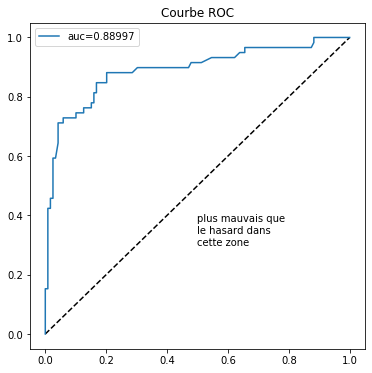

In [306]:
col=['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_female', 'Age_categories_Infant', 'Age_categories_Senior', 'Embarked_Q']
logisticeModel(col)